# CMPE257 Membership Inference Attack
# by: Anthony Frank, Bradley Yong, and Catherine Zhang


In [123]:
import math
import pandas as pd
import numpy as np
import random
import csv
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.utils import to_categorical

#Setup

In [124]:
# Change to where you prefer to save files.
file_dir = ""

In [125]:
def collect_survey_data():
    """
    Collects age, gender (as number), ethnicity (as number), distance, and satisfaction
    from the user via prompts for a single survey entry.
    Presents age and distance as numbered options for the user to select.
    Returns a dictionary where each key maps to a list containing the single collected value,
    suitable for pandas.DataFrame.from_dict().
    """
    print("--- Hospital Customer Satisfaction Survey ---")
    print("Please provide the following information:")

    # 1. Collect Age Category
    age_options = ["18-25", "26-45", "46-65", "65-95"]
    while True:
        print("\nSelect your age range:")
        for i, option in enumerate(age_options):
            print(f"{i + 1}. {option}")
        try:
            age_category = int(input(f"Enter the number corresponding to your choice (1-{len(age_options)}): "))
            if 1 <= age_category <= len(age_options):
                break
            else:
                print("Invalid choice. Please enter a number within the given range.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # 2. Collect Gender
    gender_options = ["Male", "Female", "Non-binary"]
    while True:
        print("\nSelect your gender:")
        for i, option in enumerate(gender_options):
            print(f"{i + 1}. {option}")
        try:
            gender_choice = int(input(f"Enter the number corresponding to your choice (1-{len(gender_options)}): "))
            if 1 <= gender_choice <= len(gender_options):
                gender = gender_choice  # Store the number
                break
            else:
                print("Invalid choice. Please enter a number within the given range.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # 3. Collect Ethnicity
    ethnicity_options = [
        "White",
        "Black/African American",
        "Asian",
        "Hispanic/Latinx",
        "Native American/Alaska Native",
        "Pacific Islander",
        "Two or More Races"
    ]
    while True:
        print("\nSelect your ethnicity:")
        for i, option in enumerate(ethnicity_options):
            print(f"{i + 1}. {option}")
        try:
            ethnicity_choice = int(input(f"Enter the number corresponding to your choice (1-{len(ethnicity_options)}): "))
            if 1 <= ethnicity_choice <= len(ethnicity_options):
                ethnicity = ethnicity_choice  # Store the number
                break
            else:
                print("Invalid choice. Please enter a number within the given range.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # 4. Collect Distance Category
    distance_options = ["5-10 miles", "11-20 miles", "21-30 miles"]
    while True:
        print("\nSelect the approximate distance you traveled to the hospital:")
        for i, option in enumerate(distance_options):
            print(f"{i + 1}. {option}")
        try:
            distance_category = int(input(f"Enter the number corresponding to your choice (1-{len(distance_options)}): "))
            if 1 <= distance_category <= len(distance_options):
                break
            else:
                print("Invalid choice. Please enter a number within the given range.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # 5. Collect Satisfaction
    while True:
        try:
            satisfaction = int(input("\nOn a scale of 1 to 4, where 1 is Very Dissatisfied and 4 is Very Satisfied, how would you rate your overall satisfaction? (1-4): "))
            if 1 <= satisfaction <= 4:
                break
            else:
                print("Invalid input. Please enter a number between 1 and 4.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # Store the CATEGORIZED values in the final dictionary
    final_survey_data = {
        "Age": [age_category],
        "Gender": [gender],
        "Ethnicity": [ethnicity],
        "Distance_Miles": [distance_category],
        "Satisfaction": [satisfaction]
    }

    print("\n--- Survey Complete! ---")
    print("Here is the information you provided (formatted for pandas DataFrame):")
    for key, value_list in final_survey_data.items():
        print(f"{key}: {value_list}")

    return final_survey_data

In [ ]:
def generate_fictional_survey_data(num_records=1000, filename="hospital_survey_data.csv"):
    """
    Generates a CSV file with fictional hospital survey data using categorical values for Age and Distance.

    Args:
        num_records (int): The number of data records (rows) to generate.
        filename (str): The name of the CSV file to create.
    """
    # Define the headers for the CSV file with new category names
    headers = ["Age", "Gender", "Ethnicity", "Distance_Miles", "Satisfaction"]

    # Define the possible options for each categorical feature
    # Age_Category: 1=18-25, 2=26-45, 3=46-65, 4=65-95
    age_category_options = [1, 2, 3, 4]
    # Gender: 1=Male, 2=Female, 3=Non-binary
    gender_options = [1, 2, 3]
    # Ethnicity: 1-7
    ethnicity_options = [1, 2, 3, 4, 5, 6, 7]
    # Distance_Category: 1=5-10 miles, 2=11-20 miles, 3=21-30 miles
    distance_category_options = [1, 2, 3]
    # Satisfaction: 1-4
    satisfaction_options = [1, 2, 3, 4]

    def satisfaction_func(gender,distance_category):
        """
        Determines a fictional satisfaction level based on the distance category.
        This function has been simplified to directly use the distance category.
        """
        if distance_category == 1:
            if gender == 2:
              return 3
            return 4  # Highest satisfaction for shortest distance
        elif distance_category == 2:
            if gender == 2:
              return 2
            return 3
        elif distance_category == 3:
            if gender == 2:
              return 1
            return 2  # Lower satisfaction for longer distance
        else:
            return 1 # Fallback for unexpected categories

    print(f"Generating {num_records} records into '{filename}'...")

    # Using 'with' statement for file handling to ensure proper closure
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write the header row
        csv_writer.writerow(headers)

        # Generate and write data rows
        for _ in range(num_records):
            age_category = random.choice(age_category_options)
            gender = random.choice(gender_options)
            ethnicity = random.choice(ethnicity_options)
            distance_category = random.choice(distance_category_options)
            satisfaction = satisfaction_func(gender,distance_category)

            # Write the generated row
            csv_writer.writerow([age_category, gender, ethnicity, distance_category, satisfaction])

    print(f"Successfully generated {num_records} records in '{filename}'.")

# To run the function:
generate_fictional_survey_data(filename= file_dir + 'hospital_survey_data.csv')

#Target Model: Customer Satification Prediction Model

##Survey
As a member MyCare Hospital, you we're emailed to take part in a survey to help train an AI model to predict your satification based off of your background.

In [127]:
your_results = collect_survey_data()
your_data_df = pd.DataFrame.from_dict(your_results)
display(your_data_df)

--- Hospital Customer Satisfaction Survey ---
Please provide the following information:

Select your age range:
1. 18-25
2. 26-45
3. 46-65
4. 65-95
Enter the number corresponding to your choice (1-4): 1

Select your gender:
1. Male
2. Female
3. Non-binary
Enter the number corresponding to your choice (1-3): 1

Select your ethnicity:
1. White
2. Black/African American
3. Asian
4. Hispanic/Latinx
5. Native American/Alaska Native
6. Pacific Islander
7. Two or More Races
Enter the number corresponding to your choice (1-7): 2

Select the approximate distance you traveled to the hospital:
1. 5-10 miles
2. 11-20 miles
3. 21-30 miles
Enter the number corresponding to your choice (1-3): 1

On a scale of 1 to 4, where 1 is Very Dissatisfied and 4 is Very Satisfied, how would you rate your overall satisfaction? (1-4): 4

--- Survey Complete! ---
Here is the information you provided (formatted for pandas DataFrame):
Age: [1]
Gender: [1]
Ethnicity: [2]
Distance_Miles: [1]
Satisfaction: [4]


Age  Gender  Ethnicity  Distance_Miles  Satisfaction
0    1       1          2               1             4

Now your data will end up within the dataset for training.

In [128]:
"""
TODO: This for development purposes. REMOVE when finished and replace with:
data = pd.read_csv('hospital_survey_data.csv')
"""
data = pd.read_csv(file_dir + 'hospital_survey_data.csv')
# Your results are 30th row of data in the dataset.
data = pd.concat([data[:30],your_data_df,data[30:]],ignore_index=True)
data.iloc[30]

Age               1
Gender            1
Ethnicity         2
Distance_Miles    1
Satisfaction      4
Name: 30, dtype: int64

In [129]:
data

Age  Gender  Ethnicity  Distance_Miles  Satisfaction
0       4       1          1               3             2
1       4       3          3               1             4
2       2       3          7               1             4
3       1       3          3               1             4
4       3       1          2               3             2
...   ...     ...        ...             ...           ...
996     4       3          6               3             2
997     2       1          7               2             3
998     4       3          7               2             3
999     4       2          1               3             1
1000    2       2          7               2             2

[1001 rows x 5 columns]

##Data Analysis
The Model Creator was able to find a correlation between Distance and Satisfaction, and decided to make a Classification model.

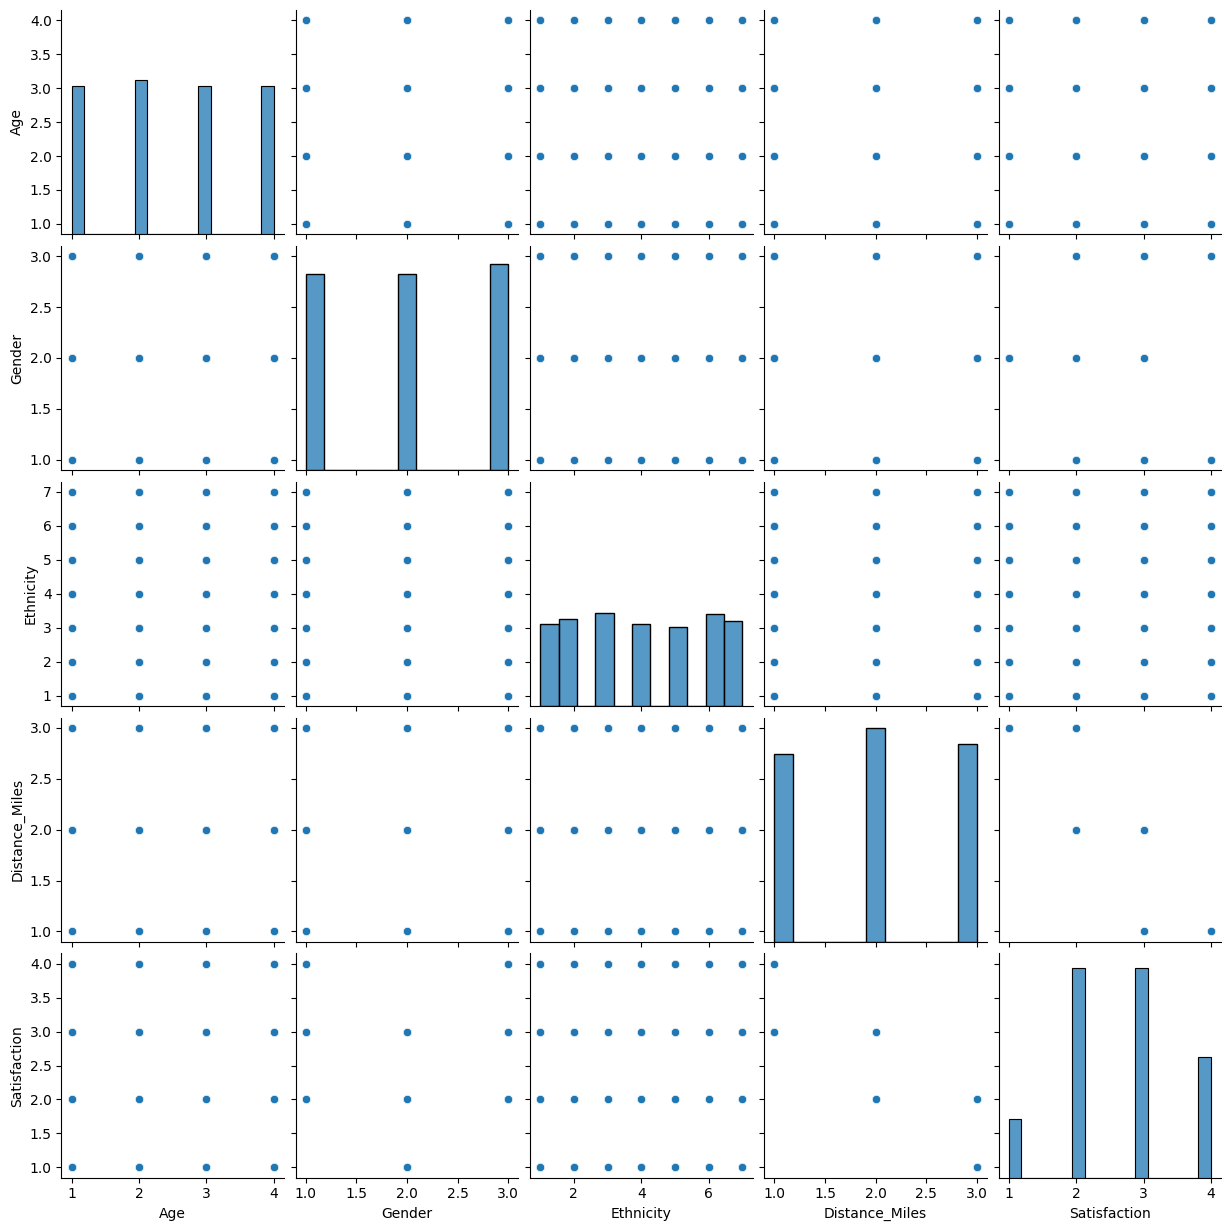

In [130]:
sns.pairplot(data,kind='scatter',diag_kind='hist')

<Axes: >

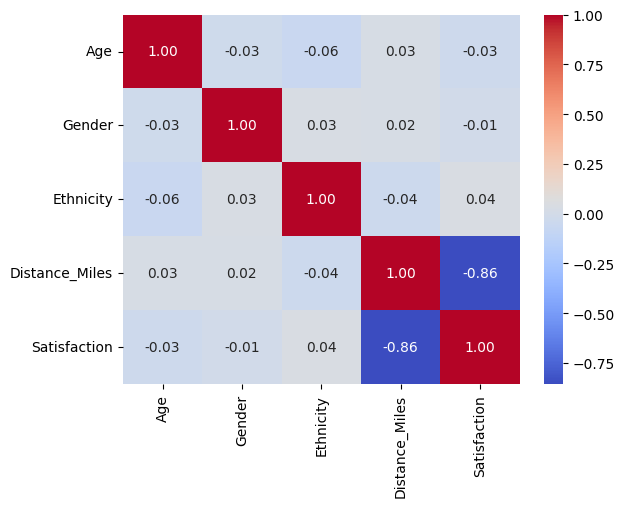

In [131]:
sns.heatmap(data.corr(),annot=True,cmap='coolwarm',fmt=".2f")

The Creator cleans the data by normalizing the Age and Distance with a MinMaxScaler, one-hot encoding categories: Gender, Ethinicity, and Satisifaction.

##Data Cleaning

In [132]:
data

Age  Gender  Ethnicity  Distance_Miles  Satisfaction
0       4       1          1               3             2
1       4       3          3               1             4
2       2       3          7               1             4
3       1       3          3               1             4
4       3       1          2               3             2
...   ...     ...        ...             ...           ...
996     4       3          6               3             2
997     2       1          7               2             3
998     4       3          7               2             3
999     4       2          1               3             1
1000    2       2          7               2             2

[1001 rows x 5 columns]

In [133]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
age_df = onehot_encoder.fit_transform(data[['Age']])
age_df = age_df.rename(columns={'Age_1':'18-25','Age_2':'26-45','Age_3':'46-65','Age_4':'66-95'})
display(age_df)

gender_df = onehot_encoder.fit_transform(data[['Gender']])
gender_df = gender_df.rename(columns={'Gender_1':'Male','Gender_2':'Female','Gender_3':'Non-binary'})
display(gender_df)

ethnicity_df = onehot_encoder.fit_transform(data[['Ethnicity']])
ethnicity_categories = {f"Ethnicity_{num}" : eth for num,eth in enumerate(["White",'Black/African_America','Asian','Hispanic/Latinx','Native American/Alskan Native','Pacific_Islander','Two_or_More_Races'],start=1)}
ethnicity_df = ethnicity_df.rename(columns=ethnicity_categories)
display(ethnicity_df)

distance_df = onehot_encoder.fit_transform(data[['Distance_Miles']])
distance_df = distance_df.rename(columns={f'Distance_Miles_{i}':f'{miles}_miles' for i,miles in enumerate(['5-10','11-20','21-30' ],start=1)})
display(distance_df)

satisfaction_df = onehot_encoder.fit_transform(data[['Satisfaction']])

satisfaction_categories = {old:new for old,new in zip(satisfaction_df.columns,["Very_Dissatisfied", "Dissatisfied","Satisfied","Very_Satisfied"])}
print(satisfaction_categories)
display(satisfaction_df)
satisfaction_df = satisfaction_df.rename(columns=satisfaction_categories)
display(satisfaction_df)

18-25  26-45  46-65  66-95
0       0.0    0.0    0.0    1.0
1       0.0    0.0    0.0    1.0
2       0.0    1.0    0.0    0.0
3       1.0    0.0    0.0    0.0
4       0.0    0.0    1.0    0.0
...     ...    ...    ...    ...
996     0.0    0.0    0.0    1.0
997     0.0    1.0    0.0    0.0
998     0.0    0.0    0.0    1.0
999     0.0    0.0    0.0    1.0
1000    0.0    1.0    0.0    0.0

[1001 rows x 4 columns]

Male  Female  Non-binary
0      1.0     0.0         0.0
1      0.0     0.0         1.0
2      0.0     0.0         1.0
3      0.0     0.0         1.0
4      1.0     0.0         0.0
...    ...     ...         ...
996    0.0     0.0         1.0
997    1.0     0.0         0.0
998    0.0     0.0         1.0
999    0.0     1.0         0.0
1000   0.0     1.0         0.0

[1001 rows x 3 columns]

White  Black/African_America  Asian  Hispanic/Latinx  \
0       1.0                    0.0    0.0              0.0   
1       0.0                    0.0    1.0              0.0   
2       0.0                    0.0    0.0              0.0   
3       0.0                    0.0    1.0              0.0   
4       0.0                    1.0    0.0              0.0   
...     ...                    ...    ...              ...   
996     0.0                    0.0    0.0              0.0   
997     0.0                    0.0    0.0              0.0   
998     0.0                    0.0    0.0              0.0   
999     1.0                    0.0    0.0              0.0   
1000    0.0                    0.0    0.0              0.0   

      Native American/Alskan Native  Pacific_Islander  Two_or_More_Races  
0                               0.0               0.0                0.0  
1                               0.0               0.0                0.0  
2                               0.0               0.0                1.0  
3                               0.0               0.0                0.0  
4                               0.0               0.0                0.0  
...                             ...               ...                ...  
996                             0.0               1.0                0.0  
997                             0.0               0.0                1.0  
998                             0.0               0.0                1.0  
999                             0.0               0.0                0.0  
1000                            0.0               0.0                1.0  

[1001 rows x 7 columns]

5-10_miles  11-20_miles  21-30_miles
0            0.0          0.0          1.0
1            1.0          0.0          0.0
2            1.0          0.0          0.0
3            1.0          0.0          0.0
4            0.0          0.0          1.0
...          ...          ...          ...
996          0.0          0.0          1.0
997          0.0          1.0          0.0
998          0.0          1.0          0.0
999          0.0          0.0          1.0
1000         0.0          1.0          0.0

[1001 rows x 3 columns]

{'Satisfaction_1': 'Very_Dissatisfied', 'Satisfaction_2': 'Dissatisfied', 'Satisfaction_3': 'Satisfied', 'Satisfaction_4': 'Very_Satisfied'}


Satisfaction_1  Satisfaction_2  Satisfaction_3  Satisfaction_4
0                0.0             1.0             0.0             0.0
1                0.0             0.0             0.0             1.0
2                0.0             0.0             0.0             1.0
3                0.0             0.0             0.0             1.0
4                0.0             1.0             0.0             0.0
...              ...             ...             ...             ...
996              0.0             1.0             0.0             0.0
997              0.0             0.0             1.0             0.0
998              0.0             0.0             1.0             0.0
999              1.0             0.0             0.0             0.0
1000             0.0             1.0             0.0             0.0

[1001 rows x 4 columns]

Very_Dissatisfied  Dissatisfied  Satisfied  Very_Satisfied
0                   0.0           1.0        0.0             0.0
1                   0.0           0.0        0.0             1.0
2                   0.0           0.0        0.0             1.0
3                   0.0           0.0        0.0             1.0
4                   0.0           1.0        0.0             0.0
...                 ...           ...        ...             ...
996                 0.0           1.0        0.0             0.0
997                 0.0           0.0        1.0             0.0
998                 0.0           0.0        1.0             0.0
999                 1.0           0.0        0.0             0.0
1000                0.0           1.0        0.0             0.0

[1001 rows x 4 columns]

In [134]:
clean_columns = list(age_df.columns) + list(gender_df.columns)  + list(ethnicity_df) + list(distance_df.columns) + list(satisfaction_df.columns)
clean_data = pd.concat([age_df,gender_df,ethnicity_df,distance_df,satisfaction_df],axis=1,ignore_index=True).rename(columns = {i:col for i, col in enumerate(clean_columns)})
display(clean_data)

18-25  26-45  46-65  66-95  Male  Female  Non-binary  White  \
0       0.0    0.0    0.0    1.0   1.0     0.0         0.0    1.0   
1       0.0    0.0    0.0    1.0   0.0     0.0         1.0    0.0   
2       0.0    1.0    0.0    0.0   0.0     0.0         1.0    0.0   
3       1.0    0.0    0.0    0.0   0.0     0.0         1.0    0.0   
4       0.0    0.0    1.0    0.0   1.0     0.0         0.0    0.0   
...     ...    ...    ...    ...   ...     ...         ...    ...   
996     0.0    0.0    0.0    1.0   0.0     0.0         1.0    0.0   
997     0.0    1.0    0.0    0.0   1.0     0.0         0.0    0.0   
998     0.0    0.0    0.0    1.0   0.0     0.0         1.0    0.0   
999     0.0    0.0    0.0    1.0   0.0     1.0         0.0    1.0   
1000    0.0    1.0    0.0    0.0   0.0     1.0         0.0    0.0   

      Black/African_America  Asian  ...  Native American/Alskan Native  \
0                       0.0    0.0  ...                            0.0   
1                       0.0    1.0  ...                            0.0   
2                       0.0    0.0  ...                            0.0   
3                       0.0    1.0  ...                            0.0   
4                       1.0    0.0  ...                            0.0   
...                     ...    ...  ...                            ...   
996                     0.0    0.0  ...                            0.0   
997                     0.0    0.0  ...                            0.0   
998                     0.0    0.0  ...                            0.0   
999                     0.0    0.0  ...                            0.0   
1000                    0.0    0.0  ...                            0.0   

      Pacific_Islander  Two_or_More_Races  5-10_miles  11-20_miles  \
0                  0.0                0.0         0.0          0.0   
1                  0.0                0.0         1.0          0.0   
2                  0.0                1.0         1.0          0.0   
3                  0.0                0.0         1.0          0.0   
4                  0.0                0.0         0.0          0.0   
...                ...                ...         ...          ...   
996                1.0                0.0         0.0          0.0   
997                0.0                1.0         0.0          1.0   
998                0.0                1.0         0.0          1.0   
999                0.0                0.0         0.0          0.0   
1000               0.0                1.0         0.0          1.0   

      21-30_miles  Very_Dissatisfied  Dissatisfied  Satisfied  Very_Satisfied  
0             1.0                0.0           1.0        0.0             0.0  
1             0.0                0.0           0.0        0.0             1.0  
2             0.0                0.0           0.0        0.0             1.0  
3             0.0                0.0           0.0        0.0             1.0  
4             1.0                0.0           1.0        0.0             0.0  
...           ...                ...           ...        ...             ...  
996           1.0                0.0           1.0        0.0             0.0  
997           0.0                0.0           0.0        1.0             0.0  
998           0.0                0.0           0.0        1.0             0.0  
999           1.0                1.0           0.0        0.0             0.0  
1000          0.0                0.0           1.0        0.0             0.0  

[1001 rows x 21 columns]

In [135]:
# Your data normailzed and one-hot encoded.
clean_data.iloc[30]

18-25                            1.0
26-45                            0.0
46-65                            0.0
66-95                            0.0
Male                             1.0
Female                           0.0
Non-binary                       0.0
White                            0.0
Black/African_America            1.0
Asian                            0.0
Hispanic/Latinx                  0.0
Native American/Alskan Native    0.0
Pacific_Islander                 0.0
Two_or_More_Races                0.0
5-10_miles                       1.0
11-20_miles                      0.0
21-30_miles                      0.0
Very_Dissatisfied                0.0
Dissatisfied                     0.0
Satisfied                        0.0
Very_Satisfied                   1.0
Name: 30, dtype: float64

In [136]:
clean_data.to_csv(file_dir + 'survey_dataset.csv',index=False)

In [137]:
clean_data = pd.read_csv(file_dir + 'survey_dataset.csv')
display(clean_data)

18-25  26-45  46-65  66-95  Male  Female  Non-binary  White  \
0       0.0    0.0    0.0    1.0   1.0     0.0         0.0    1.0   
1       0.0    0.0    0.0    1.0   0.0     0.0         1.0    0.0   
2       0.0    1.0    0.0    0.0   0.0     0.0         1.0    0.0   
3       1.0    0.0    0.0    0.0   0.0     0.0         1.0    0.0   
4       0.0    0.0    1.0    0.0   1.0     0.0         0.0    0.0   
...     ...    ...    ...    ...   ...     ...         ...    ...   
996     0.0    0.0    0.0    1.0   0.0     0.0         1.0    0.0   
997     0.0    1.0    0.0    0.0   1.0     0.0         0.0    0.0   
998     0.0    0.0    0.0    1.0   0.0     0.0         1.0    0.0   
999     0.0    0.0    0.0    1.0   0.0     1.0         0.0    1.0   
1000    0.0    1.0    0.0    0.0   0.0     1.0         0.0    0.0   

      Black/African_America  Asian  ...  Native American/Alskan Native  \
0                       0.0    0.0  ...                            0.0   
1                       0.0    1.0  ...                            0.0   
2                       0.0    0.0  ...                            0.0   
3                       0.0    1.0  ...                            0.0   
4                       1.0    0.0  ...                            0.0   
...                     ...    ...  ...                            ...   
996                     0.0    0.0  ...                            0.0   
997                     0.0    0.0  ...                            0.0   
998                     0.0    0.0  ...                            0.0   
999                     0.0    0.0  ...                            0.0   
1000                    0.0    0.0  ...                            0.0   

      Pacific_Islander  Two_or_More_Races  5-10_miles  11-20_miles  \
0                  0.0                0.0         0.0          0.0   
1                  0.0                0.0         1.0          0.0   
2                  0.0                1.0         1.0          0.0   
3                  0.0                0.0         1.0          0.0   
4                  0.0                0.0         0.0          0.0   
...                ...                ...         ...          ...   
996                1.0                0.0         0.0          0.0   
997                0.0                1.0         0.0          1.0   
998                0.0                1.0         0.0          1.0   
999                0.0                0.0         0.0          0.0   
1000               0.0                1.0         0.0          1.0   

      21-30_miles  Very_Dissatisfied  Dissatisfied  Satisfied  Very_Satisfied  
0             1.0                0.0           1.0        0.0             0.0  
1             0.0                0.0           0.0        0.0             1.0  
2             0.0                0.0           0.0        0.0             1.0  
3             0.0                0.0           0.0        0.0             1.0  
4             1.0                0.0           1.0        0.0             0.0  
...           ...                ...           ...        ...             ...  
996           1.0                0.0           1.0        0.0             0.0  
997           0.0                0.0           0.0        1.0             0.0  
998           0.0                0.0           0.0        1.0             0.0  
999           1.0                1.0           0.0        0.0             0.0  
1000          0.0                0.0           1.0        0.0             0.0  

[1001 rows x 21 columns]

##Model Training
With data cleaned, the creator can now train the model. They split the data to train on the first 100 rows of data which includes your data, and test on the next 82 rows. Afterward, the creator made a basic Neural Network for Classification to train for predicting a customers satisifaction based on the personal information provided.

In [138]:
X, y = clean_data.drop(list(clean_data.columns)[-4:],axis=1), clean_data[list(clean_data.columns)[-4:]]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=100,test_size=82,shuffle=False)

In [139]:
display(X_train)

18-25  26-45  46-65  66-95  Male  Female  Non-binary  White  \
0     0.0    0.0    0.0    1.0   1.0     0.0         0.0    1.0   
1     0.0    0.0    0.0    1.0   0.0     0.0         1.0    0.0   
2     0.0    1.0    0.0    0.0   0.0     0.0         1.0    0.0   
3     1.0    0.0    0.0    0.0   0.0     0.0         1.0    0.0   
4     0.0    0.0    1.0    0.0   1.0     0.0         0.0    0.0   
..    ...    ...    ...    ...   ...     ...         ...    ...   
95    0.0    0.0    1.0    0.0   0.0     1.0         0.0    0.0   
96    0.0    1.0    0.0    0.0   0.0     1.0         0.0    0.0   
97    0.0    0.0    0.0    1.0   0.0     1.0         0.0    1.0   
98    0.0    0.0    1.0    0.0   0.0     1.0         0.0    0.0   
99    1.0    0.0    0.0    0.0   0.0     0.0         1.0    0.0   

    Black/African_America  Asian  Hispanic/Latinx  \
0                     0.0    0.0              0.0   
1                     0.0    1.0              0.0   
2                     0.0    0.0              0.0   
3                     0.0    1.0              0.0   
4                     1.0    0.0              0.0   
..                    ...    ...              ...   
95                    0.0    0.0              0.0   
96                    0.0    0.0              0.0   
97                    0.0    0.0              0.0   
98                    0.0    0.0              0.0   
99                    0.0    0.0              0.0   

    Native American/Alskan Native  Pacific_Islander  Two_or_More_Races  \
0                             0.0               0.0                0.0   
1                             0.0               0.0                0.0   
2                             0.0               0.0                1.0   
3                             0.0               0.0                0.0   
4                             0.0               0.0                0.0   
..                            ...               ...                ...   
95                            0.0               0.0                1.0   
96                            0.0               1.0                0.0   
97                            0.0               0.0                0.0   
98                            0.0               0.0                1.0   
99                            0.0               1.0                0.0   

    5-10_miles  11-20_miles  21-30_miles  
0          0.0          0.0          1.0  
1          1.0          0.0          0.0  
2          1.0          0.0          0.0  
3          1.0          0.0          0.0  
4          0.0          0.0          1.0  
..         ...          ...          ...  
95         0.0          1.0          0.0  
96         0.0          0.0          1.0  
97         0.0          0.0          1.0  
98         0.0          0.0          1.0  
99         0.0          1.0          0.0  

[100 rows x 17 columns]

In [140]:
model = Sequential([
    Dense(12,activation='sigmoid',name='input',input_shape=(X_train.shape[1],)),
    Dense(4,activation='softmax',name='output'),
])
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.03),
              metrics=[keras.metrics.CategoricalCrossentropy()])
history = model.fit(X_train,
          y_train,
          batch_size=64,
          epochs=100,
          validation_data=(X_test,y_test)
          )


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - categorical_crossentropy: 1.3369 - loss: 1.3369 - val_categorical_crossentropy: 1.2302 - val_loss: 1.2302
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - categorical_crossentropy: 1.2670 - loss: 1.2670 - val_categorical_crossentropy: 1.2364 - val_loss: 1.2364
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.2283 - loss: 1.2283 - val_categorical_crossentropy: 1.2499 - val_loss: 1.2499
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.2186 - loss: 1.2186 - val_categorical_crossentropy: 1.2207 - val_loss: 1.2207
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_crossentropy: 1.1588 - loss: 1.1588 - val_categorical_crossentropy: 1.1717 - val_loss: 1.1717
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.1253 - loss: 1.1253 - val_categorical_crossentropy: 1.1082 - val_loss: 1.1082
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorica

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Dense)                   │ (None, 12)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806 (3.15 KB)

 Trainable params: 268 (1.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 538 (2.11 KB)

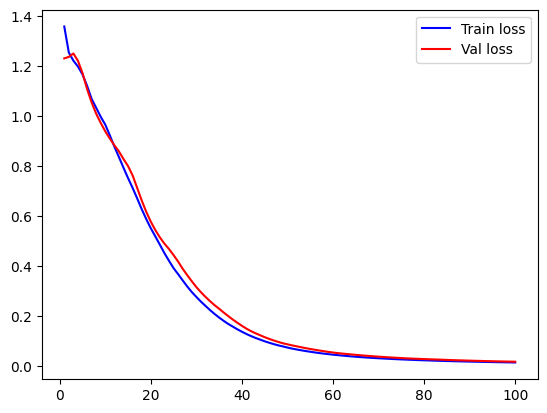

In [141]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(val_loss) + 1)

plt.plot(epochs,train_loss,'b',label = 'Train loss')
plt.plot(epochs,val_loss,'r',label = 'Val loss')
plt.legend()
model.summary()

In [142]:
# model.evaluate(X_test,y_test, batch_size=128)
test = X_test.iloc[-1].to_numpy().reshape((1,X_train.shape[1]))
print([max(out) for out in model.call(X_test).numpy().tolist()])
print(y_test.iloc[-1])


[0.961181640625, 0.9940348863601685, 0.961181640625, 0.9897567629814148, 0.9968937635421753, 0.9927046895027161, 0.9897567629814148, 0.9911635518074036, 0.9667501449584961, 0.9602177143096924, 0.9888221025466919, 0.9826306104660034, 0.9316151738166809, 0.9745761752128601, 0.9939554929733276, 0.9825262427330017, 0.9898578524589539, 0.9799256324768066, 0.9920057058334351, 0.9926270842552185, 0.996914803981781, 0.9882998466491699, 0.9874794483184814, 0.9665094614028931, 0.986534595489502, 0.9788960218429565, 0.982041597366333, 0.9904531836509705, 0.9879388809204102, 0.9914719462394714, 0.9869274497032166, 0.9457520842552185, 0.9940502643585205, 0.9834185838699341, 0.9826306104660034, 0.9688934087753296, 0.9938216209411621, 0.9881418347358704, 0.9745761752128601, 0.9871588349342346, 0.9727442264556885, 0.9753575921058655, 0.9846444129943848, 0.9753575921058655, 0.9931296706199646, 0.98868727684021, 0.97381991147995, 0.9912478923797607, 0.9887622594833374, 0.98287034034729, 0.98444503545761

The Model creator saw there's was overfitting but decided that it was good enough for deployment. They made a quick API document and LinkedIn post for how to use the model.
##API
### Request Body

The request body should be a **JSON object** with the following fields and data types. All fields are required.

| Parameter | Type | Description |
| :--- | :--- | :--- |
| age | Integer | The patient's age. **1**: 18-25 yrs, **2**: 26-45 yrs, **3**: 46-65 yrs, **4**: 66-90 yrs |
| gender | Integer | The patient's gender identity. Use the following codes:\<br\>• **1**: Male\<br\>• **2**: Female\<br\>• **3**: Non-binary |
| ethnicity | Integer | The patient's ethnicity. Use the following codes:\<br\>• **1**: White\<br\>• **2**: Black/African American\<br\>• **3**: Asian\<br\>• **4**: Hispanic/Latinx\<br\>• **5**: Native American/Alaska Native\<br\>• **6**: Pacific Islander\<br\>• **7**: Two or More Races |
| distance\_to\_hospital| Integer | The distance in miles the patient traveled to the hospital.  **1**: 5-10 mi, **2**: 11-20 mi, **3**: 21-30 mi|


### Response Body
***
A successful request will return a **JSON object** containing a softmax distribution of probabilities for each of the four satisfaction levels. The probabilities for all categories will sum to **1.0**.

| Parameter | Type | Description |
| :--- | :--- | :--- |
| **satisfaction_probabilities** | Object | A dictionary with satisfaction levels as keys and their corresponding probabilities as float values. |


<br>
<br>
<br>

##The creator even made a post on LinkedIn about it.

---
I am excited to announce the release of my new **Patient Satisfaction API**! This project, a personal passion of mine, was trained on data from different members of **MyCare hospital** in my hometown.

By using a neural network model, I've developed a tool that can predict patient satisfaction based on key factors like age, gender, ethnicity, and travel distance to the hospital. This isn't just about data—it's about empowering healthcare providers with the insights needed to create more positive patient experiences.

A huge thank you to the **MyCare** hospital members whose input and collaboration made this project possible. Their commitment to improving healthcare is truly inspiring. I'm looking forward to seeing how this API can be used to drive meaningful change.

---
#AIinHealthcare #HealthcareInnovation #PatientExperience #NeuralNetworks #API #DataScience #StLouis

#Hacker: Membership Inference Attack
A hacker found the LinkedIn Post, and checked out the link leading API documentation. Noticing that the API request requires personal and identifying information and the model's response was probabiltiy distribution, decided they could steal data training to get the hospital member's sensitive and confidential information using a Membership Inference Attack.

#Shadow Dataset
First the hacker needs copy of the model but since this isn't available they'll need to make one so they need the data which also they don't have and are to steal. They may not have the data but they can get a feel of what data could've been used based on the probability distributions the model returns. The hacker infers that data points the model was trained would have probablility distribution that clearly favors one category more than the rest. The hacker would query the model and randomly change different features to maximize the probability of a specific category. Once the category's probability reachs a certain threshold the data point will be saved. This process is called **Model-based synthesis**, to use the model to create a shadow dataset that consists of data ponits with high probabilities.

In [143]:
shadow_age_scaler = MinMaxScaler().fit([[18],[90]])
shadow_distance_scaler = MinMaxScaler().fit([[0.5],[35]])
def random_input(record=None,change_features=None):
    age_categories = 3
    distance_categories = 2 # From 0.5 to 75 miles
    age_options = [0, 0, 0,0]
    gender_options = [0, 0, 0]
    ethnicity_options = [0, 0, 0, 0, 0, 0, 0]
    distance_options = [0, 0, 0]
    if record is None or not change_features:
      age = random.randint(0, len(age_options)-1)
      gender = random.randint(0,len(gender_options)-1)
      ethnicity = random.randint(0,len(ethnicity_options)-1)
      distance = random.randint(0,len(distance_options) - 1)
      age_options[age] = 1
      gender_options[gender] = 1
      ethnicity_options[ethnicity] = 1
      distance_options[distance] = 1
      random_record = age_options + gender_options + ethnicity_options + distance_options

      # Ethnicity: 1-7 (as per your script)
      return np.array(random_record).reshape((-1,17))
    else:
      record = record[0].tolist()
      age, gender, ethnicity, distance = record[:4], record[4:7], record[7:14], record[14:]
      changed = set()
      k = 0
      while k < change_features:
        choice = random.randint(0,len(record)-1)
        if choice in changed:
          continue
        changed.add(choice)
        if choice == 0:
          age = random.randint(0, age_categories)
          age_options[age] = 1
        elif 1 <= choice <= 3:
          gender = random.randint(0,len(gender_options)-1)
          gender_options[gender] = 1
        elif 4 <= choice <= 11:
          ethnicity = [0, 0, 0, 0, 0, 0, 0]
          ethnicity[random.randint(0,len(ethnicity_options)-1)] = 1
        else:
          distance = random.randint(0, len(distance_options)-1)
          distance_options[distance] = 1
        k += 1
      random_record = age_options + gender_options + ethnicity_options + distance_options

      # Ethnicity: 1-7 (as per your script)
      return np.array(random_record).reshape((-1,17))

"""
  Maybe we should also return the model's output probability, and train the
  shadow model to mimic the distribution instead of training from scratch
  from the most likely class.
"""
def synthesize(model,expected_class):
  x = random_input()
  last_accepted_y = 0
  min_confindence = 0.85
  rejects = 0
  max_rejects = 10
  max_features = 4
  min_features = 1
  change_features = max_features

  for i in range(100):
    y = model.call(x)
    output = int(np.argmax(y) + 1)
    class_prob = float(y[0, expected_class-1])
    if class_prob >= last_accepted_y:
      if class_prob > min_confindence and expected_class == output:
        return x.tolist()[0]
      last_accepted_x = x
      last_accepted_y = class_prob
      rejects = 0
    else:
      rejects += 1
      if rejects > max_rejects:
        change_features = max(min_features,math.ceil(change_features/2))
        rejects = 0

    x = random_input(last_accepted_x,change_features)

  return None
def generate_shadow_dataset(inputs_per_class=250):
  columns = [
            "18-25",
            "26-45",
            "45-65",
            "66-90",
            "Male",
             "Female",
             "Non-binary",
            "White",
            "Black/African American",
            "Asian",
            "Hispanic/Latinx",
            "Native American/Alaska Native",
            "Pacific Islander",
            "Two or More Races" ,
            "5-10 miles",
            "11-20 miles",
            "21-30 miles",
            "Very Dissatisfied",
            "Dissatisfied",
            "Satisfied",
            "Very Satisfied",
            ]
  satisfaction_levels = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
  with open(file_dir + "shadow_dataset.csv",'w',newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(columns)
    num_classes = len(satisfaction_levels)
    rows = num_classes * inputs_per_class
    pbar = tqdm(total=rows,desc="Generating Shadow Dataset",position=0,leave=True)
    for i in range(num_classes):
      j = 0
      while j < inputs_per_class:
          point = synthesize(model,i+1)
          if point is not None:
            writer.writerow(point + satisfaction_levels[i])
            j += 1
            pbar.update(1)



In [144]:
generate_shadow_dataset()

Generating Shadow Dataset: 100%|██████████| 1000/1000 [00:28<00:00, 35.10it/s]


In [145]:
shadow_dataset = pd.read_csv(file_dir + 'shadow_dataset.csv')
display(shadow_dataset)

18-25  26-45  45-65  66-90  Male  Female  Non-binary  White  \
0        0      0      0      0     0       1           0      0   
1        0      0      0      0     0       1           0      0   
2        0      0      0      0     0       1           0      0   
3        0      0      0      0     0       1           0      0   
4        0      0      0      0     0       1           0      0   
..     ...    ...    ...    ...   ...     ...         ...    ...   
995      0      1      0      0     0       0           0      0   
996      0      1      0      0     1       0           0      0   
997      0      0      0      0     0       0           1      0   
998      0      0      0      0     1       0           0      0   
999      0      0      0      1     0       0           1      0   

     Black/African American  Asian  ...  Native American/Alaska Native  \
0                         0      0  ...                              0   
1                         0      0  ...                              0   
2                         0      0  ...                              0   
3                         0      0  ...                              0   
4                         0      0  ...                              0   
..                      ...    ...  ...                            ...   
995                       0      0  ...                              0   
996                       0      0  ...                              0   
997                       0      0  ...                              0   
998                       0      0  ...                              0   
999                       0      1  ...                              0   

     Pacific Islander  Two or More Races  5-10 miles  11-20 miles  \
0                   0                  0           0            0   
1                   0                  0           0            0   
2                   0                  0           0            0   
3                   0                  0           0            0   
4                   0                  0           1            0   
..                ...                ...         ...          ...   
995                 0                  0           1            0   
996                 0                  1           1            0   
997                 0                  0           1            0   
998                 0                  0           1            0   
999                 0                  0           1            0   

     21-30 miles  Very Dissatisfied  Dissatisfied  Satisfied  Very Satisfied  
0              1                  1             0          0               0  
1              0                  1             0          0               0  
2              0                  1             0          0               0  
3              0                  1             0          0               0  
4              1                  1             0          0               0  
..           ...                ...           ...        ...             ...  
995            0                  0             0          0               1  
996            0                  0             0          0               1  
997            0                  0             0          0               1  
998            1                  0             0          0               1  
999            0                  0             0          0               1  

[1000 rows x 21 columns]

In [146]:
shadow_dataset = shadow_dataset.drop_duplicates()

In [147]:
shadow_X, shadow_y = shadow_dataset.drop(['Very Dissatisfied', 'Dissatisfied', 'Satisfied', 'Very Satisfied'],axis=1), shadow_dataset[['Very Dissatisfied', 'Dissatisfied', 'Satisfied', 'Very Satisfied']]
shadow_X_train, shadow_X_test, shadow_y_train, shadow_y_test = train_test_split(shadow_X,shadow_y,train_size=100,test_size=82,shuffle=True)
shadow_X_train

18-25  26-45  45-65  66-90  Male  Female  Non-binary  White  \
291      0      1      0      0     1       0           0      0   
15       0      1      0      0     0       1           0      0   
581      0      0      1      0     0       1           0      0   
363      0      1      0      0     0       0           1      0   
380      0      1      0      0     0       1           0      0   
..     ...    ...    ...    ...   ...     ...         ...    ...   
250      0      1      0      0     0       1           0      0   
263      0      0      0      0     0       0           1      0   
191      1      0      0      0     0       1           0      0   
804      0      0      0      1     0       0           1      0   
636      0      0      0      1     0       1           0      0   

     Black/African American  Asian  Hispanic/Latinx  \
291                       0      0                1   
15                        0      0                1   
581                       0      0                0   
363                       0      1                0   
380                       0      0                0   
..                      ...    ...              ...   
250                       0      0                0   
263                       0      0                0   
191                       0      0                0   
804                       0      0                0   
636                       0      0                0   

     Native American/Alaska Native  Pacific Islander  Two or More Races  \
291                              0                 0                  0   
15                               0                 0                  0   
581                              0                 0                  1   
363                              0                 0                  0   
380                              0                 0                  1   
..                             ...               ...                ...   
250                              1                 0                  0   
263                              0                 0                  0   
191                              0                 0                  0   
804                              0                 0                  1   
636                              0                 0                  1   

     5-10 miles  11-20 miles  21-30 miles  
291           0            0            1  
15            0            0            1  
581           1            0            0  
363           0            0            1  
380           0            1            0  
..          ...          ...          ...  
250           0            1            0  
263           0            0            1  
191           1            0            1  
804           1            0            0  
636           1            0            0  

[100 rows x 17 columns]

#Shadow model
The hacker will then develope a model that will train on the shadow dataset. The reason for creating these model is to create probability distributions to save for the attack dataset for the Attack Model's training. There will be many of the shadow models each trained on random set data points to get a diverse set of probability distributions.

In [148]:
def train_shadow_model(shadow_X_train,shadow_y_train,shadow_X_test,shadow_y_test):
  shadow_model = Sequential([
      Dense(12,activation='sigmoid',name='input',input_shape=(shadow_X_train.shape[1],)),
      Dense(4,activation='softmax',name='output'),
  ])
  shadow_model.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(learning_rate=0.03),
                metrics=[keras.metrics.CategoricalCrossentropy()])
  shadow_history = shadow_model.fit(shadow_X_train,
            shadow_y_train,
            batch_size=64,
            epochs=100,
            validation_data=(shadow_X_test,shadow_y_test)
            )
  return shadow_model,shadow_history


In [149]:

shadow_model, shadow_history = train_shadow_model(shadow_X_train,shadow_y_train,shadow_X_test,shadow_y_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - categorical_crossentropy: 1.6263 - loss: 1.6263 - val_categorical_crossentropy: 1.3455 - val_loss: 1.3455
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_crossentropy: 1.3579 - loss: 1.3579 - val_categorical_crossentropy: 1.2275 - val_loss: 1.2275
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.2460 - loss: 1.2460 - val_categorical_crossentropy: 1.2351 - val_loss: 1.2351
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.2219 - loss: 1.2219 - val_categorical_crossentropy: 1.2593 - val_loss: 1.2593
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2193 - loss: 1.2193 - val_categorical_crossentropy: 1.2453 - val_loss: 1.2453
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.1620 - loss: 1.1620 - val_categorical_crossentropy: 1.1910 - val_loss: 1.1910
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step -

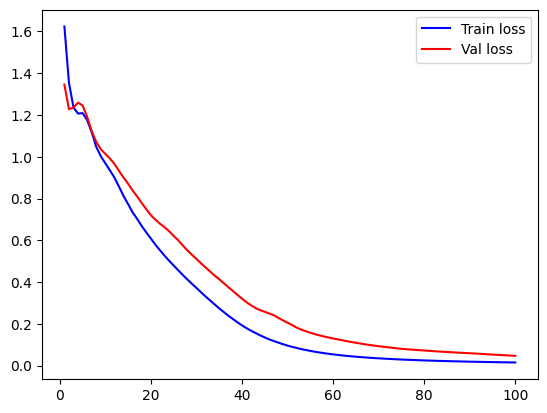

In [150]:
shadow_train_loss = shadow_history.history['loss']
shadow_val_loss = shadow_history.history['val_loss']
epochs = range(1,len(shadow_val_loss) + 1)

plt.plot(epochs,shadow_train_loss,'b',label = 'Train loss')
plt.plot(epochs,shadow_val_loss,'r',label = 'Val loss')
plt.legend()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[1, 0, 0, 0]


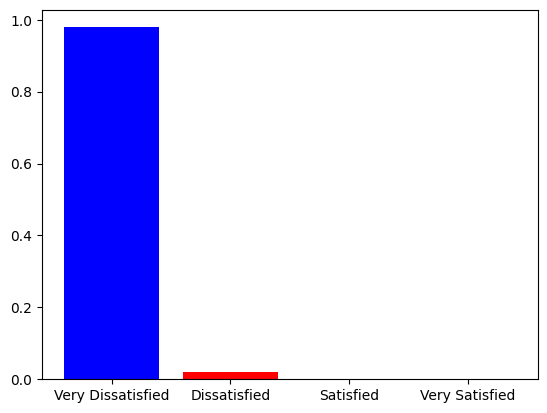

[0, 1, 0, 0]


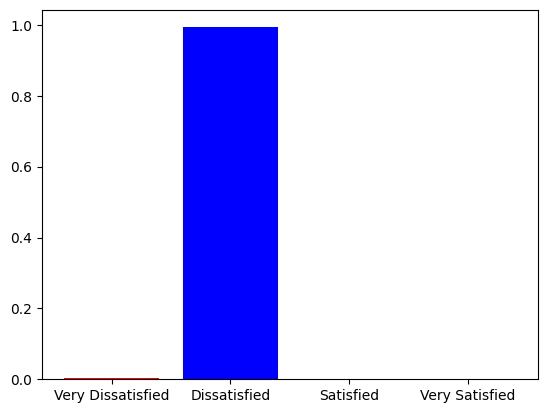

[0, 0, 0, 1]


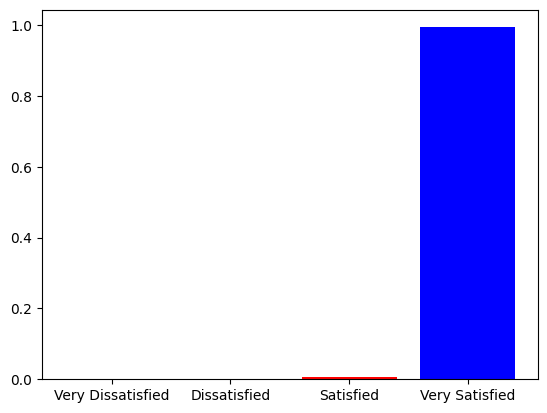

[0, 0, 1, 0]


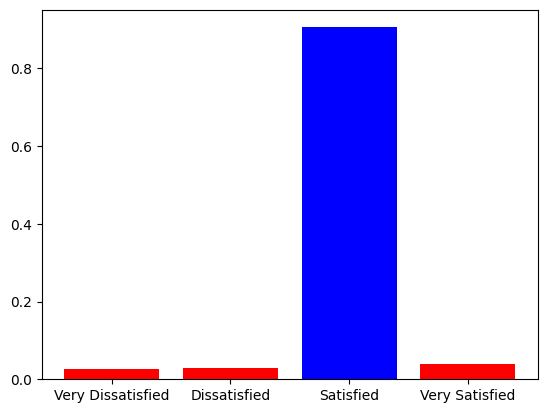

[0, 1, 0, 0]


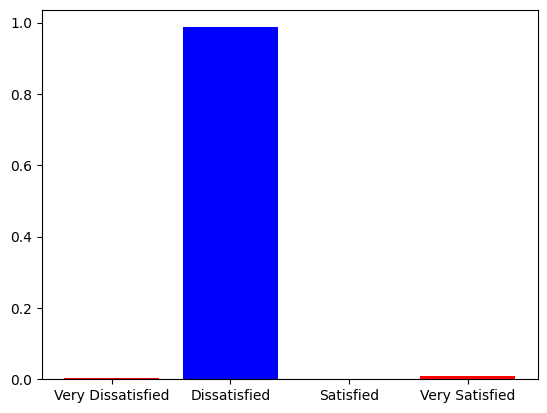

[0, 0, 0, 1]


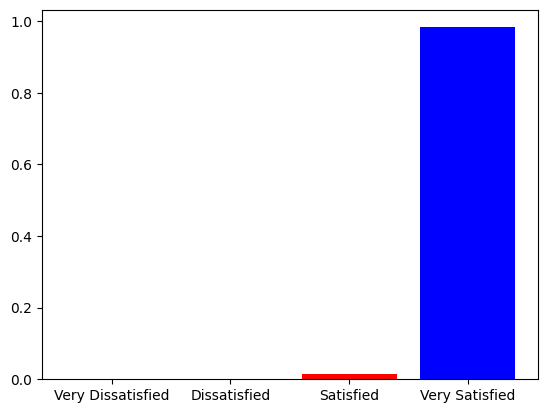

[0, 1, 0, 0]


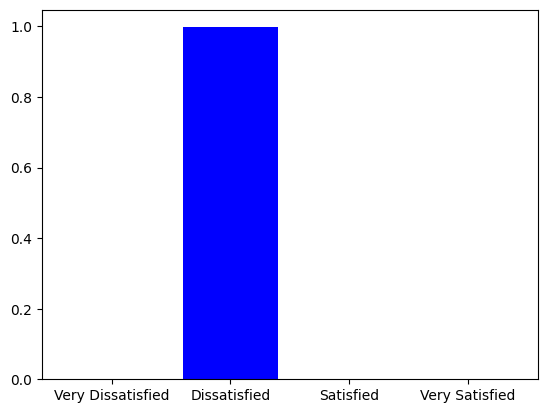

[1, 0, 0, 0]


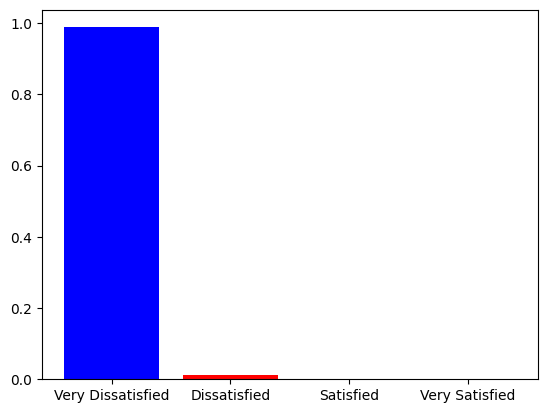

[0, 0, 0, 1]


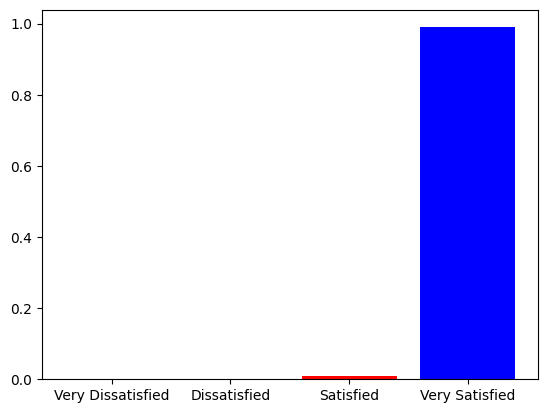

[0, 1, 0, 0]


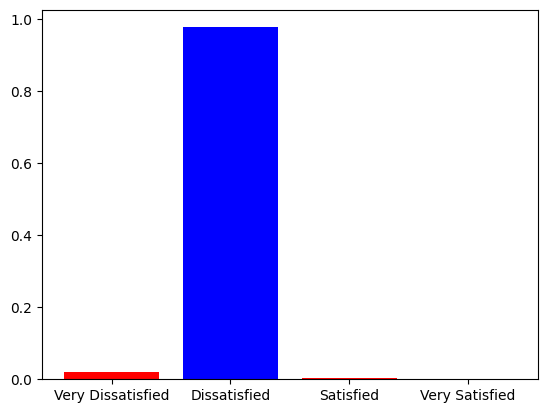

[0, 1, 0, 0]


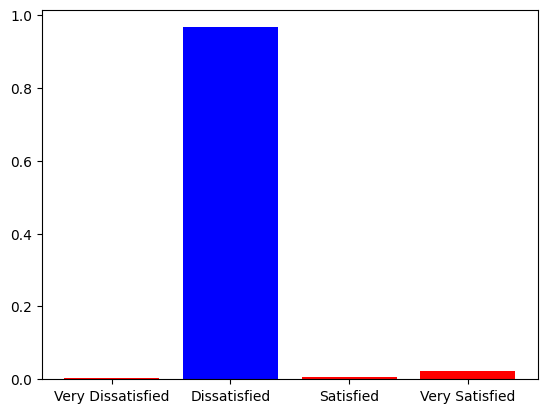

[0, 1, 0, 0]


[0, 0, 1, 0]


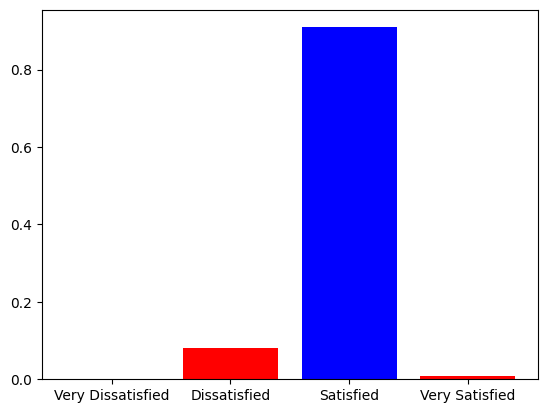

[0, 0, 0, 1]


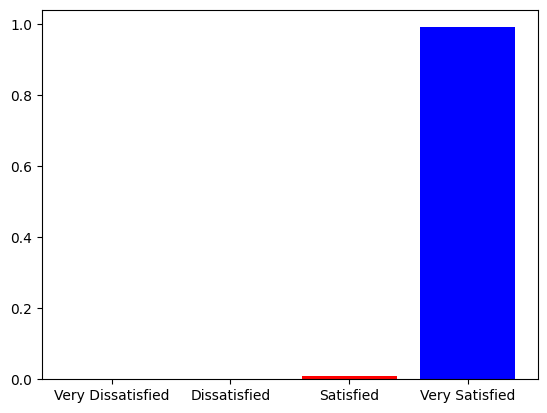

[0, 0, 1, 0]


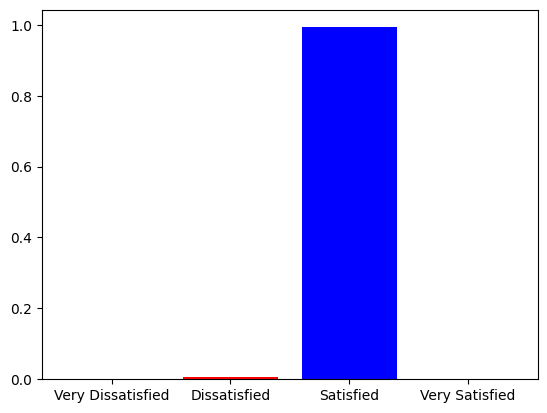

[0, 1, 0, 0]


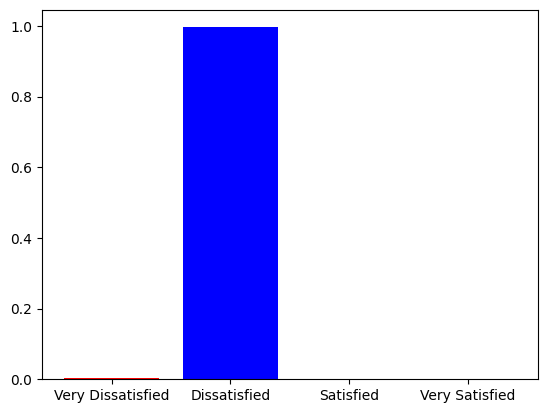

[0, 1, 0, 0]


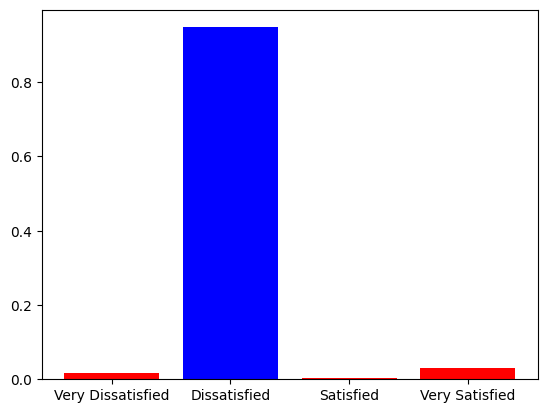

[0, 0, 1, 0]


[0, 1, 0, 0]


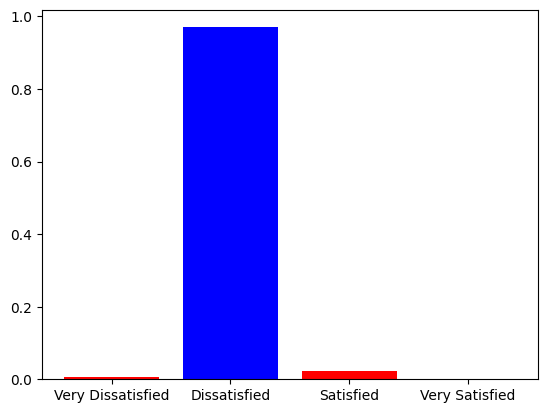

[0, 0, 1, 0]


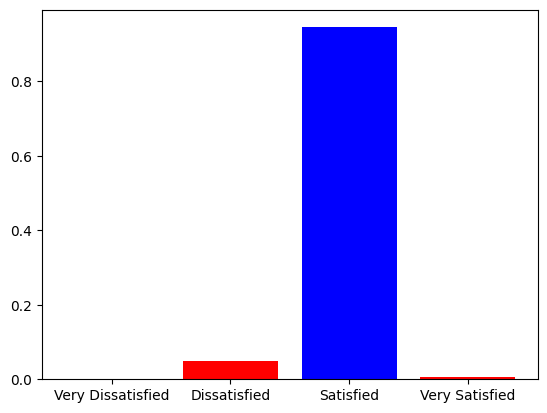

[0, 0, 1, 0]


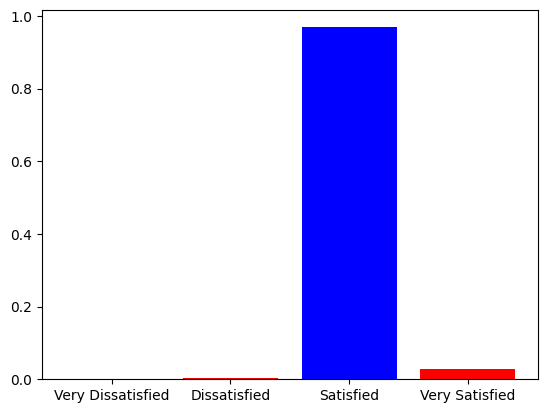

[0, 0, 1, 0]


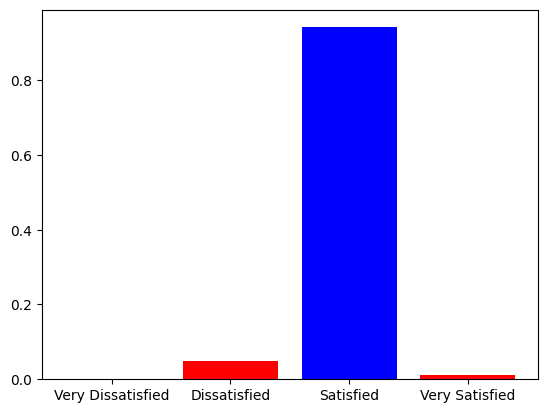

[0, 1, 0, 0]


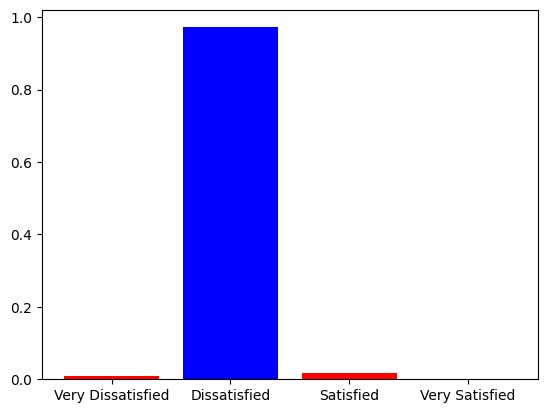

[0, 0, 0, 1]


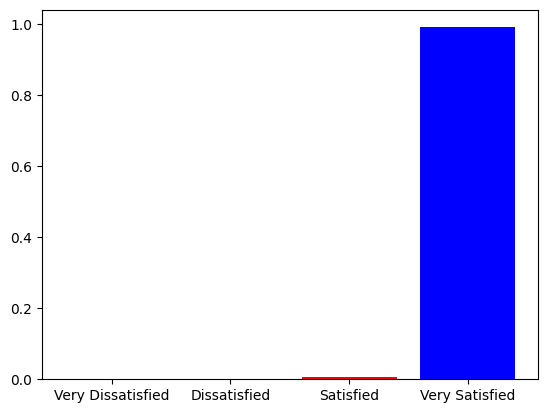

[0, 0, 1, 0]


[0, 1, 0, 0]


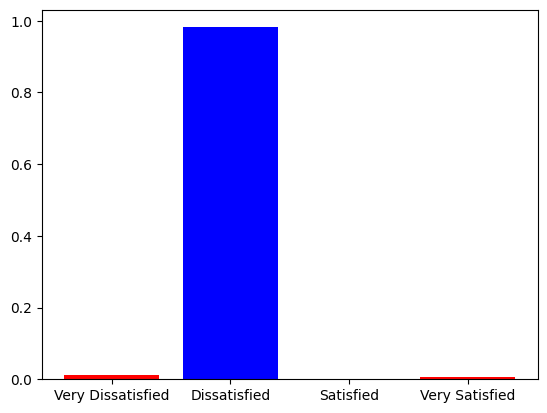

[0, 0, 1, 0]


[0, 0, 0, 1]


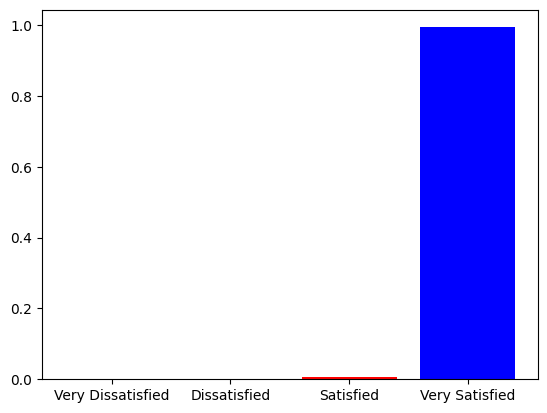

[0, 0, 1, 0]


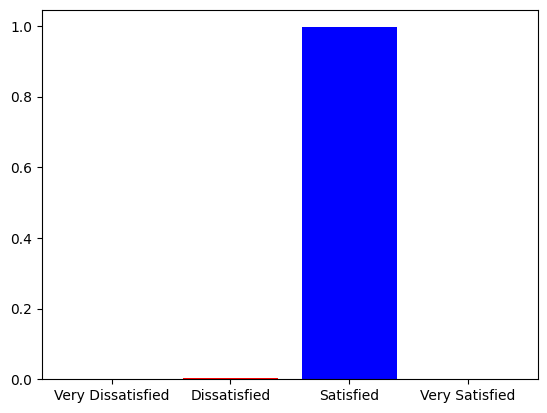

[0, 0, 1, 0]


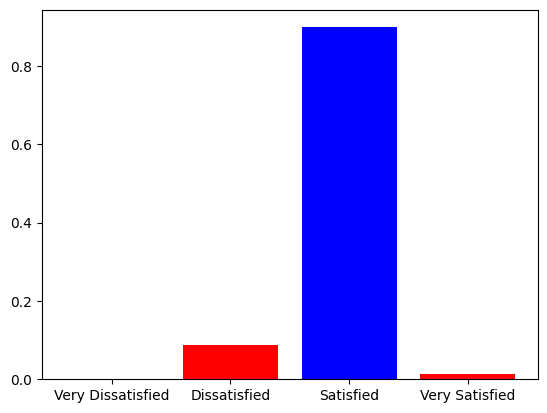

[0, 0, 1, 0]


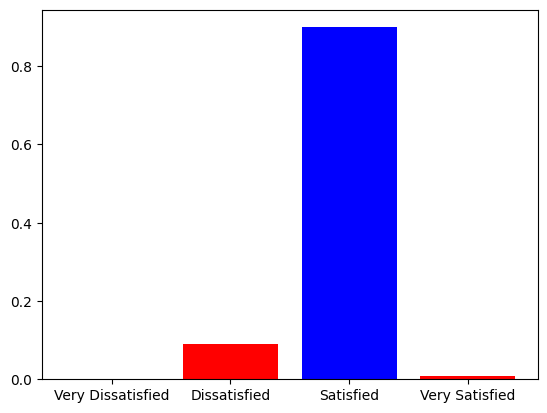

[0, 0, 0, 1]


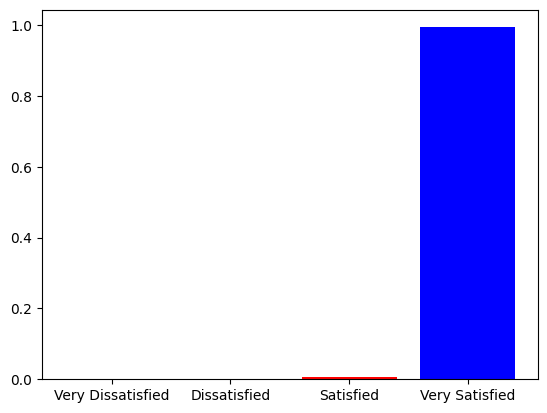

[1, 0, 0, 0]


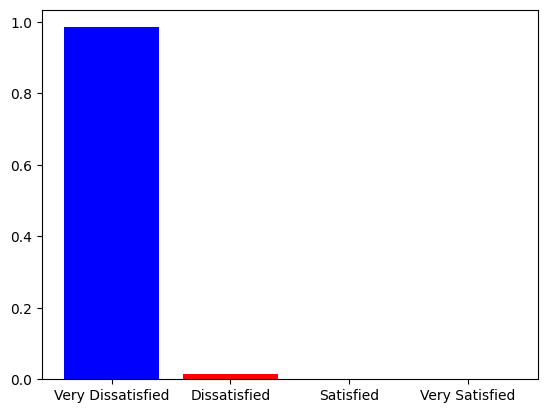

[0, 0, 1, 0]


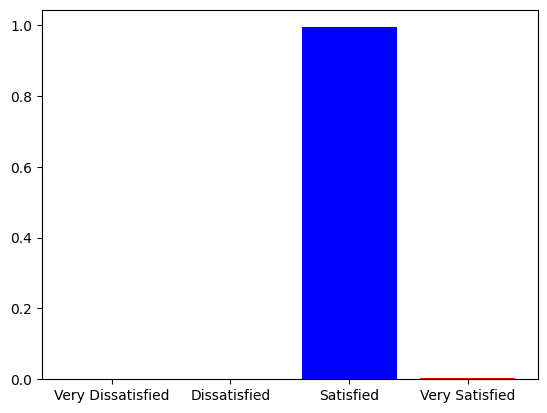

[0, 1, 0, 0]


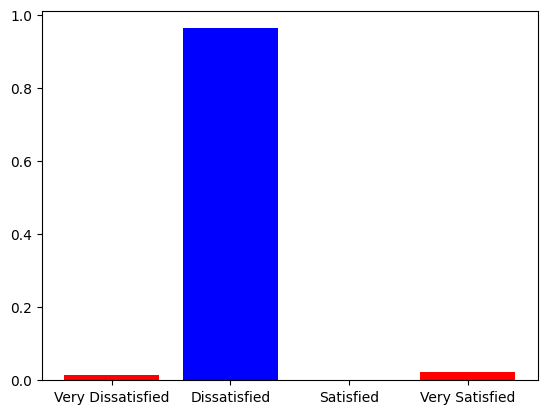

[0, 1, 0, 0]


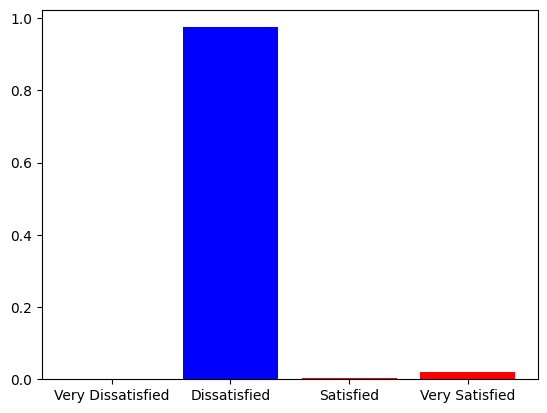

[0, 0, 1, 0]


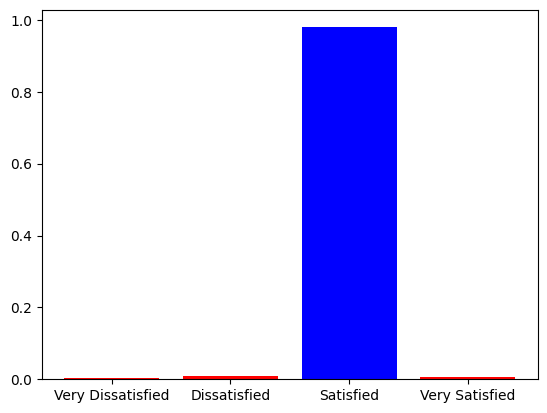

[0, 1, 0, 0]


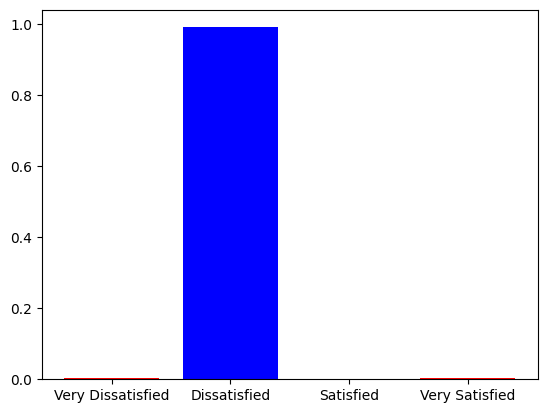

[0, 0, 1, 0]


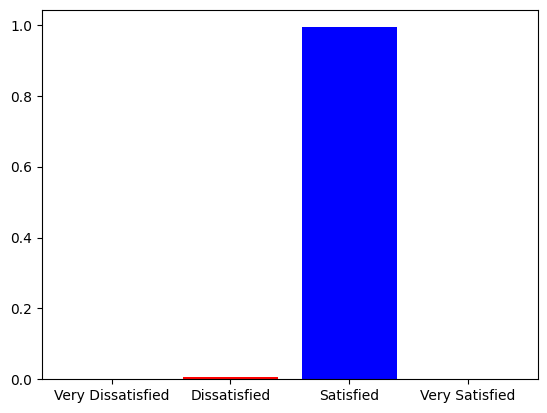

[1, 0, 0, 0]


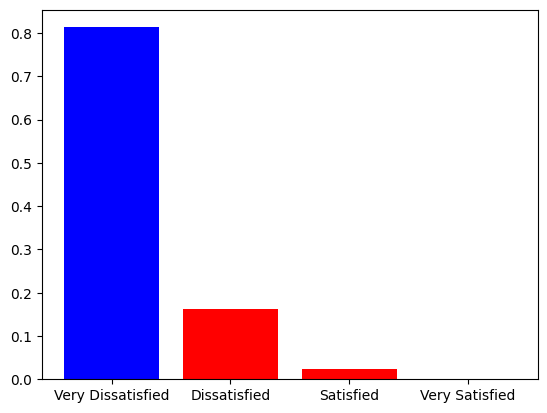

[0, 0, 1, 0]


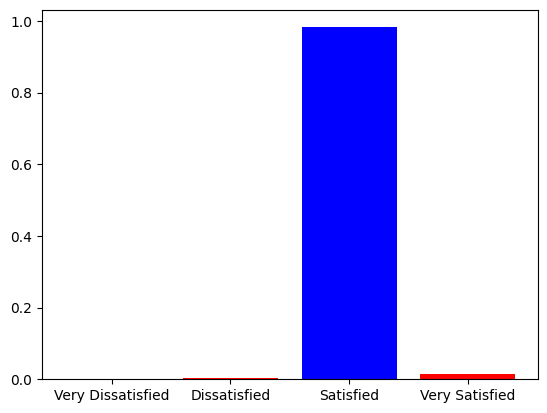

[0, 0, 1, 0]


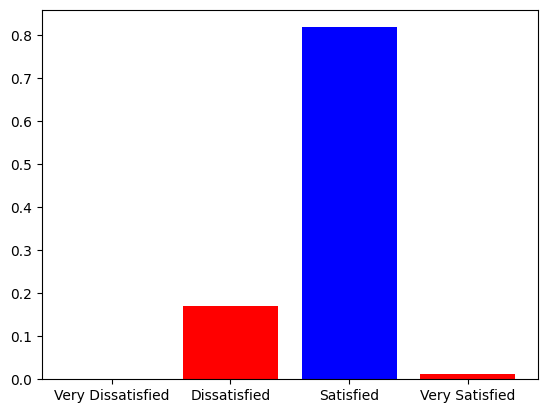

[0, 0, 0, 1]


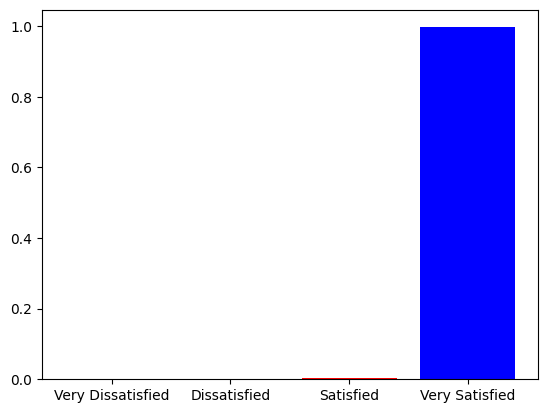

[0, 0, 0, 1]


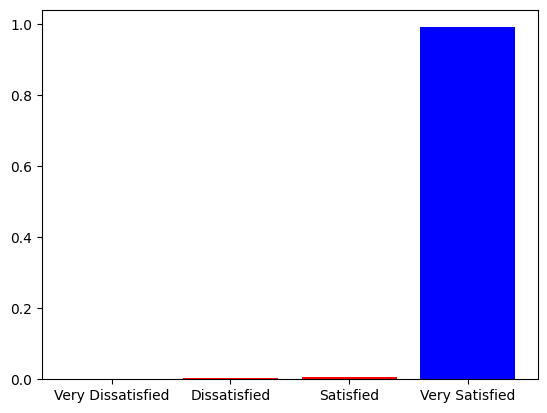

[0, 0, 1, 0]


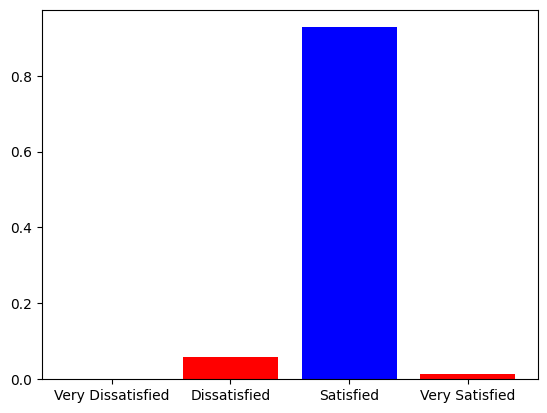

[1, 0, 0, 0]


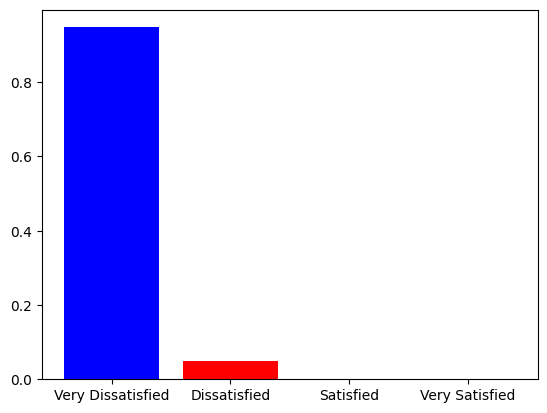

[1, 0, 0, 0]


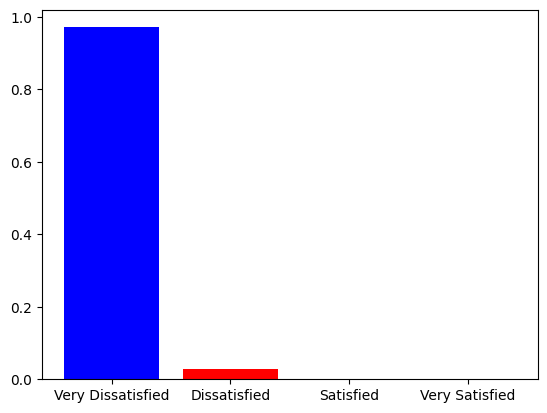

[0, 0, 1, 0]


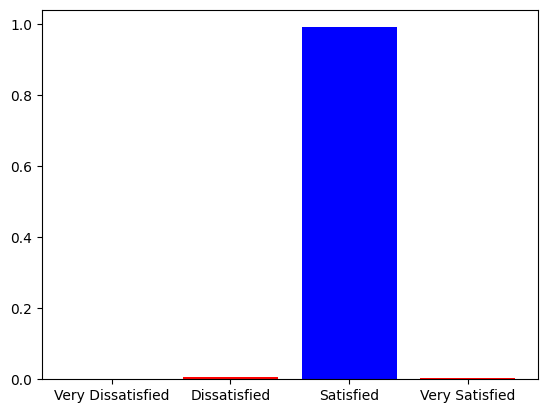

[0, 0, 0, 1]


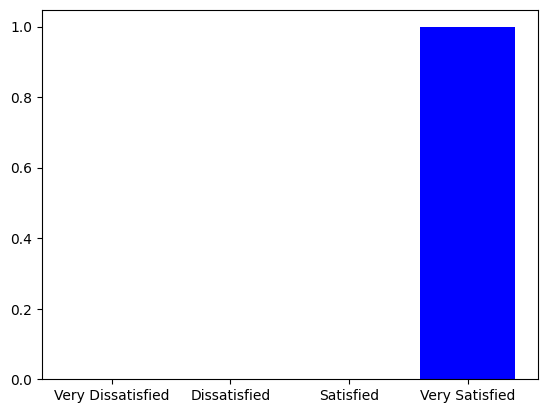

[0, 1, 0, 0]


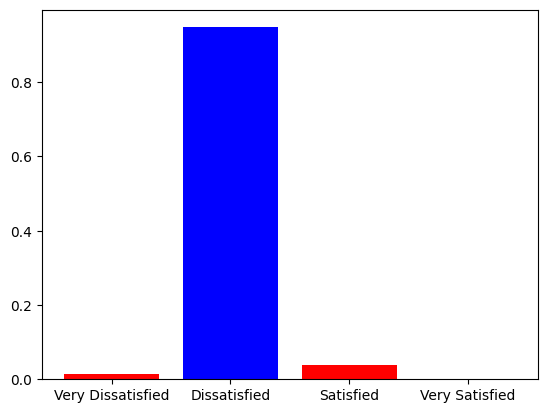

[0, 0, 1, 0]


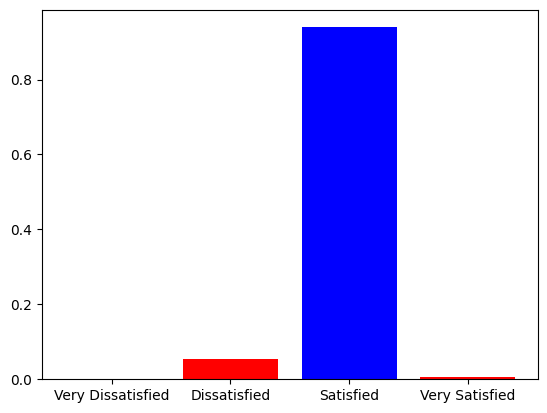

[0, 1, 0, 0]


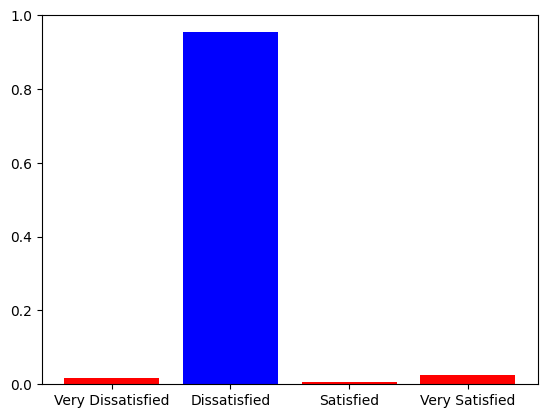

[0, 1, 0, 0]


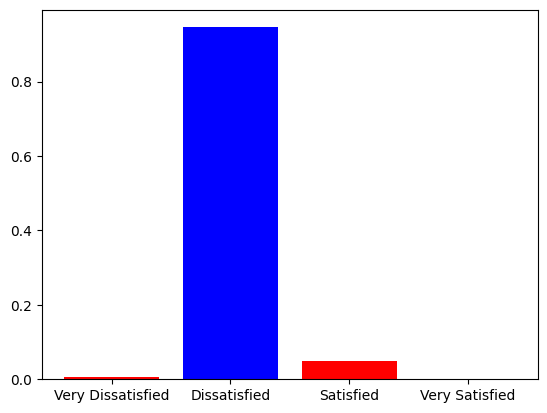

[0, 0, 0, 1]


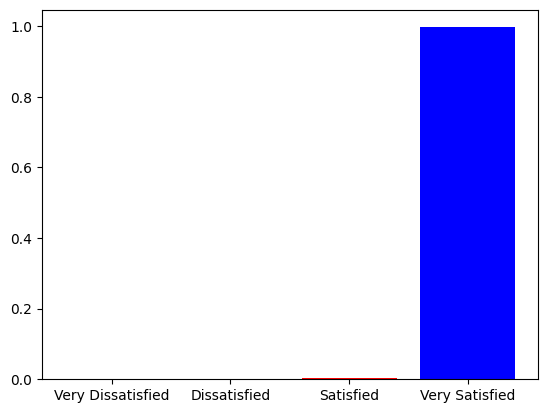

[0, 0, 0, 1]


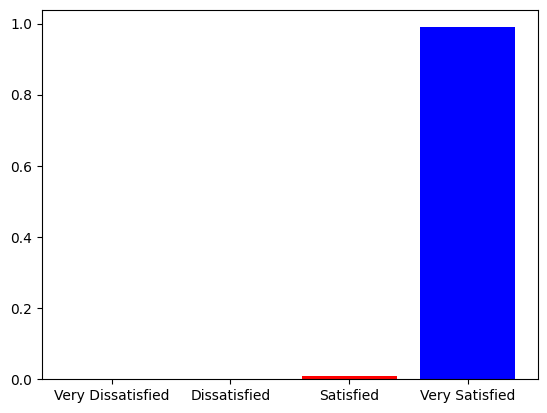

[0, 0, 0, 1]


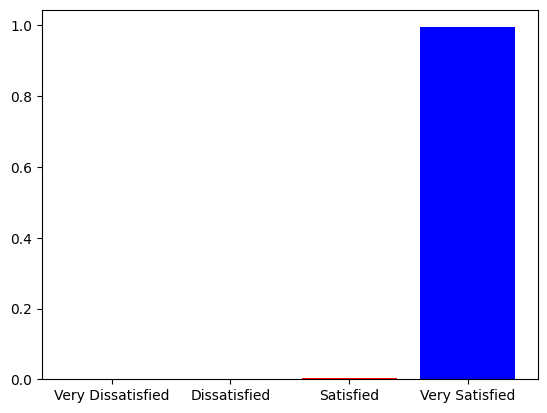

[0, 0, 1, 0]


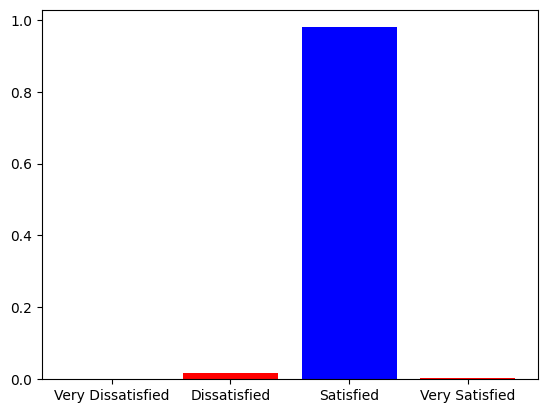

[0, 1, 0, 0]


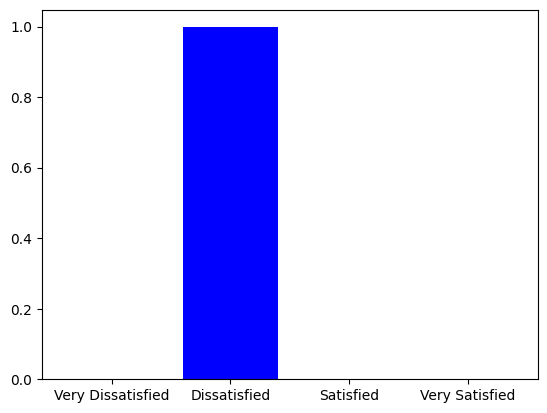

[0, 0, 1, 0]


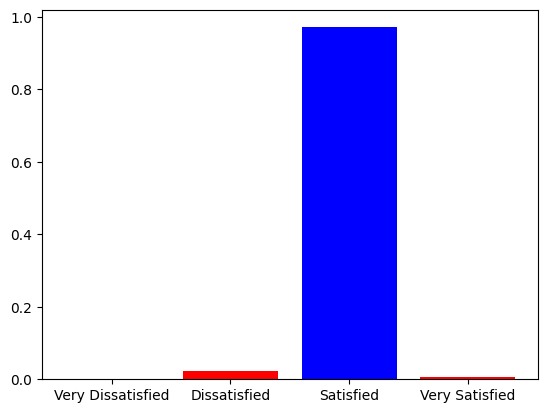

[0, 1, 0, 0]


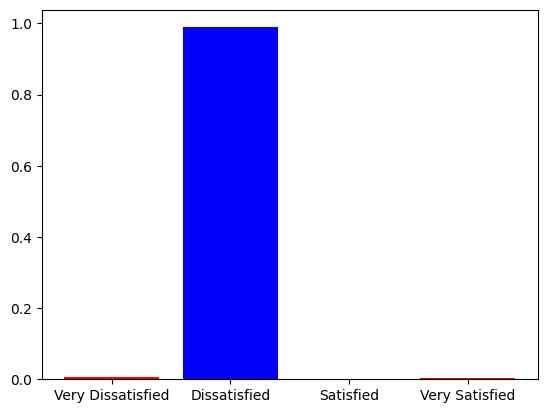

[0, 1, 0, 0]


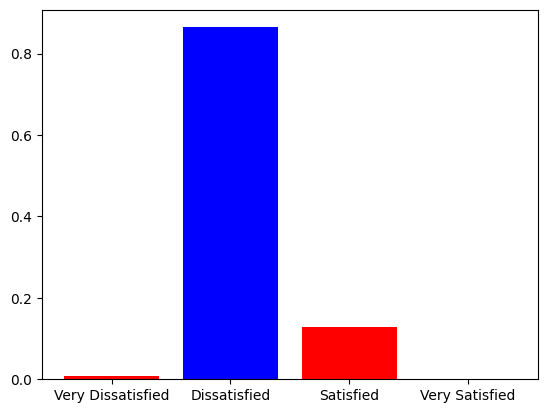

[1, 0, 0, 0]


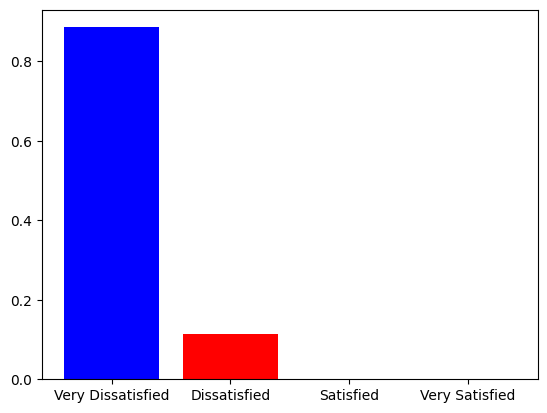

[0, 1, 0, 0]


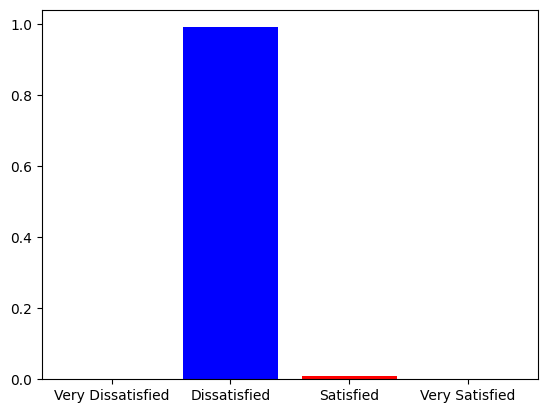

[0, 1, 0, 0]


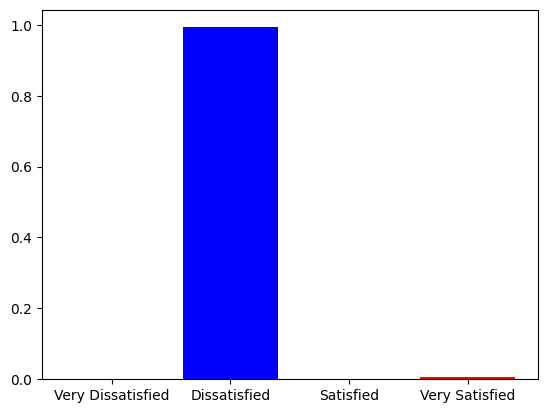

[0, 0, 1, 0]


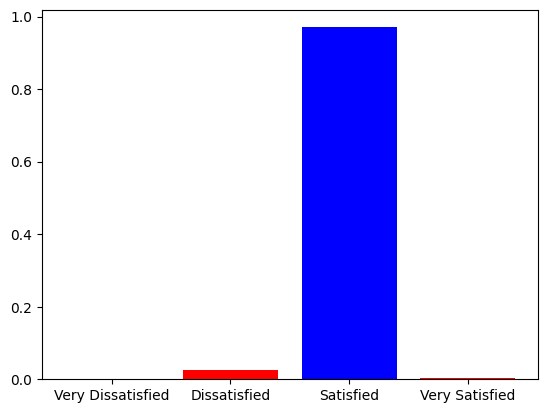

[0, 0, 1, 0]


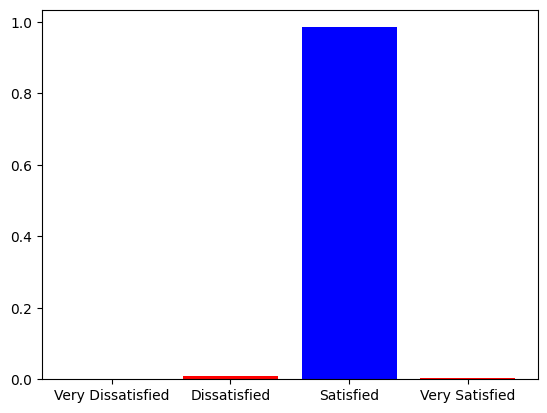

[0, 0, 0, 1]


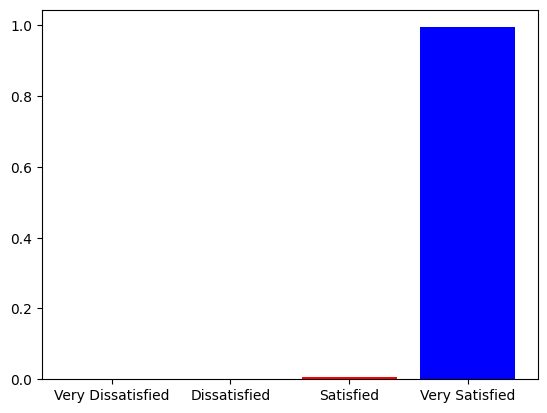

[0, 1, 0, 0]


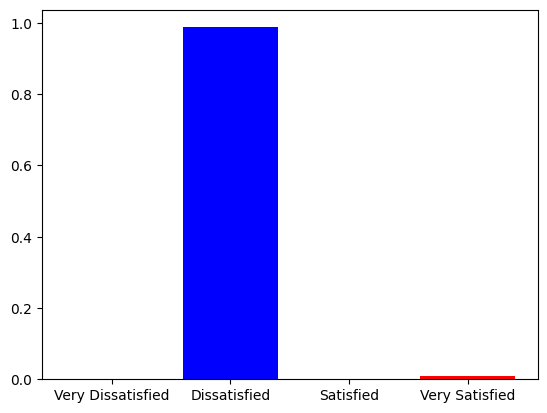

[0, 0, 1, 0]


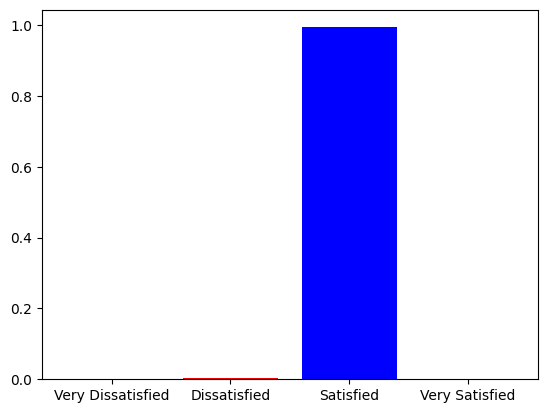

[0, 0, 1, 0]


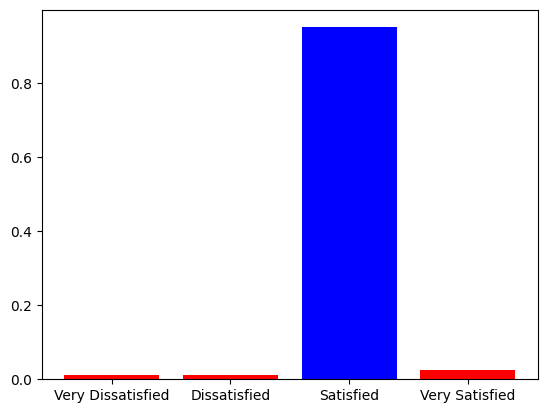

[0, 0, 1, 0]


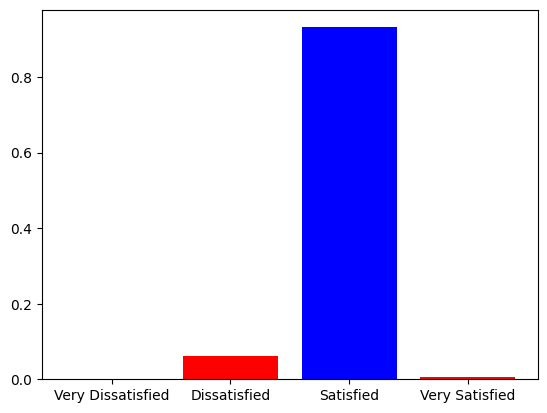

[0, 0, 0, 1]


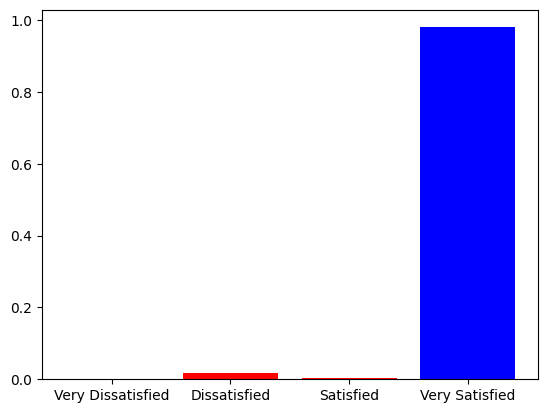

[0, 1, 0, 0]


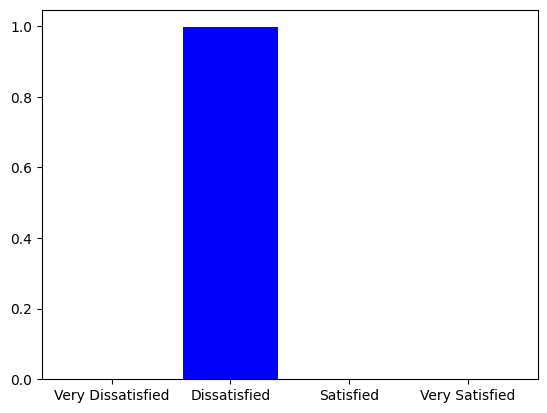

[0, 0, 1, 0]


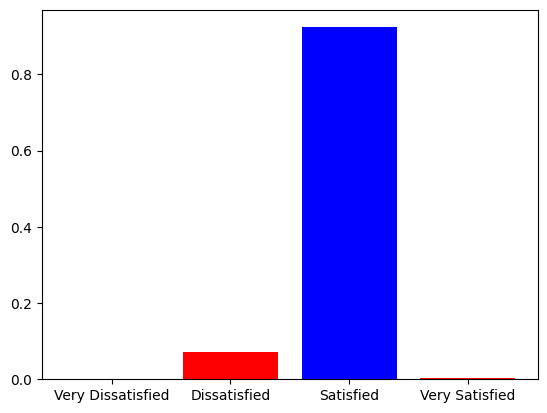

[0, 0, 1, 0]


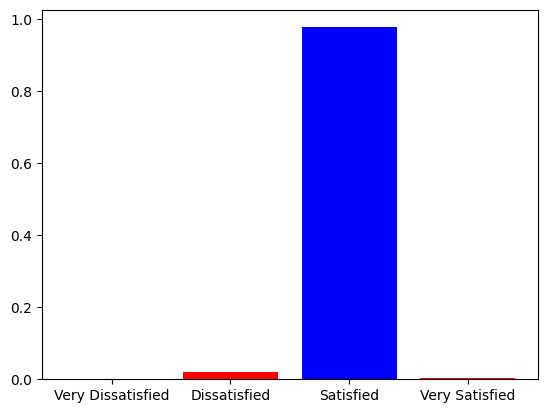

[0, 0, 0, 1]


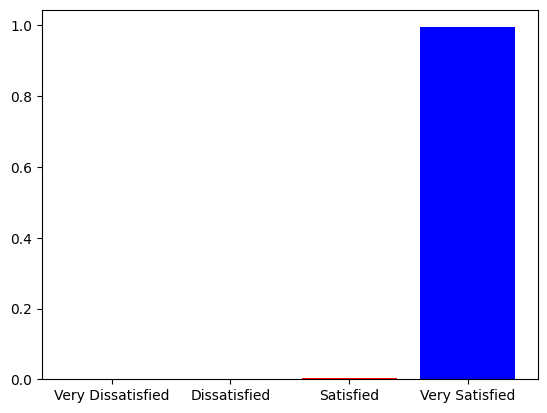

[1, 0, 0, 0]


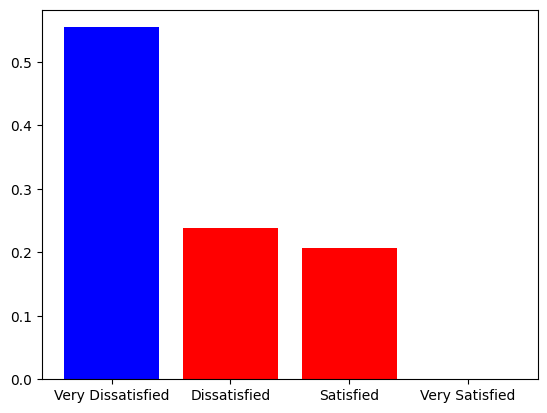

[0, 0, 1, 0]


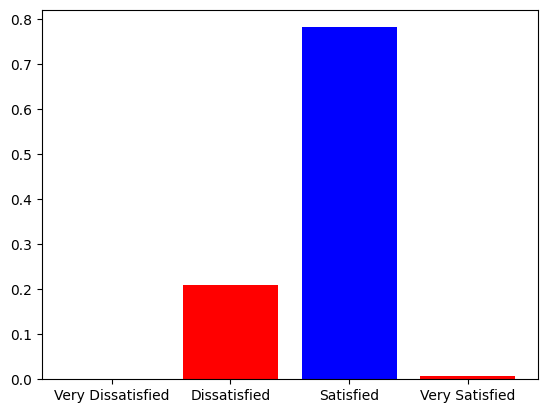

[0, 0, 0, 1]


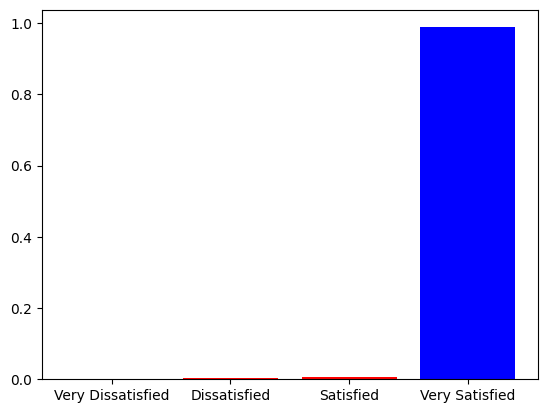

[0, 1, 0, 0]


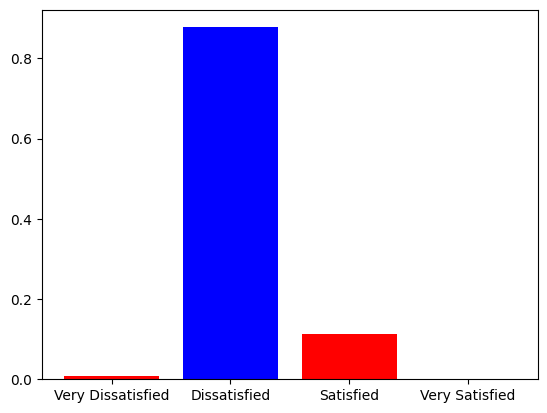

[0, 0, 1, 0]


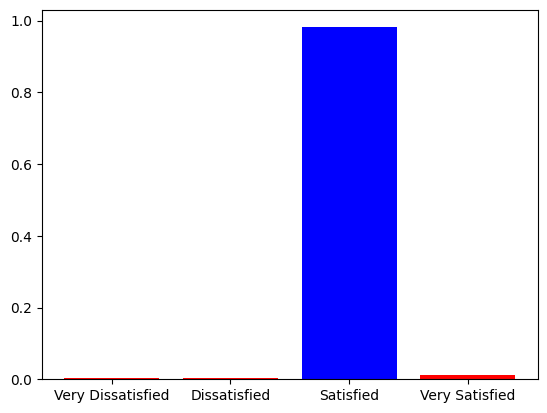

[0, 0, 0, 1]


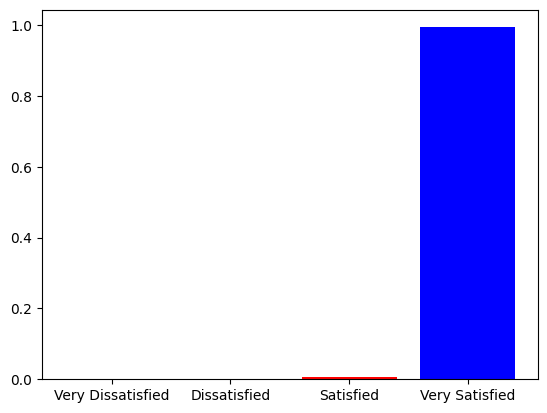

In [151]:
y_proba = shadow_model.predict(shadow_X_test).tolist()
for prob,label in zip(y_proba,shadow_y_test.to_numpy().tolist()):
  colors  = [("blue" if i==1 else "red") for i in label]
  print(label)
  plt.bar(list(shadow_dataset.columns)[-4:],prob,color=colors)
  plt.show()


#Attack Dataset
The hacker will train a shadow model from the shadow dataset, and, after training, the shadow model predict data points used the in training where its predicted distribution, correct label, and additional binary feature 'in' as 1 representing that the predicted distribution was from a data point that was in the training set. The same will be done with test set data points but the 'in' feature is 0.

In [152]:
"""
  Generate shadow data
"""
def generate_attack_dataset(num_shadow_models,shadow_dataset_X,shadow_dataset_y):

  with open(file_dir + "attack_dataset.csv",'w',newline='') as csvfile:
    writer = csv.writer(csvfile)
    headers = [f"target_{col}" for col in list(shadow_dataset_y.columns)] + [f"label_{col}" for col in list(shadow_dataset_y.columns)] + ["in"]
    writer.writerow(headers)
    pbar = tqdm(range(100))
    for model in range(num_shadow_models):

      shadow_X_train, shadow_X_test, shadow_y_train, shadow_y_test = train_test_split(shadow_X,shadow_y,train_size=100,test_size=82,shuffle=True)
      shadow_model, _ = train_shadow_model(shadow_X_train,shadow_y_train,shadow_X_test,shadow_y_test)

      # Add input we know the shadow model was trained on.
      for i in range(len(shadow_X_train)):
        input = shadow_X_train.iloc[i].to_numpy().reshape((1,17))
        shadow_output = shadow_model.call(input).numpy().tolist()[0]
        input = input.tolist()[0]
        label = shadow_y_train.iloc[i].to_numpy().reshape((1,4)).tolist()[0]
        in_dataset = [1.0]
        row = shadow_output + label + in_dataset
        writer.writerow(row)

      # Add input we know the shadow model wasn't trained on.
      for i in range(len(shadow_X_test)):
        input = shadow_X_test.iloc[i].to_numpy().reshape((1,17))
        shadow_output = shadow_model.call(input).numpy().tolist()[0]
        input = input.tolist()[0]
        label = shadow_y_test.iloc[i].to_numpy().reshape((1,4)).tolist()[0]
        out_dataset = [0.0]
        row = shadow_output + label + out_dataset
        writer.writerow(row)

      pbar.update(100/num_shadow_models)




In [153]:
"""
=====================      WAIT!!!      ========================================

This function takes a LONG to run. If you haven't changed previous the .csv
files, then check if you have 'attack_dataset.csv' already before running this.
Go down  to the cell below this one to retrieve the dataset from your file
directory.
================================================================================
"""
shadow_X, shadow_y = shadow_dataset.drop(['Very Dissatisfied', 'Dissatisfied', 'Satisfied', 'Very Satisfied'],axis=1), shadow_dataset[['Very Dissatisfied', 'Dissatisfied', 'Satisfied', 'Very Satisfied']]
generate_attack_dataset(100,shadow_X,shadow_y)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - categorical_crossentropy: 1.7028 - loss: 1.7028 - val_categorical_crossentropy: 1.3052 - val_loss: 1.3052
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.3731 - loss: 1.3731 - val_categorical_crossentropy: 1.2984 - val_loss: 1.2984
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.2606 - loss: 1.2606 - val_categorical_crossentropy: 1.3717 - val_loss: 1.3717
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - categorical_crossentropy: 1.2396 - loss: 1.2396 - val_categorical_crossentropy: 1.4398 - val_loss: 1.4398
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.2416 - loss: 1.2416 - val_categorical_crossentropy: 1.4633 - val_loss: 1.4633
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2249 - loss: 1.2249 - val_categorical_crossentropy: 1.4374 - val_loss: 1.4374
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorica

  1%|          | 1.0/100 [00:16<27:26, 16.63s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - categorical_crossentropy: 1.3797 - loss: 1.3797 - val_categorical_crossentropy: 1.2680 - val_loss: 1.2680
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.3171 - loss: 1.3171 - val_categorical_crossentropy: 1.2145 - val_loss: 1.2145
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.2517 - loss: 1.2517 - val_categorical_crossentropy: 1.1727 - val_loss: 1.1727
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2112 - loss: 1.2112 - val_categorical_crossentropy: 1.1326 - val_loss: 1.1326
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.1425 - loss: 1.1425 - val_categorical_crossentropy: 1.0947 - val_loss: 1.0947
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.0840 - loss: 1.0840 - val_categorical_crossentropy: 1.0559 - val_loss: 1.0559
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical

  2%|▏         | 2.0/100 [00:32<26:28, 16.21s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - categorical_crossentropy: 1.4856 - loss: 1.4856 - val_categorical_crossentropy: 1.3360 - val_loss: 1.3360
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.3169 - loss: 1.3169 - val_categorical_crossentropy: 1.2499 - val_loss: 1.2499
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.2467 - loss: 1.2467 - val_categorical_crossentropy: 1.2261 - val_loss: 1.2261
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.2222 - loss: 1.2222 - val_categorical_crossentropy: 1.1978 - val_loss: 1.1978
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - categorical_crossentropy: 1.1711 - loss: 1.1711 - val_categorical_crossentropy: 1.1566 - val_loss: 1.1566
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - categorical_crossentropy: 1.1168 - loss: 1.1168 - val_categorical_crossentropy: 1.1122 - val_loss: 1.1122
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - categoric

  3%|▎         | 3.0/100 [00:49<26:51, 16.62s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - categorical_crossentropy: 1.5043 - loss: 1.5043 - val_categorical_crossentropy: 1.3457 - val_loss: 1.3457
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.3160 - loss: 1.3160 - val_categorical_crossentropy: 1.3558 - val_loss: 1.3558
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2802 - loss: 1.2802 - val_categorical_crossentropy: 1.3372 - val_loss: 1.3372
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.2385 - loss: 1.2385 - val_categorical_crossentropy: 1.2951 - val_loss: 1.2951
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.1815 - loss: 1.1815 - val_categorical_crossentropy: 1.2339 - val_loss: 1.2339
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.1297 - loss: 1.1297 - val_categorical_crossentropy: 1.1688 - val_loss: 1.1688
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical

  4%|▍         | 4.0/100 [01:05<26:21, 16.48s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - categorical_crossentropy: 1.4118 - loss: 1.4118 - val_categorical_crossentropy: 1.3367 - val_loss: 1.3367
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.2808 - loss: 1.2808 - val_categorical_crossentropy: 1.3130 - val_loss: 1.3130
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2282 - loss: 1.2282 - val_categorical_crossentropy: 1.2994 - val_loss: 1.2994
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.1737 - loss: 1.1737 - val_categorical_crossentropy: 1.2737 - val_loss: 1.2737
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_crossentropy: 1.1297 - loss: 1.1297 - val_categorical_crossentropy: 1.2343 - val_loss: 1.2343
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.0932 - loss: 1.0932 - val_categorical_crossentropy: 1.1883 - val_loss: 1.1883
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical

  5%|▌         | 5.0/100 [01:21<25:42, 16.24s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - categorical_crossentropy: 1.5238 - loss: 1.5238 - val_categorical_crossentropy: 1.3800 - val_loss: 1.3800
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.3029 - loss: 1.3029 - val_categorical_crossentropy: 1.3031 - val_loss: 1.3031
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.2638 - loss: 1.2638 - val_categorical_crossentropy: 1.2596 - val_loss: 1.2596
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.2329 - loss: 1.2329 - val_categorical_crossentropy: 1.2196 - val_loss: 1.2196
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.1928 - loss: 1.1928 - val_categorical_crossentropy: 1.1770 - val_loss: 1.1770
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.1230 - loss: 1.1230 - val_categorical_crossentropy: 1.1369 - val_loss: 1.1369
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical

  6%|▌         | 6.0/100 [01:37<25:17, 16.14s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - categorical_crossentropy: 1.5072 - loss: 1.5072 - val_categorical_crossentropy: 1.3890 - val_loss: 1.3890
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_crossentropy: 1.3125 - loss: 1.3125 - val_categorical_crossentropy: 1.2704 - val_loss: 1.2704
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.2509 - loss: 1.2509 - val_categorical_crossentropy: 1.2246 - val_loss: 1.2246
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.2381 - loss: 1.2381 - val_categorical_crossentropy: 1.2001 - val_loss: 1.2001
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2275 - loss: 1.2275 - val_categorical_crossentropy: 1.1658 - val_loss: 1.1658
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.1569 - loss: 1.1569 - val_categorical_crossentropy: 1.1301 - val_loss: 1.1301
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical

  7%|▋         | 7.0/100 [01:53<24:50, 16.03s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - categorical_crossentropy: 1.3401 - loss: 1.3401 - val_categorical_crossentropy: 1.3280 - val_loss: 1.3280
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - categorical_crossentropy: 1.2374 - loss: 1.2374 - val_categorical_crossentropy: 1.2933 - val_loss: 1.2933
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_crossentropy: 1.2095 - loss: 1.2095 - val_categorical_crossentropy: 1.2488 - val_loss: 1.2488
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categorical_crossentropy: 1.1649 - loss: 1.1649 - val_categorical_crossentropy: 1.2155 - val_loss: 1.2155
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - categorical_crossentropy: 1.1225 - loss: 1.1225 - val_categorical_crossentropy: 1.1807 - val_loss: 1.1807
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - categorical_crossentropy: 1.0853 - loss: 1.0853 - val_categorical_crossentropy: 1.1448 - val_loss: 1.1448
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - catego

  8%|▊         | 8.0/100 [02:09<24:35, 16.03s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - categorical_crossentropy: 1.2864 - loss: 1.2864 - val_categorical_crossentropy: 1.2539 - val_loss: 1.2539
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_crossentropy: 1.2265 - loss: 1.2265 - val_categorical_crossentropy: 1.1970 - val_loss: 1.1970
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.1627 - loss: 1.1627 - val_categorical_crossentropy: 1.1647 - val_loss: 1.1647
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_crossentropy: 1.1162 - loss: 1.1162 - val_categorical_crossentropy: 1.1351 - val_loss: 1.1351
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_crossentropy: 1.0764 - loss: 1.0764 - val_categorical_crossentropy: 1.1098 - val_loss: 1.1098
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.0229 - loss: 1.0229 - val_categorical_crossentropy: 1.0730 - val_loss: 1.0730
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical

  9%|▉         | 9.0/100 [02:26<24:37, 16.23s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - categorical_crossentropy: 1.7540 - loss: 1.7540 - val_categorical_crossentropy: 1.5442 - val_loss: 1.5442
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_crossentropy: 1.4560 - loss: 1.4560 - val_categorical_crossentropy: 1.3987 - val_loss: 1.3987
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.2895 - loss: 1.2895 - val_categorical_crossentropy: 1.3168 - val_loss: 1.3168
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.2079 - loss: 1.2079 - val_categorical_crossentropy: 1.2650 - val_loss: 1.2650
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.1367 - loss: 1.1367 - val_categorical_crossentropy: 1.2430 - val_loss: 1.2430
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_crossentropy: 1.0835 - loss: 1.0835 - val_categorical_crossentropy: 1.2277 - val_loss: 1.2277
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical

 10%|█         | 10.0/100 [02:43<24:45, 16.50s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - categorical_crossentropy: 1.3186 - loss: 1.3186 - val_categorical_crossentropy: 1.2744 - val_loss: 1.2744
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.2343 - loss: 1.2343 - val_categorical_crossentropy: 1.2094 - val_loss: 1.2094
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.1848 - loss: 1.1848 - val_categorical_crossentropy: 1.1706 - val_loss: 1.1706
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.1347 - loss: 1.1347 - val_categorical_crossentropy: 1.1374 - val_loss: 1.1374
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_crossentropy: 1.0752 - loss: 1.0752 - val_categorical_crossentropy: 1.1075 - val_loss: 1.1075
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.0090 - loss: 1.0090 - val_categorical_crossentropy: 1.0802 - val_loss: 1.0802
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical

 11%|█         | 11.0/100 [02:59<24:13, 16.33s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - categorical_crossentropy: 1.4143 - loss: 1.4143 - val_categorical_crossentropy: 1.3701 - val_loss: 1.3701
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.2946 - loss: 1.2946 - val_categorical_crossentropy: 1.3681 - val_loss: 1.3681
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.2477 - loss: 1.2477 - val_categorical_crossentropy: 1.3575 - val_loss: 1.3575
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2017 - loss: 1.2017 - val_categorical_crossentropy: 1.3110 - val_loss: 1.3110
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_crossentropy: 1.1760 - loss: 1.1760 - val_categorical_crossentropy: 1.2552 - val_loss: 1.2552
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.1102 - loss: 1.1102 - val_categorical_crossentropy: 1.2051 - val_loss: 1.2051
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical

 12%|█▏        | 12.0/100 [03:15<23:47, 16.22s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - categorical_crossentropy: 1.3782 - loss: 1.3782 - val_categorical_crossentropy: 1.2815 - val_loss: 1.2815
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - categorical_crossentropy: 1.3498 - loss: 1.3498 - val_categorical_crossentropy: 1.2550 - val_loss: 1.2550
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_crossentropy: 1.2876 - loss: 1.2876 - val_categorical_crossentropy: 1.2570 - val_loss: 1.2570
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categorical_crossentropy: 1.2363 - loss: 1.2363 - val_categorical_crossentropy: 1.2625 - val_loss: 1.2625
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categorical_crossentropy: 1.1805 - loss: 1.1805 - val_categorical_crossentropy: 1.2400 - val_loss: 1.2400
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - categorical_crossentropy: 1.1463 - loss: 1.1463 - val_categorical_crossentropy: 1.2051 - val_loss: 1.2051
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - catego

 13%|█▎        | 13.0/100 [03:32<23:53, 16.48s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - categorical_crossentropy: 1.5072 - loss: 1.5072 - val_categorical_crossentropy: 1.3498 - val_loss: 1.3498
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_crossentropy: 1.3525 - loss: 1.3525 - val_categorical_crossentropy: 1.3019 - val_loss: 1.3019
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2946 - loss: 1.2946 - val_categorical_crossentropy: 1.2796 - val_loss: 1.2796
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.2477 - loss: 1.2477 - val_categorical_crossentropy: 1.2471 - val_loss: 1.2471
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categorical_crossentropy: 1.2179 - loss: 1.2179 - val_categorical_crossentropy: 1.2043 - val_loss: 1.2043
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - categorical_crossentropy: 1.1598 - loss: 1.1598 - val_categorical_crossentropy: 1.1558 - val_loss: 1.1558
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categoric

 14%|█▍        | 14.0/100 [03:49<23:57, 16.71s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - categorical_crossentropy: 1.4325 - loss: 1.4325 - val_categorical_crossentropy: 1.3608 - val_loss: 1.3608
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_crossentropy: 1.3062 - loss: 1.3062 - val_categorical_crossentropy: 1.3711 - val_loss: 1.3711
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.2585 - loss: 1.2585 - val_categorical_crossentropy: 1.3573 - val_loss: 1.3573
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.2403 - loss: 1.2403 - val_categorical_crossentropy: 1.3050 - val_loss: 1.3050
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2286 - loss: 1.2286 - val_categorical_crossentropy: 1.2517 - val_loss: 1.2517
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - categorical_crossentropy: 1.1775 - loss: 1.1775 - val_categorical_crossentropy: 1.2102 - val_loss: 1.2102
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical

 15%|█▌        | 15.0/100 [04:05<23:16, 16.43s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - categorical_crossentropy: 1.4414 - loss: 1.4414 - val_categorical_crossentropy: 1.3697 - val_loss: 1.3697
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.3594 - loss: 1.3594 - val_categorical_crossentropy: 1.3018 - val_loss: 1.3018
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.3095 - loss: 1.3095 - val_categorical_crossentropy: 1.2786 - val_loss: 1.2786
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - categorical_crossentropy: 1.2733 - loss: 1.2733 - val_categorical_crossentropy: 1.2567 - val_loss: 1.2567
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.2352 - loss: 1.2352 - val_categorical_crossentropy: 1.2396 - val_loss: 1.2396
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.1752 - loss: 1.1752 - val_categorical_crossentropy: 1.2194 - val_loss: 1.2194
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorica

 16%|█▌        | 16.0/100 [04:21<22:54, 16.37s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - categorical_crossentropy: 1.2886 - loss: 1.2886 - val_categorical_crossentropy: 1.2780 - val_loss: 1.2780
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_crossentropy: 1.2211 - loss: 1.2211 - val_categorical_crossentropy: 1.2681 - val_loss: 1.2681
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.1792 - loss: 1.1792 - val_categorical_crossentropy: 1.2675 - val_loss: 1.2675
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_crossentropy: 1.1428 - loss: 1.1428 - val_categorical_crossentropy: 1.2419 - val_loss: 1.2419
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.0943 - loss: 1.0943 - val_categorical_crossentropy: 1.1951 - val_loss: 1.1951
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.0379 - loss: 1.0379 - val_categorical_crossentropy: 1.1401 - val_loss: 1.1401
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical

 17%|█▋        | 17.0/100 [04:37<22:37, 16.36s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - categorical_crossentropy: 1.8681 - loss: 1.8681 - val_categorical_crossentropy: 1.4129 - val_loss: 1.4129
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_crossentropy: 1.4760 - loss: 1.4760 - val_categorical_crossentropy: 1.3102 - val_loss: 1.3102
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - categorical_crossentropy: 1.2913 - loss: 1.2913 - val_categorical_crossentropy: 1.3192 - val_loss: 1.3192
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_crossentropy: 1.2317 - loss: 1.2317 - val_categorical_crossentropy: 1.3486 - val_loss: 1.3486
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - categorical_crossentropy: 1.2027 - loss: 1.2027 - val_categorical_crossentropy: 1.3370 - val_loss: 1.3370
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - categorical_crossentropy: 1.2066 - loss: 1.2066 - val_categorical_crossentropy: 1.3032 - val_loss: 1.3032
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - catego

 18%|█▊        | 18.0/100 [04:55<22:49, 16.70s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - categorical_crossentropy: 1.9320 - loss: 1.9320 - val_categorical_crossentropy: 1.5063 - val_loss: 1.5063
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_crossentropy: 1.5082 - loss: 1.5082 - val_categorical_crossentropy: 1.3444 - val_loss: 1.3444
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_crossentropy: 1.3284 - loss: 1.3284 - val_categorical_crossentropy: 1.2989 - val_loss: 1.2989
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.2679 - loss: 1.2679 - val_categorical_crossentropy: 1.2993 - val_loss: 1.2993
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2531 - loss: 1.2531 - val_categorical_crossentropy: 1.3021 - val_loss: 1.3021
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2206 - loss: 1.2206 - val_categorical_crossentropy: 1.2907 - val_loss: 1.2907
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical

 19%|█▉        | 19.0/100 [05:11<22:30, 16.67s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - categorical_crossentropy: 1.4462 - loss: 1.4462 - val_categorical_crossentropy: 1.3529 - val_loss: 1.3529
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.3276 - loss: 1.3276 - val_categorical_crossentropy: 1.3248 - val_loss: 1.3248
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.2835 - loss: 1.2835 - val_categorical_crossentropy: 1.3077 - val_loss: 1.3077
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2691 - loss: 1.2691 - val_categorical_crossentropy: 1.2826 - val_loss: 1.2826
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2237 - loss: 1.2237 - val_categorical_crossentropy: 1.2601 - val_loss: 1.2601
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.2021 - loss: 1.2021 - val_categorical_crossentropy: 1.2366 - val_loss: 1.2366
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - categorica

 20%|██        | 20.0/100 [05:28<22:05, 16.57s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - categorical_crossentropy: 1.4695 - loss: 1.4695 - val_categorical_crossentropy: 1.3087 - val_loss: 1.3087
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.3448 - loss: 1.3448 - val_categorical_crossentropy: 1.3352 - val_loss: 1.3352
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_crossentropy: 1.3137 - loss: 1.3137 - val_categorical_crossentropy: 1.3406 - val_loss: 1.3406
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - categorical_crossentropy: 1.2968 - loss: 1.2968 - val_categorical_crossentropy: 1.3238 - val_loss: 1.3238
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_crossentropy: 1.2410 - loss: 1.2410 - val_categorical_crossentropy: 1.2840 - val_loss: 1.2840
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.1841 - loss: 1.1841 - val_categorical_crossentropy: 1.2328 - val_loss: 1.2328
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorica

 21%|██        | 21.0/100 [05:45<21:54, 16.64s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - categorical_crossentropy: 1.3668 - loss: 1.3668 - val_categorical_crossentropy: 1.3036 - val_loss: 1.3036
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categorical_crossentropy: 1.2444 - loss: 1.2444 - val_categorical_crossentropy: 1.3234 - val_loss: 1.3234
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - categorical_crossentropy: 1.2183 - loss: 1.2183 - val_categorical_crossentropy: 1.2902 - val_loss: 1.2902
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_crossentropy: 1.1633 - loss: 1.1633 - val_categorical_crossentropy: 1.2254 - val_loss: 1.2254
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - categorical_crossentropy: 1.0980 - loss: 1.0980 - val_categorical_crossentropy: 1.1491 - val_loss: 1.1491
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - categorical_crossentropy: 1.0509 - loss: 1.0509 - val_categorical_crossentropy: 1.0854 - val_loss: 1.0854
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - categ

 22%|██▏       | 22.0/100 [06:04<22:46, 17.52s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - categorical_crossentropy: 1.4269 - loss: 1.4269 - val_categorical_crossentropy: 1.3233 - val_loss: 1.3233
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - categorical_crossentropy: 1.2889 - loss: 1.2889 - val_categorical_crossentropy: 1.2897 - val_loss: 1.2897
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2500 - loss: 1.2500 - val_categorical_crossentropy: 1.2653 - val_loss: 1.2653
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.2006 - loss: 1.2006 - val_categorical_crossentropy: 1.2468 - val_loss: 1.2468
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - categorical_crossentropy: 1.2003 - loss: 1.2003 - val_categorical_crossentropy: 1.2239 - val_loss: 1.2239
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.1609 - loss: 1.1609 - val_categorical_crossentropy: 1.1932 - val_loss: 1.1932
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categoric

 23%|██▎       | 23.0/100 [06:21<22:13, 17.32s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - categorical_crossentropy: 1.4955 - loss: 1.4955 - val_categorical_crossentropy: 1.3506 - val_loss: 1.3506
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.3168 - loss: 1.3168 - val_categorical_crossentropy: 1.3344 - val_loss: 1.3344
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.2817 - loss: 1.2817 - val_categorical_crossentropy: 1.3386 - val_loss: 1.3386
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.2673 - loss: 1.2673 - val_categorical_crossentropy: 1.2920 - val_loss: 1.2920
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_crossentropy: 1.2427 - loss: 1.2427 - val_categorical_crossentropy: 1.2254 - val_loss: 1.2254
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.1600 - loss: 1.1600 - val_categorical_crossentropy: 1.1728 - val_loss: 1.1728
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - categorica

 24%|██▍       | 24.0/100 [06:38<21:58, 17.35s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - categorical_crossentropy: 1.4203 - loss: 1.4203 - val_categorical_crossentropy: 1.3257 - val_loss: 1.3257
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_crossentropy: 1.2643 - loss: 1.2643 - val_categorical_crossentropy: 1.3794 - val_loss: 1.3794
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.2140 - loss: 1.2140 - val_categorical_crossentropy: 1.4016 - val_loss: 1.4016
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - categorical_crossentropy: 1.1829 - loss: 1.1829 - val_categorical_crossentropy: 1.3466 - val_loss: 1.3466
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - categorical_crossentropy: 1.1088 - loss: 1.1088 - val_categorical_crossentropy: 1.2606 - val_loss: 1.2606
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_crossentropy: 1.0726 - loss: 1.0726 - val_categorical_crossentropy: 1.1765 - val_loss: 1.1765
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - categ

 25%|██▌       | 25.0/100 [06:56<21:52, 17.49s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - categorical_crossentropy: 1.2731 - loss: 1.2731 - val_categorical_crossentropy: 1.3219 - val_loss: 1.3219
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.2469 - loss: 1.2469 - val_categorical_crossentropy: 1.2855 - val_loss: 1.2855
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.1844 - loss: 1.1844 - val_categorical_crossentropy: 1.2408 - val_loss: 1.2408
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.1417 - loss: 1.1417 - val_categorical_crossentropy: 1.1933 - val_loss: 1.1933
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_crossentropy: 1.0854 - loss: 1.0854 - val_categorical_crossentropy: 1.1430 - val_loss: 1.1430
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.0399 - loss: 1.0399 - val_categorical_crossentropy: 1.0930 - val_loss: 1.0930
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical

 26%|██▌       | 26.0/100 [07:14<21:35, 17.50s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - categorical_crossentropy: 1.2725 - loss: 1.2725 - val_categorical_crossentropy: 1.3087 - val_loss: 1.3087
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2375 - loss: 1.2375 - val_categorical_crossentropy: 1.2487 - val_loss: 1.2487
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.1642 - loss: 1.1642 - val_categorical_crossentropy: 1.1900 - val_loss: 1.1900
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - categorical_crossentropy: 1.1145 - loss: 1.1145 - val_categorical_crossentropy: 1.1456 - val_loss: 1.1456
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.0414 - loss: 1.0414 - val_categorical_crossentropy: 1.1065 - val_loss: 1.1065
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 0.9847 - loss: 0.9847 - val_categorical_crossentropy: 1.0578 - val_loss: 1.0578
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorica

 27%|██▋       | 27.0/100 [07:31<21:11, 17.42s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - categorical_crossentropy: 1.7601 - loss: 1.7601 - val_categorical_crossentropy: 1.3839 - val_loss: 1.3839
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_crossentropy: 1.4122 - loss: 1.4122 - val_categorical_crossentropy: 1.3016 - val_loss: 1.3016
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - categorical_crossentropy: 1.2891 - loss: 1.2891 - val_categorical_crossentropy: 1.3163 - val_loss: 1.3163
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - categorical_crossentropy: 1.2336 - loss: 1.2336 - val_categorical_crossentropy: 1.3419 - val_loss: 1.3419
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.2313 - loss: 1.2313 - val_categorical_crossentropy: 1.3321 - val_loss: 1.3321
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - categorical_crossentropy: 1.2158 - loss: 1.2158 - val_categorical_crossentropy: 1.2961 - val_loss: 1.2961
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categor

 28%|██▊       | 28.0/100 [07:50<21:23, 17.83s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - categorical_crossentropy: 1.6516 - loss: 1.6516 - val_categorical_crossentropy: 1.3604 - val_loss: 1.3604
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.3611 - loss: 1.3611 - val_categorical_crossentropy: 1.3144 - val_loss: 1.3144
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.2630 - loss: 1.2630 - val_categorical_crossentropy: 1.3288 - val_loss: 1.3288
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorical_crossentropy: 1.2423 - loss: 1.2423 - val_categorical_crossentropy: 1.3374 - val_loss: 1.3374
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.1782 - loss: 1.1782 - val_categorical_crossentropy: 1.3171 - val_loss: 1.3171
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.1904 - loss: 1.1904 - val_categorical_crossentropy: 1.2616 - val_loss: 1.2616
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical

 29%|██▉       | 29.0/100 [08:07<20:52, 17.63s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - categorical_crossentropy: 1.5532 - loss: 1.5532 - val_categorical_crossentropy: 1.5375 - val_loss: 1.5375
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.3789 - loss: 1.3789 - val_categorical_crossentropy: 1.3090 - val_loss: 1.3090
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2177 - loss: 1.2177 - val_categorical_crossentropy: 1.1925 - val_loss: 1.1925
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.1712 - loss: 1.1712 - val_categorical_crossentropy: 1.1369 - val_loss: 1.1369
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.1471 - loss: 1.1471 - val_categorical_crossentropy: 1.0950 - val_loss: 1.0950
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.1056 - loss: 1.1056 - val_categorical_crossentropy: 1.0598 - val_loss: 1.0598
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical

 30%|███       | 30.0/100 [08:25<20:37, 17.68s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - categorical_crossentropy: 1.5041 - loss: 1.5041 - val_categorical_crossentropy: 1.3255 - val_loss: 1.3255
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.2874 - loss: 1.2874 - val_categorical_crossentropy: 1.3051 - val_loss: 1.3051
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - categorical_crossentropy: 1.2583 - loss: 1.2583 - val_categorical_crossentropy: 1.3170 - val_loss: 1.3170
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_crossentropy: 1.2504 - loss: 1.2504 - val_categorical_crossentropy: 1.2722 - val_loss: 1.2722
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - categorical_crossentropy: 1.2132 - loss: 1.2132 - val_categorical_crossentropy: 1.2057 - val_loss: 1.2057
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - categorical_crossentropy: 1.1353 - loss: 1.1353 - val_categorical_crossentropy: 1.1492 - val_loss: 1.1492
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - catego

 31%|███       | 31.0/100 [08:43<20:37, 17.93s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - categorical_crossentropy: 1.3497 - loss: 1.3497 - val_categorical_crossentropy: 1.3205 - val_loss: 1.3205
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - categorical_crossentropy: 1.2707 - loss: 1.2707 - val_categorical_crossentropy: 1.3542 - val_loss: 1.3542
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2382 - loss: 1.2382 - val_categorical_crossentropy: 1.3090 - val_loss: 1.3090
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_crossentropy: 1.2116 - loss: 1.2116 - val_categorical_crossentropy: 1.2545 - val_loss: 1.2545
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_crossentropy: 1.1494 - loss: 1.1494 - val_categorical_crossentropy: 1.2206 - val_loss: 1.2206
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.0960 - loss: 1.0960 - val_categorical_crossentropy: 1.1866 - val_loss: 1.1866
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categoric

 32%|███▏      | 32.0/100 [09:00<19:58, 17.62s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - categorical_crossentropy: 1.4304 - loss: 1.4304 - val_categorical_crossentropy: 1.3286 - val_loss: 1.3286
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.3304 - loss: 1.3304 - val_categorical_crossentropy: 1.3302 - val_loss: 1.3302
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.3075 - loss: 1.3075 - val_categorical_crossentropy: 1.2996 - val_loss: 1.2996
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_crossentropy: 1.2570 - loss: 1.2570 - val_categorical_crossentropy: 1.2560 - val_loss: 1.2560
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.2113 - loss: 1.2113 - val_categorical_crossentropy: 1.2238 - val_loss: 1.2238
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.1515 - loss: 1.1515 - val_categorical_crossentropy: 1.1922 - val_loss: 1.1922
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical

 33%|███▎      | 33.0/100 [09:18<19:35, 17.55s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - categorical_crossentropy: 1.3851 - loss: 1.3851 - val_categorical_crossentropy: 1.2909 - val_loss: 1.2909
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - categorical_crossentropy: 1.3208 - loss: 1.3208 - val_categorical_crossentropy: 1.2529 - val_loss: 1.2529
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - categorical_crossentropy: 1.2778 - loss: 1.2778 - val_categorical_crossentropy: 1.2264 - val_loss: 1.2264
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - categorical_crossentropy: 1.2093 - loss: 1.2093 - val_categorical_crossentropy: 1.1994 - val_loss: 1.1994
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - categorical_crossentropy: 1.1672 - loss: 1.1672 - val_categorical_crossentropy: 1.1764 - val_loss: 1.1764
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - categorical_crossentropy: 1.0857 - loss: 1.0857 - val_categorical_crossentropy: 1.1459 - val_loss: 1.1459
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - categ

 34%|███▍      | 34.0/100 [09:43<21:47, 19.81s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - categorical_crossentropy: 1.6902 - loss: 1.6902 - val_categorical_crossentropy: 1.4017 - val_loss: 1.4017
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_crossentropy: 1.4178 - loss: 1.4178 - val_categorical_crossentropy: 1.2852 - val_loss: 1.2852
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.2542 - loss: 1.2542 - val_categorical_crossentropy: 1.2672 - val_loss: 1.2672
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - categorical_crossentropy: 1.2158 - loss: 1.2158 - val_categorical_crossentropy: 1.2934 - val_loss: 1.2934
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical_crossentropy: 1.2184 - loss: 1.2184 - val_categorical_crossentropy: 1.2737 - val_loss: 1.2737
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.1822 - loss: 1.1822 - val_categorical_crossentropy: 1.2156 - val_loss: 1.2156
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - categoric

 35%|███▌      | 35.0/100 [10:01<21:01, 19.40s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - categorical_crossentropy: 1.5481 - loss: 1.5481 - val_categorical_crossentropy: 1.3140 - val_loss: 1.3140
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - categorical_crossentropy: 1.2898 - loss: 1.2898 - val_categorical_crossentropy: 1.2944 - val_loss: 1.2944
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.2010 - loss: 1.2010 - val_categorical_crossentropy: 1.3444 - val_loss: 1.3444
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - categorical_crossentropy: 1.1831 - loss: 1.1831 - val_categorical_crossentropy: 1.3648 - val_loss: 1.3648
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.1629 - loss: 1.1629 - val_categorical_crossentropy: 1.3306 - val_loss: 1.3306
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - categorical_crossentropy: 1.0829 - loss: 1.0829 - val_categorical_crossentropy: 1.2632 - val_loss: 1.2632
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categ

 36%|███▌      | 36.0/100 [10:20<20:41, 19.40s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - categorical_crossentropy: 1.7523 - loss: 1.7523 - val_categorical_crossentropy: 1.4289 - val_loss: 1.4289
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_crossentropy: 1.4733 - loss: 1.4733 - val_categorical_crossentropy: 1.2780 - val_loss: 1.2780
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.3079 - loss: 1.3079 - val_categorical_crossentropy: 1.2250 - val_loss: 1.2250
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical_crossentropy: 1.2323 - loss: 1.2323 - val_categorical_crossentropy: 1.2403 - val_loss: 1.2403
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.2126 - loss: 1.2126 - val_categorical_crossentropy: 1.2754 - val_loss: 1.2754
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2026 - loss: 1.2026 - val_categorical_crossentropy: 1.2774 - val_loss: 1.2774
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical

 37%|███▋      | 37.0/100 [10:38<19:52, 18.93s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - categorical_crossentropy: 1.3322 - loss: 1.3322 - val_categorical_crossentropy: 1.3519 - val_loss: 1.3519
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_crossentropy: 1.2561 - loss: 1.2561 - val_categorical_crossentropy: 1.3502 - val_loss: 1.3502
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_crossentropy: 1.2322 - loss: 1.2322 - val_categorical_crossentropy: 1.3249 - val_loss: 1.3249
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.1555 - loss: 1.1555 - val_categorical_crossentropy: 1.2806 - val_loss: 1.2806
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.1255 - loss: 1.1255 - val_categorical_crossentropy: 1.2190 - val_loss: 1.2190
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.0694 - loss: 1.0694 - val_categorical_crossentropy: 1.1565 - val_loss: 1.1565
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - categorica

 38%|███▊      | 38.0/100 [10:56<19:16, 18.65s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - categorical_crossentropy: 1.7472 - loss: 1.7472 - val_categorical_crossentropy: 1.3699 - val_loss: 1.3699
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_crossentropy: 1.4109 - loss: 1.4109 - val_categorical_crossentropy: 1.3394 - val_loss: 1.3394
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_crossentropy: 1.2703 - loss: 1.2703 - val_categorical_crossentropy: 1.3473 - val_loss: 1.3473
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - categorical_crossentropy: 1.2238 - loss: 1.2238 - val_categorical_crossentropy: 1.3680 - val_loss: 1.3680
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_crossentropy: 1.1966 - loss: 1.1966 - val_categorical_crossentropy: 1.3691 - val_loss: 1.3691
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - categorical_crossentropy: 1.1660 - loss: 1.1660 - val_categorical_crossentropy: 1.3326 - val_loss: 1.3326
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - catego

 39%|███▉      | 39.0/100 [11:16<19:12, 18.90s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - categorical_crossentropy: 1.4658 - loss: 1.4658 - val_categorical_crossentropy: 1.3273 - val_loss: 1.3273
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2360 - loss: 1.2360 - val_categorical_crossentropy: 1.3403 - val_loss: 1.3403
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.1865 - loss: 1.1865 - val_categorical_crossentropy: 1.3645 - val_loss: 1.3645
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.1368 - loss: 1.1368 - val_categorical_crossentropy: 1.3406 - val_loss: 1.3406
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.1444 - loss: 1.1444 - val_categorical_crossentropy: 1.2744 - val_loss: 1.2744
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.0544 - loss: 1.0544 - val_categorical_crossentropy: 1.2103 - val_loss: 1.2103
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical

 40%|████      | 40.0/100 [11:34<18:39, 18.66s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - categorical_crossentropy: 1.7775 - loss: 1.7775 - val_categorical_crossentropy: 1.4262 - val_loss: 1.4262
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.4105 - loss: 1.4105 - val_categorical_crossentropy: 1.3762 - val_loss: 1.3762
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.2973 - loss: 1.2973 - val_categorical_crossentropy: 1.4268 - val_loss: 1.4268
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.2590 - loss: 1.2590 - val_categorical_crossentropy: 1.4644 - val_loss: 1.4644
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.2512 - loss: 1.2512 - val_categorical_crossentropy: 1.4534 - val_loss: 1.4534
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.2027 - loss: 1.2027 - val_categorical_crossentropy: 1.4288 - val_loss: 1.4288
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categorica

 41%|████      | 41.0/100 [11:53<18:26, 18.76s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - categorical_crossentropy: 1.6414 - loss: 1.6414 - val_categorical_crossentropy: 1.4146 - val_loss: 1.4146
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.3992 - loss: 1.3992 - val_categorical_crossentropy: 1.3048 - val_loss: 1.3048
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - categorical_crossentropy: 1.3140 - loss: 1.3140 - val_categorical_crossentropy: 1.2828 - val_loss: 1.2828
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2919 - loss: 1.2919 - val_categorical_crossentropy: 1.2411 - val_loss: 1.2411
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2570 - loss: 1.2570 - val_categorical_crossentropy: 1.1842 - val_loss: 1.1842
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2008 - loss: 1.2008 - val_categorical_crossentropy: 1.1308 - val_loss: 1.1308
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorica

 42%|████▏     | 42.0/100 [12:12<18:07, 18.75s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - categorical_crossentropy: 1.5962 - loss: 1.5962 - val_categorical_crossentropy: 1.4637 - val_loss: 1.4637
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.3231 - loss: 1.3231 - val_categorical_crossentropy: 1.3411 - val_loss: 1.3411
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.2486 - loss: 1.2486 - val_categorical_crossentropy: 1.2959 - val_loss: 1.2959
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.2192 - loss: 1.2192 - val_categorical_crossentropy: 1.2634 - val_loss: 1.2634
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2096 - loss: 1.2096 - val_categorical_crossentropy: 1.2236 - val_loss: 1.2236
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.1606 - loss: 1.1606 - val_categorical_crossentropy: 1.1927 - val_loss: 1.1927
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical

 43%|████▎     | 43.0/100 [12:29<17:28, 18.40s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - categorical_crossentropy: 1.4106 - loss: 1.4106 - val_categorical_crossentropy: 1.2966 - val_loss: 1.2966
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.2568 - loss: 1.2568 - val_categorical_crossentropy: 1.2691 - val_loss: 1.2691
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - categorical_crossentropy: 1.1824 - loss: 1.1824 - val_categorical_crossentropy: 1.2610 - val_loss: 1.2610
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.1200 - loss: 1.1200 - val_categorical_crossentropy: 1.2472 - val_loss: 1.2472
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.0899 - loss: 1.0899 - val_categorical_crossentropy: 1.2175 - val_loss: 1.2175
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.0388 - loss: 1.0388 - val_categorical_crossentropy: 1.1806 - val_loss: 1.1806
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical

 44%|████▍     | 44.0/100 [12:49<17:28, 18.73s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - categorical_crossentropy: 1.4999 - loss: 1.4999 - val_categorical_crossentropy: 1.3391 - val_loss: 1.3391
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.3193 - loss: 1.3193 - val_categorical_crossentropy: 1.3284 - val_loss: 1.3284
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - categorical_crossentropy: 1.2600 - loss: 1.2600 - val_categorical_crossentropy: 1.3478 - val_loss: 1.3478
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - categorical_crossentropy: 1.2307 - loss: 1.2307 - val_categorical_crossentropy: 1.3190 - val_loss: 1.3190
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_crossentropy: 1.1955 - loss: 1.1955 - val_categorical_crossentropy: 1.2625 - val_loss: 1.2625
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_crossentropy: 1.1436 - loss: 1.1436 - val_categorical_crossentropy: 1.2103 - val_loss: 1.2103
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - categor

 45%|████▌     | 45.0/100 [13:08<17:24, 19.00s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - categorical_crossentropy: 1.5415 - loss: 1.5415 - val_categorical_crossentropy: 1.2890 - val_loss: 1.2890
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.3130 - loss: 1.3130 - val_categorical_crossentropy: 1.2714 - val_loss: 1.2714
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.2441 - loss: 1.2441 - val_categorical_crossentropy: 1.3005 - val_loss: 1.3005
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - categorical_crossentropy: 1.2278 - loss: 1.2278 - val_categorical_crossentropy: 1.2865 - val_loss: 1.2865
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.1914 - loss: 1.1914 - val_categorical_crossentropy: 1.2220 - val_loss: 1.2220
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.1504 - loss: 1.1504 - val_categorical_crossentropy: 1.1416 - val_loss: 1.1416
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical

 46%|████▌     | 46.0/100 [13:26<16:49, 18.70s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - categorical_crossentropy: 1.3343 - loss: 1.3343 - val_categorical_crossentropy: 1.2471 - val_loss: 1.2471
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_crossentropy: 1.2805 - loss: 1.2805 - val_categorical_crossentropy: 1.2406 - val_loss: 1.2406
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - categorical_crossentropy: 1.2252 - loss: 1.2252 - val_categorical_crossentropy: 1.2192 - val_loss: 1.2192
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categorical_crossentropy: 1.2002 - loss: 1.2002 - val_categorical_crossentropy: 1.1785 - val_loss: 1.1785
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - categorical_crossentropy: 1.1502 - loss: 1.1502 - val_categorical_crossentropy: 1.1317 - val_loss: 1.1317
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - categorical_crossentropy: 1.1084 - loss: 1.1084 - val_categorical_crossentropy: 1.0906 - val_loss: 1.0906
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categ

 47%|████▋     | 47.0/100 [13:45<16:37, 18.82s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - categorical_crossentropy: 1.5332 - loss: 1.5332 - val_categorical_crossentropy: 1.3668 - val_loss: 1.3668
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2982 - loss: 1.2982 - val_categorical_crossentropy: 1.3363 - val_loss: 1.3363
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorical_crossentropy: 1.2022 - loss: 1.2022 - val_categorical_crossentropy: 1.3376 - val_loss: 1.3376
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.1322 - loss: 1.1322 - val_categorical_crossentropy: 1.3441 - val_loss: 1.3441
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.1150 - loss: 1.1150 - val_categorical_crossentropy: 1.3309 - val_loss: 1.3309
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.0656 - loss: 1.0656 - val_categorical_crossentropy: 1.3126 - val_loss: 1.3126
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical

 48%|████▊     | 48.0/100 [14:04<16:08, 18.62s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - categorical_crossentropy: 1.3420 - loss: 1.3420 - val_categorical_crossentropy: 1.2971 - val_loss: 1.2971
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.2546 - loss: 1.2546 - val_categorical_crossentropy: 1.2939 - val_loss: 1.2939
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2153 - loss: 1.2153 - val_categorical_crossentropy: 1.2767 - val_loss: 1.2767
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.1773 - loss: 1.1773 - val_categorical_crossentropy: 1.2252 - val_loss: 1.2252
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.1187 - loss: 1.1187 - val_categorical_crossentropy: 1.1624 - val_loss: 1.1624
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.0503 - loss: 1.0503 - val_categorical_crossentropy: 1.1071 - val_loss: 1.1071
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical

 49%|████▉     | 49.0/100 [14:23<15:54, 18.72s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - categorical_crossentropy: 1.4316 - loss: 1.4316 - val_categorical_crossentropy: 1.3291 - val_loss: 1.3291
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - categorical_crossentropy: 1.3338 - loss: 1.3338 - val_categorical_crossentropy: 1.2955 - val_loss: 1.2955
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - categorical_crossentropy: 1.3010 - loss: 1.3010 - val_categorical_crossentropy: 1.2620 - val_loss: 1.2620
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - categorical_crossentropy: 1.2674 - loss: 1.2674 - val_categorical_crossentropy: 1.2169 - val_loss: 1.2169
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - categorical_crossentropy: 1.1970 - loss: 1.1970 - val_categorical_crossentropy: 1.1813 - val_loss: 1.1813
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - categorical_crossentropy: 1.1428 - loss: 1.1428 - val_categorical_crossentropy: 1.1473 - val_loss: 1.1473
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - catego

 50%|█████     | 50.0/100 [14:41<15:36, 18.73s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - categorical_crossentropy: 1.4206 - loss: 1.4206 - val_categorical_crossentropy: 1.3124 - val_loss: 1.3124
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.3129 - loss: 1.3129 - val_categorical_crossentropy: 1.3405 - val_loss: 1.3405
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.2684 - loss: 1.2684 - val_categorical_crossentropy: 1.3329 - val_loss: 1.3329
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - categorical_crossentropy: 1.2217 - loss: 1.2217 - val_categorical_crossentropy: 1.2924 - val_loss: 1.2924
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - categorical_crossentropy: 1.1651 - loss: 1.1651 - val_categorical_crossentropy: 1.2285 - val_loss: 1.2285
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.1084 - loss: 1.1084 - val_categorical_crossentropy: 1.1702 - val_loss: 1.1702
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorica

 51%|█████     | 51.0/100 [14:59<15:04, 18.46s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - categorical_crossentropy: 1.8594 - loss: 1.8594 - val_categorical_crossentropy: 1.4408 - val_loss: 1.4408
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.5352 - loss: 1.5352 - val_categorical_crossentropy: 1.2918 - val_loss: 1.2918
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.3324 - loss: 1.3324 - val_categorical_crossentropy: 1.2564 - val_loss: 1.2564
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.2358 - loss: 1.2358 - val_categorical_crossentropy: 1.2812 - val_loss: 1.2812
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_crossentropy: 1.2063 - loss: 1.2063 - val_categorical_crossentropy: 1.3115 - val_loss: 1.3115
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.1929 - loss: 1.1929 - val_categorical_crossentropy: 1.3095 - val_loss: 1.3095
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical

 52%|█████▏    | 52.0/100 [15:17<14:32, 18.19s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - categorical_crossentropy: 1.8428 - loss: 1.8428 - val_categorical_crossentropy: 1.4637 - val_loss: 1.4637
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - categorical_crossentropy: 1.4336 - loss: 1.4336 - val_categorical_crossentropy: 1.3853 - val_loss: 1.3853
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - categorical_crossentropy: 1.2933 - loss: 1.2933 - val_categorical_crossentropy: 1.4141 - val_loss: 1.4141
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - categorical_crossentropy: 1.2464 - loss: 1.2464 - val_categorical_crossentropy: 1.4484 - val_loss: 1.4484
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_crossentropy: 1.2357 - loss: 1.2357 - val_categorical_crossentropy: 1.4384 - val_loss: 1.4384
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_crossentropy: 1.2089 - loss: 1.2089 - val_categorical_crossentropy: 1.3947 - val_loss: 1.3947
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categ

 53%|█████▎    | 53.0/100 [15:36<14:37, 18.68s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - categorical_crossentropy: 1.4124 - loss: 1.4124 - val_categorical_crossentropy: 1.2705 - val_loss: 1.2705
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categorical_crossentropy: 1.2937 - loss: 1.2937 - val_categorical_crossentropy: 1.2438 - val_loss: 1.2438
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.2737 - loss: 1.2737 - val_categorical_crossentropy: 1.2139 - val_loss: 1.2139
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.2380 - loss: 1.2380 - val_categorical_crossentropy: 1.1805 - val_loss: 1.1805
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.1692 - loss: 1.1692 - val_categorical_crossentropy: 1.1526 - val_loss: 1.1526
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.1194 - loss: 1.1194 - val_categorical_crossentropy: 1.1225 - val_loss: 1.1225
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorica

 54%|█████▍    | 54.0/100 [15:54<14:08, 18.45s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - categorical_crossentropy: 1.4221 - loss: 1.4221 - val_categorical_crossentropy: 1.3303 - val_loss: 1.3303
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.2786 - loss: 1.2786 - val_categorical_crossentropy: 1.3018 - val_loss: 1.3018
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.2514 - loss: 1.2514 - val_categorical_crossentropy: 1.2944 - val_loss: 1.2944
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2223 - loss: 1.2223 - val_categorical_crossentropy: 1.2876 - val_loss: 1.2876
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_crossentropy: 1.1584 - loss: 1.1584 - val_categorical_crossentropy: 1.2935 - val_loss: 1.2935
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.1181 - loss: 1.1181 - val_categorical_crossentropy: 1.2681 - val_loss: 1.2681
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - categorica

 55%|█████▌    | 55.0/100 [16:12<13:42, 18.27s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - categorical_crossentropy: 1.6677 - loss: 1.6677 - val_categorical_crossentropy: 1.3706 - val_loss: 1.3706
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - categorical_crossentropy: 1.3870 - loss: 1.3870 - val_categorical_crossentropy: 1.2791 - val_loss: 1.2791
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - categorical_crossentropy: 1.2316 - loss: 1.2316 - val_categorical_crossentropy: 1.2741 - val_loss: 1.2741
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - categorical_crossentropy: 1.1856 - loss: 1.1856 - val_categorical_crossentropy: 1.2821 - val_loss: 1.2821
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - categorical_crossentropy: 1.1696 - loss: 1.1696 - val_categorical_crossentropy: 1.2512 - val_loss: 1.2512
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - categorical_crossentropy: 1.1209 - loss: 1.1209 - val_categorical_crossentropy: 1.2015 - val_loss: 1.2015
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - categ

 56%|█████▌    | 56.0/100 [16:33<13:59, 19.09s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - categorical_crossentropy: 1.5401 - loss: 1.5401 - val_categorical_crossentropy: 1.3681 - val_loss: 1.3681
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.3385 - loss: 1.3385 - val_categorical_crossentropy: 1.2721 - val_loss: 1.2721
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_crossentropy: 1.2657 - loss: 1.2657 - val_categorical_crossentropy: 1.2296 - val_loss: 1.2296
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.2241 - loss: 1.2241 - val_categorical_crossentropy: 1.2029 - val_loss: 1.2029
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - categorical_crossentropy: 1.1881 - loss: 1.1881 - val_categorical_crossentropy: 1.1683 - val_loss: 1.1683
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.1109 - loss: 1.1109 - val_categorical_crossentropy: 1.1345 - val_loss: 1.1345
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - categoric

 57%|█████▋    | 57.0/100 [16:51<13:23, 18.68s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - categorical_crossentropy: 1.6007 - loss: 1.6007 - val_categorical_crossentropy: 1.4365 - val_loss: 1.4365
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_crossentropy: 1.3821 - loss: 1.3821 - val_categorical_crossentropy: 1.3143 - val_loss: 1.3143
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_crossentropy: 1.2800 - loss: 1.2800 - val_categorical_crossentropy: 1.2750 - val_loss: 1.2750
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2576 - loss: 1.2576 - val_categorical_crossentropy: 1.2592 - val_loss: 1.2592
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.2406 - loss: 1.2406 - val_categorical_crossentropy: 1.2424 - val_loss: 1.2424
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_crossentropy: 1.2118 - loss: 1.2118 - val_categorical_crossentropy: 1.2085 - val_loss: 1.2085
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical

 58%|█████▊    | 58.0/100 [17:09<12:58, 18.53s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step - categorical_crossentropy: 1.7115 - loss: 1.7115 - val_categorical_crossentropy: 1.4583 - val_loss: 1.4583
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - categorical_crossentropy: 1.4467 - loss: 1.4467 - val_categorical_crossentropy: 1.3245 - val_loss: 1.3245
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - categorical_crossentropy: 1.2883 - loss: 1.2883 - val_categorical_crossentropy: 1.2854 - val_loss: 1.2854
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - categorical_crossentropy: 1.2184 - loss: 1.2184 - val_categorical_crossentropy: 1.2808 - val_loss: 1.2808
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - categorical_crossentropy: 1.2017 - loss: 1.2017 - val_categorical_crossentropy: 1.2544 - val_loss: 1.2544
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categorical_crossentropy: 1.1590 - loss: 1.1590 - val_categorical_crossentropy: 1.2111 - val_loss: 1.2111
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - categ

 59%|█████▉    | 59.0/100 [17:29<12:54, 18.90s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - categorical_crossentropy: 1.3522 - loss: 1.3522 - val_categorical_crossentropy: 1.3016 - val_loss: 1.3016
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_crossentropy: 1.2437 - loss: 1.2437 - val_categorical_crossentropy: 1.3083 - val_loss: 1.3083
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - categorical_crossentropy: 1.2181 - loss: 1.2181 - val_categorical_crossentropy: 1.2988 - val_loss: 1.2988
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.1704 - loss: 1.1704 - val_categorical_crossentropy: 1.2595 - val_loss: 1.2595
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.1154 - loss: 1.1154 - val_categorical_crossentropy: 1.2173 - val_loss: 1.2173
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_crossentropy: 1.0775 - loss: 1.0775 - val_categorical_crossentropy: 1.1792 - val_loss: 1.1792
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorica

 60%|██████    | 60.0/100 [17:47<12:25, 18.65s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - categorical_crossentropy: 1.5983 - loss: 1.5983 - val_categorical_crossentropy: 1.4154 - val_loss: 1.4154
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_crossentropy: 1.3296 - loss: 1.3296 - val_categorical_crossentropy: 1.3382 - val_loss: 1.3382
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.2570 - loss: 1.2570 - val_categorical_crossentropy: 1.2989 - val_loss: 1.2989
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical_crossentropy: 1.2277 - loss: 1.2277 - val_categorical_crossentropy: 1.2493 - val_loss: 1.2493
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - categorical_crossentropy: 1.2154 - loss: 1.2154 - val_categorical_crossentropy: 1.1896 - val_loss: 1.1896
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_crossentropy: 1.1740 - loss: 1.1740 - val_categorical_crossentropy: 1.1376 - val_loss: 1.1376
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical

 61%|██████    | 61.0/100 [18:05<12:00, 18.48s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - categorical_crossentropy: 1.4196 - loss: 1.4196 - val_categorical_crossentropy: 1.3687 - val_loss: 1.3687
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - categorical_crossentropy: 1.3264 - loss: 1.3264 - val_categorical_crossentropy: 1.3125 - val_loss: 1.3125
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_crossentropy: 1.2634 - loss: 1.2634 - val_categorical_crossentropy: 1.2875 - val_loss: 1.2875
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - categorical_crossentropy: 1.2202 - loss: 1.2202 - val_categorical_crossentropy: 1.2589 - val_loss: 1.2589
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - categorical_crossentropy: 1.1714 - loss: 1.1714 - val_categorical_crossentropy: 1.2321 - val_loss: 1.2321
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - categorical_crossentropy: 1.1242 - loss: 1.1242 - val_categorical_crossentropy: 1.1934 - val_loss: 1.1934
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - categ

 62%|██████▏   | 62.0/100 [18:24<11:49, 18.68s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - categorical_crossentropy: 1.3987 - loss: 1.3987 - val_categorical_crossentropy: 1.3360 - val_loss: 1.3360
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_crossentropy: 1.2789 - loss: 1.2789 - val_categorical_crossentropy: 1.3123 - val_loss: 1.3123
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - categorical_crossentropy: 1.2495 - loss: 1.2495 - val_categorical_crossentropy: 1.2991 - val_loss: 1.2991
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.2078 - loss: 1.2078 - val_categorical_crossentropy: 1.2714 - val_loss: 1.2714
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.1327 - loss: 1.1327 - val_categorical_crossentropy: 1.2415 - val_loss: 1.2415
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_crossentropy: 1.0954 - loss: 1.0954 - val_categorical_crossentropy: 1.2073 - val_loss: 1.2073
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorica

 63%|██████▎   | 63.0/100 [18:43<11:30, 18.66s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - categorical_crossentropy: 1.5729 - loss: 1.5729 - val_categorical_crossentropy: 1.3960 - val_loss: 1.3960
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 1.3517 - loss: 1.3517 - val_categorical_crossentropy: 1.3450 - val_loss: 1.3450
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_crossentropy: 1.2690 - loss: 1.2690 - val_categorical_crossentropy: 1.3352 - val_loss: 1.3352
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.2327 - loss: 1.2327 - val_categorical_crossentropy: 1.3171 - val_loss: 1.3171
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_crossentropy: 1.2034 - loss: 1.2034 - val_categorical_crossentropy: 1.2946 - val_loss: 1.2946
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - categorical_crossentropy: 1.1588 - loss: 1.1588 - val_categorical_crossentropy: 1.2657 - val_loss: 1.2657
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categoric

 64%|██████▍   | 64.0/100 [19:01<11:07, 18.54s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - categorical_crossentropy: 1.5665 - loss: 1.5665 - val_categorical_crossentropy: 1.3675 - val_loss: 1.3675
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - categorical_crossentropy: 1.3459 - loss: 1.3459 - val_categorical_crossentropy: 1.3626 - val_loss: 1.3626
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - categorical_crossentropy: 1.2328 - loss: 1.2328 - val_categorical_crossentropy: 1.3609 - val_loss: 1.3609
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - categorical_crossentropy: 1.1898 - loss: 1.1898 - val_categorical_crossentropy: 1.3552 - val_loss: 1.3552
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - categorical_crossentropy: 1.1510 - loss: 1.1510 - val_categorical_crossentropy: 1.3514 - val_loss: 1.3514
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - categorical_crossentropy: 1.1187 - loss: 1.1187 - val_categorical_crossentropy: 1.3395 - val_loss: 1.3395
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - categ

 65%|██████▌   | 65.0/100 [19:21<11:06, 19.05s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - categorical_crossentropy: 1.4106 - loss: 1.4106 - val_categorical_crossentropy: 1.3787 - val_loss: 1.3787
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.3175 - loss: 1.3175 - val_categorical_crossentropy: 1.3390 - val_loss: 1.3390
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.2921 - loss: 1.2921 - val_categorical_crossentropy: 1.3332 - val_loss: 1.3332
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_crossentropy: 1.2984 - loss: 1.2984 - val_categorical_crossentropy: 1.2880 - val_loss: 1.2880
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.2124 - loss: 1.2124 - val_categorical_crossentropy: 1.2492 - val_loss: 1.2492
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.2031 - loss: 1.2031 - val_categorical_crossentropy: 1.2332 - val_loss: 1.2332
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorica

 66%|██████▌   | 66.0/100 [19:41<10:51, 19.15s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - categorical_crossentropy: 1.3143 - loss: 1.3143 - val_categorical_crossentropy: 1.3958 - val_loss: 1.3958
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - categorical_crossentropy: 1.2625 - loss: 1.2625 - val_categorical_crossentropy: 1.3797 - val_loss: 1.3797
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - categorical_crossentropy: 1.2131 - loss: 1.2131 - val_categorical_crossentropy: 1.3514 - val_loss: 1.3514
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - categorical_crossentropy: 1.1656 - loss: 1.1656 - val_categorical_crossentropy: 1.2930 - val_loss: 1.2930
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - categorical_crossentropy: 1.0992 - loss: 1.0992 - val_categorical_crossentropy: 1.2255 - val_loss: 1.2255
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - categorical_crossentropy: 1.0496 - loss: 1.0496 - val_categorical_crossentropy: 1.1627 - val_loss: 1.1627
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - categor

 67%|██████▋   | 67.0/100 [20:01<10:48, 19.64s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - categorical_crossentropy: 1.4298 - loss: 1.4298 - val_categorical_crossentropy: 1.3586 - val_loss: 1.3586
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.2059 - loss: 1.2059 - val_categorical_crossentropy: 1.3701 - val_loss: 1.3701
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical_crossentropy: 1.1056 - loss: 1.1056 - val_categorical_crossentropy: 1.4081 - val_loss: 1.4081
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorical_crossentropy: 1.0633 - loss: 1.0633 - val_categorical_crossentropy: 1.4368 - val_loss: 1.4368
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - categorical_crossentropy: 1.0125 - loss: 1.0125 - val_categorical_crossentropy: 1.4473 - val_loss: 1.4473
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_crossentropy: 0.9483 - loss: 0.9483 - val_categorical_crossentropy: 1.4361 - val_loss: 1.4361
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categoric

 68%|██████▊   | 68.0/100 [20:20<10:17, 19.29s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - categorical_crossentropy: 1.4180 - loss: 1.4180 - val_categorical_crossentropy: 1.3364 - val_loss: 1.3364
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical_crossentropy: 1.2875 - loss: 1.2875 - val_categorical_crossentropy: 1.3595 - val_loss: 1.3595
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2657 - loss: 1.2657 - val_categorical_crossentropy: 1.3498 - val_loss: 1.3498
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_crossentropy: 1.2409 - loss: 1.2409 - val_categorical_crossentropy: 1.2888 - val_loss: 1.2888
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.1656 - loss: 1.1656 - val_categorical_crossentropy: 1.2254 - val_loss: 1.2254
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - categorical_crossentropy: 1.1128 - loss: 1.1128 - val_categorical_crossentropy: 1.1809 - val_loss: 1.1809
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorica

 69%|██████▉   | 69.0/100 [20:39<09:57, 19.26s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - categorical_crossentropy: 1.6323 - loss: 1.6323 - val_categorical_crossentropy: 1.3570 - val_loss: 1.3570
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - categorical_crossentropy: 1.3885 - loss: 1.3885 - val_categorical_crossentropy: 1.3973 - val_loss: 1.3973
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - categorical_crossentropy: 1.2751 - loss: 1.2751 - val_categorical_crossentropy: 1.4681 - val_loss: 1.4681
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - categorical_crossentropy: 1.2545 - loss: 1.2545 - val_categorical_crossentropy: 1.4795 - val_loss: 1.4795
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - categorical_crossentropy: 1.2192 - loss: 1.2192 - val_categorical_crossentropy: 1.4156 - val_loss: 1.4156
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - categorical_crossentropy: 1.1514 - loss: 1.1514 - val_categorical_crossentropy: 1.3121 - val_loss: 1.3121
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - categ

 70%|███████   | 70.0/100 [20:59<09:47, 19.58s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - categorical_crossentropy: 1.4771 - loss: 1.4771 - val_categorical_crossentropy: 1.3882 - val_loss: 1.3882
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - categorical_crossentropy: 1.3152 - loss: 1.3152 - val_categorical_crossentropy: 1.4082 - val_loss: 1.4082
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.2606 - loss: 1.2606 - val_categorical_crossentropy: 1.4453 - val_loss: 1.4453
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categorical_crossentropy: 1.2364 - loss: 1.2364 - val_categorical_crossentropy: 1.4469 - val_loss: 1.4469
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categorical_crossentropy: 1.1725 - loss: 1.1725 - val_categorical_crossentropy: 1.4121 - val_loss: 1.4121
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - categorical_crossentropy: 1.1666 - loss: 1.1666 - val_categorical_crossentropy: 1.3649 - val_loss: 1.3649
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - categoric

 71%|███████   | 71.0/100 [21:18<09:19, 19.29s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - categorical_crossentropy: 1.4379 - loss: 1.4379 - val_categorical_crossentropy: 1.2842 - val_loss: 1.2842
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - categorical_crossentropy: 1.2557 - loss: 1.2557 - val_categorical_crossentropy: 1.2755 - val_loss: 1.2755
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2102 - loss: 1.2102 - val_categorical_crossentropy: 1.2736 - val_loss: 1.2736
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 1.1884 - loss: 1.1884 - val_categorical_crossentropy: 1.2319 - val_loss: 1.2319
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 1.1234 - loss: 1.1234 - val_categorical_crossentropy: 1.1801 - val_loss: 1.1801
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categorical_crossentropy: 1.0714 - loss: 1.0714 - val_categorical_crossentropy: 1.1170 - val_loss: 1.1170
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categoric

 72%|███████▏  | 72.0/100 [21:39<09:09, 19.63s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - categorical_crossentropy: 1.5450 - loss: 1.5450 - val_categorical_crossentropy: 1.3424 - val_loss: 1.3424
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - categorical_crossentropy: 1.3252 - loss: 1.3252 - val_categorical_crossentropy: 1.2685 - val_loss: 1.2685
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - categorical_crossentropy: 1.2319 - loss: 1.2319 - val_categorical_crossentropy: 1.2364 - val_loss: 1.2364
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - categorical_crossentropy: 1.1703 - loss: 1.1703 - val_categorical_crossentropy: 1.2148 - val_loss: 1.2148
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_crossentropy: 1.1167 - loss: 1.1167 - val_categorical_crossentropy: 1.1928 - val_loss: 1.1928
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - categorical_crossentropy: 1.0747 - loss: 1.0747 - val_categorical_crossentropy: 1.1654 - val_loss: 1.1654
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categoric

 73%|███████▎  | 73.0/100 [21:59<08:54, 19.80s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - categorical_crossentropy: 1.6610 - loss: 1.6610 - val_categorical_crossentropy: 1.5501 - val_loss: 1.5501
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - categorical_crossentropy: 1.4555 - loss: 1.4555 - val_categorical_crossentropy: 1.4112 - val_loss: 1.4112
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categorical_crossentropy: 1.3390 - loss: 1.3390 - val_categorical_crossentropy: 1.3337 - val_loss: 1.3337
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_crossentropy: 1.2947 - loss: 1.2947 - val_categorical_crossentropy: 1.2793 - val_loss: 1.2793
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - categorical_crossentropy: 1.2499 - loss: 1.2499 - val_categorical_crossentropy: 1.2440 - val_loss: 1.2440
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - categorical_crossentropy: 1.2176 - loss: 1.2176 - val_categorical_crossentropy: 1.2155 - val_loss: 1.2155
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - categ

 74%|███████▍  | 74.0/100 [22:28<09:49, 22.68s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - categorical_crossentropy: 1.5319 - loss: 1.5319 - val_categorical_crossentropy: 1.3475 - val_loss: 1.3475
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - categorical_crossentropy: 1.3110 - loss: 1.3110 - val_categorical_crossentropy: 1.3555 - val_loss: 1.3555
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_crossentropy: 1.2483 - loss: 1.2483 - val_categorical_crossentropy: 1.3948 - val_loss: 1.3948
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - categorical_crossentropy: 1.2298 - loss: 1.2298 - val_categorical_crossentropy: 1.3763 - val_loss: 1.3763
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_crossentropy: 1.2049 - loss: 1.2049 - val_categorical_crossentropy: 1.3188 - val_loss: 1.3188
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - categorical_crossentropy: 1.1476 - loss: 1.1476 - val_categorical_crossentropy: 1.2443 - val_loss: 1.2443
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categor

 75%|███████▌  | 75.0/100 [22:52<09:37, 23.10s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - categorical_crossentropy: 1.8387 - loss: 1.8387 - val_categorical_crossentropy: 1.4425 - val_loss: 1.4425
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - categorical_crossentropy: 1.4862 - loss: 1.4862 - val_categorical_crossentropy: 1.4362 - val_loss: 1.4362
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_crossentropy: 1.3088 - loss: 1.3088 - val_categorical_crossentropy: 1.4536 - val_loss: 1.4536
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - categorical_crossentropy: 1.2613 - loss: 1.2613 - val_categorical_crossentropy: 1.4300 - val_loss: 1.4300
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorical_crossentropy: 1.2402 - loss: 1.2402 - val_categorical_crossentropy: 1.3778 - val_loss: 1.3778
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - categorical_crossentropy: 1.1845 - loss: 1.1845 - val_categorical_crossentropy: 1.3231 - val_loss: 1.3231
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categori

 76%|███████▌  | 76.0/100 [23:14<09:04, 22.69s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step - categorical_crossentropy: 1.2902 - loss: 1.2902 - val_categorical_crossentropy: 1.3796 - val_loss: 1.3796
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - categorical_crossentropy: 1.2339 - loss: 1.2339 - val_categorical_crossentropy: 1.3629 - val_loss: 1.3629
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - categorical_crossentropy: 1.1806 - loss: 1.1806 - val_categorical_crossentropy: 1.3444 - val_loss: 1.3444
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_crossentropy: 1.1288 - loss: 1.1288 - val_categorical_crossentropy: 1.3011 - val_loss: 1.3011
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - categorical_crossentropy: 1.0872 - loss: 1.0872 - val_categorical_crossentropy: 1.2474 - val_loss: 1.2474
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - categorical_crossentropy: 1.0139 - loss: 1.0139 - val_categorical_crossentropy: 1.1954 - val_loss: 1.1954
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - categ

 77%|███████▋  | 77.0/100 [23:38<08:54, 23.24s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - categorical_crossentropy: 1.4455 - loss: 1.4455 - val_categorical_crossentropy: 1.3161 - val_loss: 1.3161
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_crossentropy: 1.2638 - loss: 1.2638 - val_categorical_crossentropy: 1.2638 - val_loss: 1.2638
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.2097 - loss: 1.2097 - val_categorical_crossentropy: 1.2563 - val_loss: 1.2563
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_crossentropy: 1.1653 - loss: 1.1653 - val_categorical_crossentropy: 1.2321 - val_loss: 1.2321
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_crossentropy: 1.1226 - loss: 1.1226 - val_categorical_crossentropy: 1.1861 - val_loss: 1.1861
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categorical_crossentropy: 1.0438 - loss: 1.0438 - val_categorical_crossentropy: 1.1454 - val_loss: 1.1454
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - catego

 78%|███████▊  | 78.0/100 [24:00<08:23, 22.88s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - categorical_crossentropy: 1.4344 - loss: 1.4344 - val_categorical_crossentropy: 1.2407 - val_loss: 1.2407
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categorical_crossentropy: 1.2476 - loss: 1.2476 - val_categorical_crossentropy: 1.2250 - val_loss: 1.2250
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.1931 - loss: 1.1931 - val_categorical_crossentropy: 1.2321 - val_loss: 1.2321
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_crossentropy: 1.1783 - loss: 1.1783 - val_categorical_crossentropy: 1.1848 - val_loss: 1.1848
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_crossentropy: 1.1271 - loss: 1.1271 - val_categorical_crossentropy: 1.1160 - val_loss: 1.1160
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.0447 - loss: 1.0447 - val_categorical_crossentropy: 1.0476 - val_loss: 1.0476
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - categori

 79%|███████▉  | 79.0/100 [24:23<07:56, 22.68s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - categorical_crossentropy: 1.4373 - loss: 1.4373 - val_categorical_crossentropy: 1.3633 - val_loss: 1.3633
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_crossentropy: 1.3375 - loss: 1.3375 - val_categorical_crossentropy: 1.2578 - val_loss: 1.2578
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - categorical_crossentropy: 1.2861 - loss: 1.2861 - val_categorical_crossentropy: 1.2073 - val_loss: 1.2073
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - categorical_crossentropy: 1.2472 - loss: 1.2472 - val_categorical_crossentropy: 1.1873 - val_loss: 1.1873
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - categorical_crossentropy: 1.2112 - loss: 1.2112 - val_categorical_crossentropy: 1.1798 - val_loss: 1.1798
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.1609 - loss: 1.1609 - val_categorical_crossentropy: 1.1676 - val_loss: 1.1676
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - categori

 80%|████████  | 80.0/100 [24:46<07:36, 22.82s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - categorical_crossentropy: 1.4856 - loss: 1.4856 - val_categorical_crossentropy: 1.3007 - val_loss: 1.3007
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_crossentropy: 1.3177 - loss: 1.3177 - val_categorical_crossentropy: 1.2522 - val_loss: 1.2522
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_crossentropy: 1.2665 - loss: 1.2665 - val_categorical_crossentropy: 1.2471 - val_loss: 1.2471
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - categorical_crossentropy: 1.2386 - loss: 1.2386 - val_categorical_crossentropy: 1.2037 - val_loss: 1.2037
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categorical_crossentropy: 1.1849 - loss: 1.1849 - val_categorical_crossentropy: 1.1440 - val_loss: 1.1440
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.1430 - loss: 1.1430 - val_categorical_crossentropy: 1.0942 - val_loss: 1.0942
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - catego

 81%|████████  | 81.0/100 [25:08<07:08, 22.57s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - categorical_crossentropy: 1.3739 - loss: 1.3739 - val_categorical_crossentropy: 1.2709 - val_loss: 1.2709
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - categorical_crossentropy: 1.2693 - loss: 1.2693 - val_categorical_crossentropy: 1.2279 - val_loss: 1.2279
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - categorical_crossentropy: 1.2323 - loss: 1.2323 - val_categorical_crossentropy: 1.1835 - val_loss: 1.1835
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - categorical_crossentropy: 1.2074 - loss: 1.2074 - val_categorical_crossentropy: 1.1318 - val_loss: 1.1318
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - categorical_crossentropy: 1.1390 - loss: 1.1390 - val_categorical_crossentropy: 1.0934 - val_loss: 1.0934
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - categorical_crossentropy: 1.0952 - loss: 1.0952 - val_categorical_crossentropy: 1.0597 - val_loss: 1.0597
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - categ

 82%|████████▏ | 82.0/100 [25:31<06:47, 22.62s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - categorical_crossentropy: 1.6619 - loss: 1.6619 - val_categorical_crossentropy: 1.3042 - val_loss: 1.3042
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_crossentropy: 1.3436 - loss: 1.3436 - val_categorical_crossentropy: 1.3134 - val_loss: 1.3134
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_crossentropy: 1.2435 - loss: 1.2435 - val_categorical_crossentropy: 1.3885 - val_loss: 1.3885
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_crossentropy: 1.2420 - loss: 1.2420 - val_categorical_crossentropy: 1.4469 - val_loss: 1.4469
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - categorical_crossentropy: 1.2102 - loss: 1.2102 - val_categorical_crossentropy: 1.4412 - val_loss: 1.4412
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.1739 - loss: 1.1739 - val_categorical_crossentropy: 1.3788 - val_loss: 1.3788
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categoric

 83%|████████▎ | 83.0/100 [25:53<06:25, 22.67s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - categorical_crossentropy: 1.4140 - loss: 1.4140 - val_categorical_crossentropy: 1.3287 - val_loss: 1.3287
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_crossentropy: 1.3087 - loss: 1.3087 - val_categorical_crossentropy: 1.3160 - val_loss: 1.3160
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - categorical_crossentropy: 1.2608 - loss: 1.2608 - val_categorical_crossentropy: 1.2873 - val_loss: 1.2873
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - categorical_crossentropy: 1.2478 - loss: 1.2478 - val_categorical_crossentropy: 1.2558 - val_loss: 1.2558
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_crossentropy: 1.2310 - loss: 1.2310 - val_categorical_crossentropy: 1.2268 - val_loss: 1.2268
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_crossentropy: 1.1910 - loss: 1.1910 - val_categorical_crossentropy: 1.1939 - val_loss: 1.1939
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - catego

 84%|████████▍ | 84.0/100 [26:16<06:02, 22.65s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - categorical_crossentropy: 1.5184 - loss: 1.5184 - val_categorical_crossentropy: 1.3842 - val_loss: 1.3842
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - categorical_crossentropy: 1.3063 - loss: 1.3063 - val_categorical_crossentropy: 1.3334 - val_loss: 1.3334
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_crossentropy: 1.2457 - loss: 1.2457 - val_categorical_crossentropy: 1.3193 - val_loss: 1.3193
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.2175 - loss: 1.2175 - val_categorical_crossentropy: 1.2920 - val_loss: 1.2920
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.1765 - loss: 1.1765 - val_categorical_crossentropy: 1.2476 - val_loss: 1.2476
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_crossentropy: 1.1407 - loss: 1.1407 - val_categorical_crossentropy: 1.1997 - val_loss: 1.1997
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categor

 85%|████████▌ | 85.0/100 [26:38<05:38, 22.60s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - categorical_crossentropy: 1.5942 - loss: 1.5942 - val_categorical_crossentropy: 1.3290 - val_loss: 1.3290
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - categorical_crossentropy: 1.3545 - loss: 1.3545 - val_categorical_crossentropy: 1.2970 - val_loss: 1.2970
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - categorical_crossentropy: 1.3257 - loss: 1.3257 - val_categorical_crossentropy: 1.3150 - val_loss: 1.3150
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - categorical_crossentropy: 1.3170 - loss: 1.3170 - val_categorical_crossentropy: 1.3075 - val_loss: 1.3075
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - categorical_crossentropy: 1.2917 - loss: 1.2917 - val_categorical_crossentropy: 1.2744 - val_loss: 1.2744
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - categorical_crossentropy: 1.2361 - loss: 1.2361 - val_categorical_crossentropy: 1.2349 - val_loss: 1.2349
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - categ

 86%|████████▌ | 86.0/100 [27:01<05:18, 22.72s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - categorical_crossentropy: 1.3685 - loss: 1.3685 - val_categorical_crossentropy: 1.3609 - val_loss: 1.3609
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.2756 - loss: 1.2756 - val_categorical_crossentropy: 1.3331 - val_loss: 1.3331
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_crossentropy: 1.2277 - loss: 1.2277 - val_categorical_crossentropy: 1.2680 - val_loss: 1.2680
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.1905 - loss: 1.1905 - val_categorical_crossentropy: 1.2209 - val_loss: 1.2209
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - categorical_crossentropy: 1.1337 - loss: 1.1337 - val_categorical_crossentropy: 1.1852 - val_loss: 1.1852
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.0831 - loss: 1.0831 - val_categorical_crossentropy: 1.1489 - val_loss: 1.1489
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categori

 87%|████████▋ | 87.0/100 [27:25<04:58, 22.93s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - categorical_crossentropy: 1.2948 - loss: 1.2948 - val_categorical_crossentropy: 1.2961 - val_loss: 1.2961
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorical_crossentropy: 1.2214 - loss: 1.2214 - val_categorical_crossentropy: 1.2539 - val_loss: 1.2539
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.1759 - loss: 1.1759 - val_categorical_crossentropy: 1.2241 - val_loss: 1.2241
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_crossentropy: 1.1238 - loss: 1.1238 - val_categorical_crossentropy: 1.1920 - val_loss: 1.1920
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorical_crossentropy: 1.0699 - loss: 1.0699 - val_categorical_crossentropy: 1.1455 - val_loss: 1.1455
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - categorical_crossentropy: 1.0111 - loss: 1.0111 - val_categorical_crossentropy: 1.0814 - val_loss: 1.0814
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categori

 88%|████████▊ | 88.0/100 [27:47<04:32, 22.73s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step - categorical_crossentropy: 1.4138 - loss: 1.4138 - val_categorical_crossentropy: 1.3099 - val_loss: 1.3099
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - categorical_crossentropy: 1.2603 - loss: 1.2603 - val_categorical_crossentropy: 1.3460 - val_loss: 1.3460
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_crossentropy: 1.2133 - loss: 1.2133 - val_categorical_crossentropy: 1.3589 - val_loss: 1.3589
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_crossentropy: 1.1922 - loss: 1.1922 - val_categorical_crossentropy: 1.2945 - val_loss: 1.2945
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - categorical_crossentropy: 1.1426 - loss: 1.1426 - val_categorical_crossentropy: 1.2207 - val_loss: 1.2207
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - categorical_crossentropy: 1.0508 - loss: 1.0508 - val_categorical_crossentropy: 1.1557 - val_loss: 1.1557
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - categ

 89%|████████▉ | 89.0/100 [28:11<04:13, 23.05s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - categorical_crossentropy: 1.6103 - loss: 1.6103 - val_categorical_crossentropy: 1.4648 - val_loss: 1.4648
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_crossentropy: 1.3667 - loss: 1.3667 - val_categorical_crossentropy: 1.3890 - val_loss: 1.3890
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categorical_crossentropy: 1.2626 - loss: 1.2626 - val_categorical_crossentropy: 1.3670 - val_loss: 1.3670
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.2125 - loss: 1.2125 - val_categorical_crossentropy: 1.3507 - val_loss: 1.3507
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_crossentropy: 1.1758 - loss: 1.1758 - val_categorical_crossentropy: 1.3302 - val_loss: 1.3302
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - categorical_crossentropy: 1.1311 - loss: 1.1311 - val_categorical_crossentropy: 1.3061 - val_loss: 1.3061
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categor

 90%|█████████ | 90.0/100 [28:34<03:50, 23.10s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - categorical_crossentropy: 1.4522 - loss: 1.4522 - val_categorical_crossentropy: 1.2902 - val_loss: 1.2902
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_crossentropy: 1.2720 - loss: 1.2720 - val_categorical_crossentropy: 1.2844 - val_loss: 1.2844
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_crossentropy: 1.2397 - loss: 1.2397 - val_categorical_crossentropy: 1.2873 - val_loss: 1.2873
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.1918 - loss: 1.1918 - val_categorical_crossentropy: 1.2315 - val_loss: 1.2315
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_crossentropy: 1.1211 - loss: 1.1211 - val_categorical_crossentropy: 1.1610 - val_loss: 1.1610
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_crossentropy: 1.0664 - loss: 1.0664 - val_categorical_crossentropy: 1.1037 - val_loss: 1.1037
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - categor

 91%|█████████ | 91.0/100 [28:57<03:26, 22.91s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - categorical_crossentropy: 1.3698 - loss: 1.3698 - val_categorical_crossentropy: 1.2780 - val_loss: 1.2780
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.2554 - loss: 1.2554 - val_categorical_crossentropy: 1.2375 - val_loss: 1.2375
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - categorical_crossentropy: 1.2156 - loss: 1.2156 - val_categorical_crossentropy: 1.1906 - val_loss: 1.1906
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_crossentropy: 1.1524 - loss: 1.1524 - val_categorical_crossentropy: 1.1576 - val_loss: 1.1576
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.0920 - loss: 1.0920 - val_categorical_crossentropy: 1.1339 - val_loss: 1.1339
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - categorical_crossentropy: 1.0321 - loss: 1.0321 - val_categorical_crossentropy: 1.1129 - val_loss: 1.1129
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - catego

 92%|█████████▏| 92.0/100 [29:19<03:03, 22.90s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - categorical_crossentropy: 1.5183 - loss: 1.5183 - val_categorical_crossentropy: 1.3107 - val_loss: 1.3107
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.3254 - loss: 1.3254 - val_categorical_crossentropy: 1.2679 - val_loss: 1.2679
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - categorical_crossentropy: 1.2968 - loss: 1.2968 - val_categorical_crossentropy: 1.2590 - val_loss: 1.2590
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_crossentropy: 1.2554 - loss: 1.2554 - val_categorical_crossentropy: 1.2444 - val_loss: 1.2444
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.2544 - loss: 1.2544 - val_categorical_crossentropy: 1.2133 - val_loss: 1.2133
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_crossentropy: 1.1938 - loss: 1.1938 - val_categorical_crossentropy: 1.1755 - val_loss: 1.1755
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - catego

 93%|█████████▎| 93.0/100 [29:42<02:38, 22.68s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - categorical_crossentropy: 1.4988 - loss: 1.4988 - val_categorical_crossentropy: 1.2877 - val_loss: 1.2877
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - categorical_crossentropy: 1.3265 - loss: 1.3265 - val_categorical_crossentropy: 1.2574 - val_loss: 1.2574
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_crossentropy: 1.3030 - loss: 1.3030 - val_categorical_crossentropy: 1.2723 - val_loss: 1.2723
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - categorical_crossentropy: 1.2848 - loss: 1.2848 - val_categorical_crossentropy: 1.2807 - val_loss: 1.2807
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - categorical_crossentropy: 1.2604 - loss: 1.2604 - val_categorical_crossentropy: 1.2507 - val_loss: 1.2507
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - categorical_crossentropy: 1.2018 - loss: 1.2018 - val_categorical_crossentropy: 1.1978 - val_loss: 1.1978
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - categ

 94%|█████████▍| 94.0/100 [30:07<02:19, 23.33s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - categorical_crossentropy: 1.3516 - loss: 1.3516 - val_categorical_crossentropy: 1.4194 - val_loss: 1.4194
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.2770 - loss: 1.2770 - val_categorical_crossentropy: 1.3750 - val_loss: 1.3750
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.2623 - loss: 1.2623 - val_categorical_crossentropy: 1.3347 - val_loss: 1.3347
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.2070 - loss: 1.2070 - val_categorical_crossentropy: 1.3063 - val_loss: 1.3063
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_crossentropy: 1.1750 - loss: 1.1750 - val_categorical_crossentropy: 1.2907 - val_loss: 1.2907
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - categorical_crossentropy: 1.1460 - loss: 1.1460 - val_categorical_crossentropy: 1.2724 - val_loss: 1.2724
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - catego

 95%|█████████▌| 95.0/100 [30:29<01:54, 22.93s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - categorical_crossentropy: 1.4813 - loss: 1.4813 - val_categorical_crossentropy: 1.3276 - val_loss: 1.3276
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - categorical_crossentropy: 1.3707 - loss: 1.3707 - val_categorical_crossentropy: 1.3047 - val_loss: 1.3047
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - categorical_crossentropy: 1.3156 - loss: 1.3156 - val_categorical_crossentropy: 1.2782 - val_loss: 1.2782
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - categorical_crossentropy: 1.2734 - loss: 1.2734 - val_categorical_crossentropy: 1.2474 - val_loss: 1.2474
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - categorical_crossentropy: 1.2461 - loss: 1.2461 - val_categorical_crossentropy: 1.2003 - val_loss: 1.2003
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - categorical_crossentropy: 1.1767 - loss: 1.1767 - val_categorical_crossentropy: 1.1570 - val_loss: 1.1570
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - categ

 96%|█████████▌| 96.0/100 [30:52<01:32, 23.24s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - categorical_crossentropy: 1.4241 - loss: 1.4241 - val_categorical_crossentropy: 1.3290 - val_loss: 1.3290
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_crossentropy: 1.3083 - loss: 1.3083 - val_categorical_crossentropy: 1.3545 - val_loss: 1.3545
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.2923 - loss: 1.2923 - val_categorical_crossentropy: 1.3242 - val_loss: 1.3242
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - categorical_crossentropy: 1.2434 - loss: 1.2434 - val_categorical_crossentropy: 1.2582 - val_loss: 1.2582
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_crossentropy: 1.1801 - loss: 1.1801 - val_categorical_crossentropy: 1.2022 - val_loss: 1.2022
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.1418 - loss: 1.1418 - val_categorical_crossentropy: 1.1626 - val_loss: 1.1626
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - catego

 97%|█████████▋| 97.0/100 [31:16<01:10, 23.41s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - categorical_crossentropy: 1.5992 - loss: 1.5992 - val_categorical_crossentropy: 1.3553 - val_loss: 1.3553
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.3522 - loss: 1.3522 - val_categorical_crossentropy: 1.3076 - val_loss: 1.3076
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - categorical_crossentropy: 1.2532 - loss: 1.2532 - val_categorical_crossentropy: 1.3100 - val_loss: 1.3100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_crossentropy: 1.2076 - loss: 1.2076 - val_categorical_crossentropy: 1.2981 - val_loss: 1.2981
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.1648 - loss: 1.1648 - val_categorical_crossentropy: 1.2508 - val_loss: 1.2508
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.1486 - loss: 1.1486 - val_categorical_crossentropy: 1.1926 - val_loss: 1.1926
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - catego

 98%|█████████▊| 98.0/100 [31:39<00:46, 23.09s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - categorical_crossentropy: 1.5718 - loss: 1.5718 - val_categorical_crossentropy: 1.4243 - val_loss: 1.4243
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_crossentropy: 1.3550 - loss: 1.3550 - val_categorical_crossentropy: 1.3305 - val_loss: 1.3305
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_crossentropy: 1.2639 - loss: 1.2639 - val_categorical_crossentropy: 1.2983 - val_loss: 1.2983
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.2345 - loss: 1.2345 - val_categorical_crossentropy: 1.2702 - val_loss: 1.2702
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categorical_crossentropy: 1.2031 - loss: 1.2031 - val_categorical_crossentropy: 1.2414 - val_loss: 1.2414
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - categorical_crossentropy: 1.1711 - loss: 1.1711 - val_categorical_crossentropy: 1.1997 - val_loss: 1.1997
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categor

 99%|█████████▉| 99.0/100 [32:02<00:23, 23.11s/it]

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - categorical_crossentropy: 1.9597 - loss: 1.9597 - val_categorical_crossentropy: 1.4576 - val_loss: 1.4576
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_crossentropy: 1.5242 - loss: 1.5242 - val_categorical_crossentropy: 1.3531 - val_loss: 1.3531
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_crossentropy: 1.3162 - loss: 1.3162 - val_categorical_crossentropy: 1.3680 - val_loss: 1.3680
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_crossentropy: 1.2223 - loss: 1.2223 - val_categorical_crossentropy: 1.4085 - val_loss: 1.4085
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_crossentropy: 1.1891 - loss: 1.1891 - val_categorical_crossentropy: 1.4470 - val_loss: 1.4470
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_crossentropy: 1.1672 - loss: 1.1672 - val_categorical_crossentropy: 1.4745 - val_loss: 1.4745
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categori

100%|██████████| 100.0/100 [32:23<00:00, 19.44s/it]


In [154]:
attack_dataset = pd.read_csv(file_dir + "attack_dataset.csv")
attack_dataset = attack_dataset.drop_duplicates()

In [155]:
attack_dataset.head()

target_Very Dissatisfied  target_Dissatisfied  target_Satisfied  \
0                  0.000019             0.005280          0.989257   
1                  0.988282             0.010632          0.001083   
2                  0.991867             0.007332          0.000797   
3                  0.000001             0.000273          0.011252   
4                  0.000001             0.000287          0.009115   

   target_Very Satisfied  label_Very Dissatisfied  label_Dissatisfied  \
0               0.005445                        0                   0   
1               0.000003                        1                   0   
2               0.000004                        1                   0   
3               0.988473                        0                   0   
4               0.990598                        0                   0   

   label_Satisfied  label_Very Satisfied   in  
0                1                     0  1.0  
1                0                     0  1.0  
2                0                     0  1.0  
3                0                     1  1.0  
4                0                     1  1.0

In [156]:
attack_dataset.describe()

target_Very Dissatisfied  target_Dissatisfied  target_Satisfied  \
count              1.820000e+04         1.820000e+04      18200.000000   
mean               1.144872e-01         3.149058e-01          0.305985   
std                3.032584e-01         4.464091e-01          0.445567   
min                1.213974e-10         6.514761e-07          0.000003   
25%                1.812869e-06         8.631893e-04          0.002261   
50%                4.933996e-04         1.175097e-02          0.008959   
75%                7.939501e-03         9.657413e-01          0.972837   
max                9.978114e-01         9.995773e-01          0.998974   

       target_Very Satisfied  label_Very Dissatisfied  label_Dissatisfied  \
count           1.820000e+04             18200.000000        18200.000000   
mean            2.646220e-01                 0.117418            0.313681   
std             4.338077e-01                 0.321926            0.464001   
min             4.807755e-08                 0.000000            0.000000   
25%             5.000774e-04                 0.000000            0.000000   
50%             3.117717e-03                 0.000000            0.000000   
75%             9.649485e-01                 0.000000            1.000000   
max             9.995847e-01                 1.000000            1.000000   

       label_Satisfied  label_Very Satisfied            in  
count     18200.000000          18200.000000  18200.000000  
mean          0.304945              0.263956      0.549451  
std           0.460397              0.440788      0.497562  
min           0.000000              0.000000      0.000000  
25%           0.000000              0.000000      0.000000  
50%           0.000000              0.000000      1.000000  
75%           1.000000              1.000000      1.000000  
max           1.000000              1.000000      1.000000

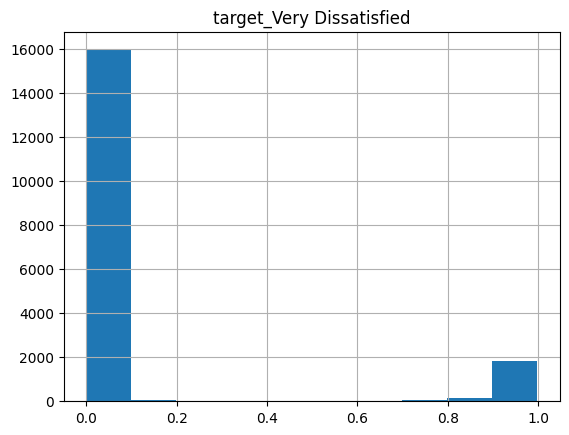

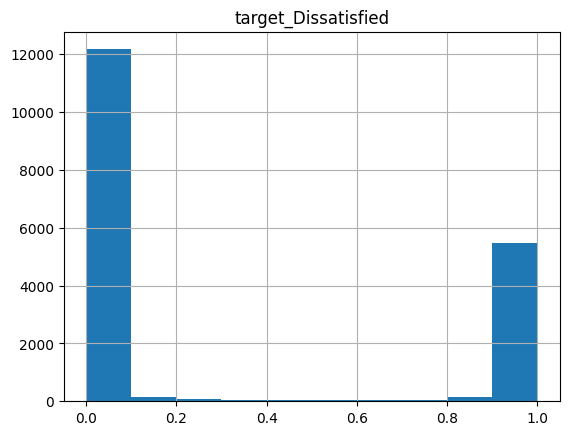

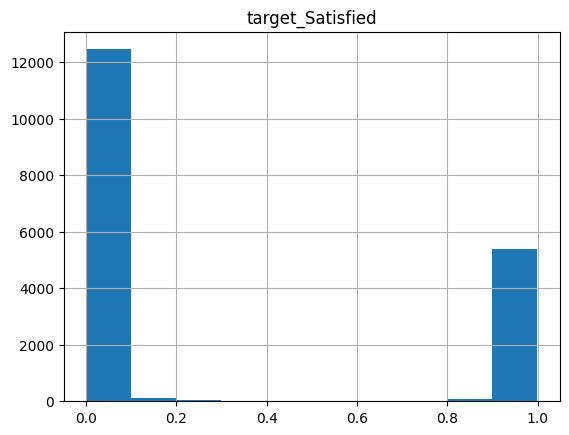

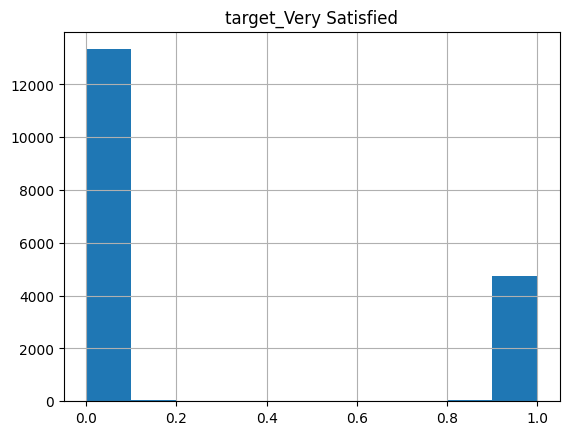

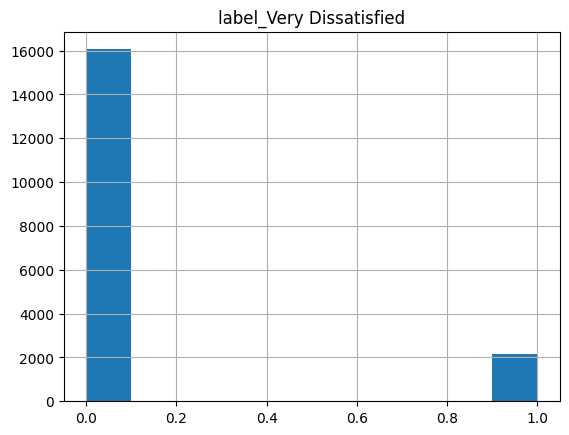

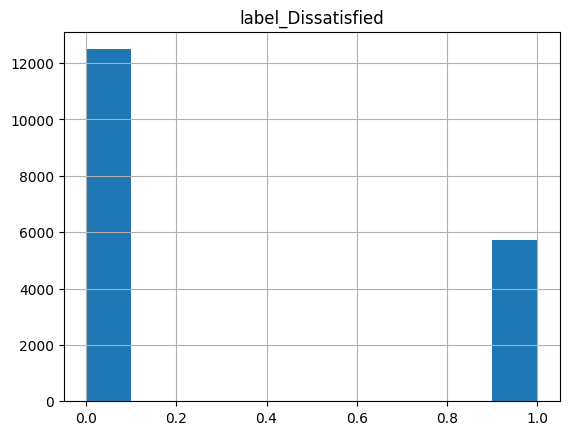

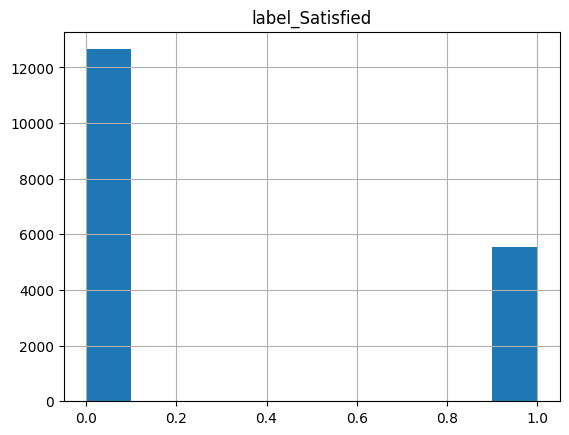

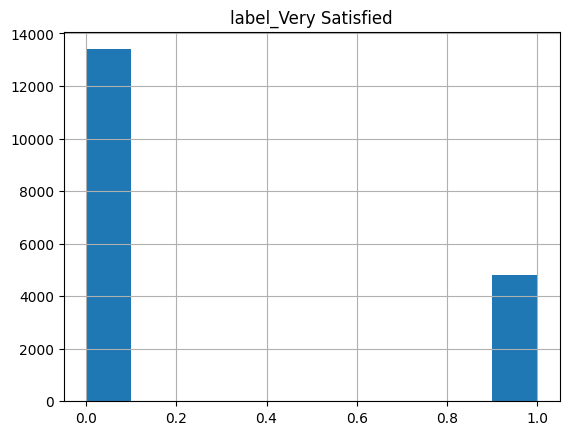

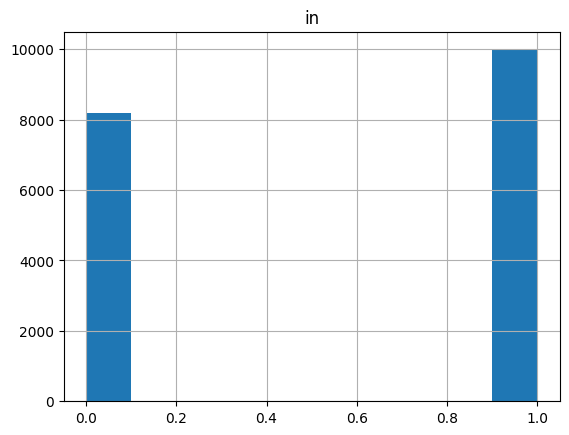

In [157]:
for col in attack_dataset.columns:
  attack_dataset.hist(column=col)

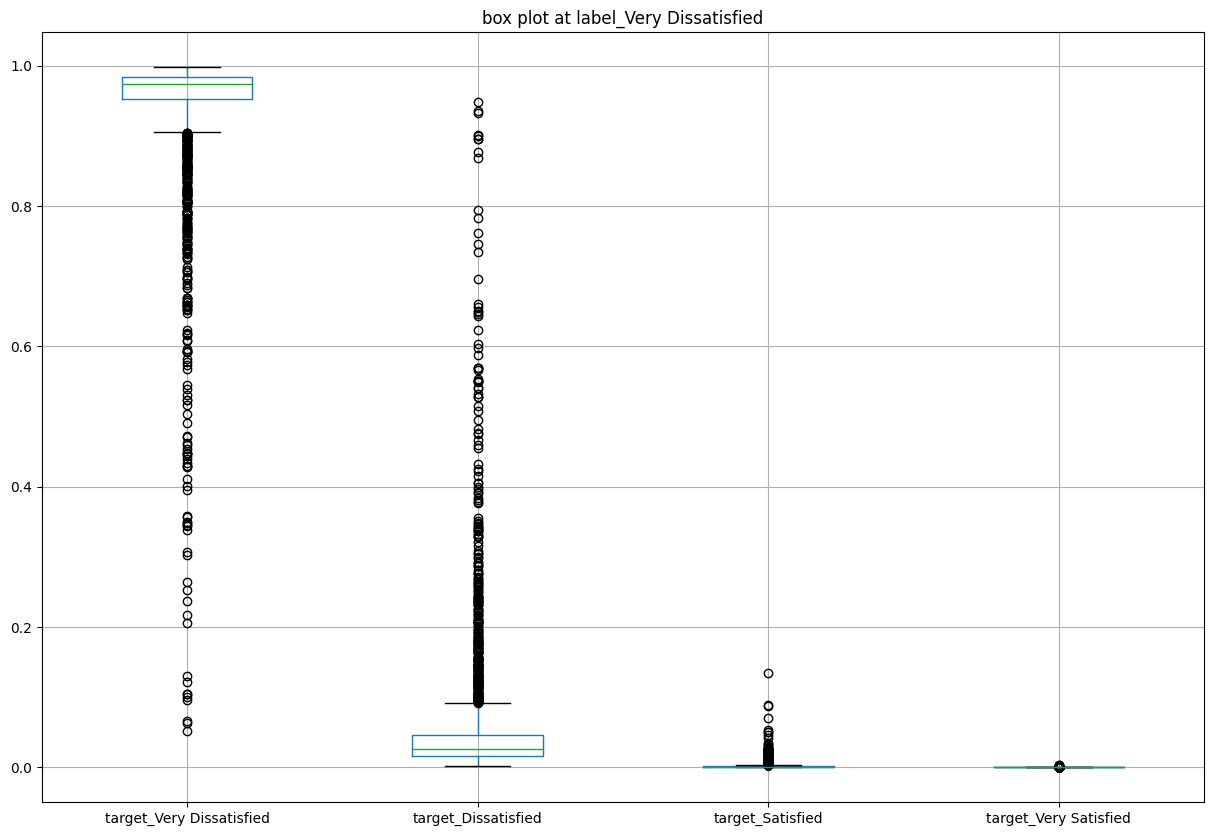

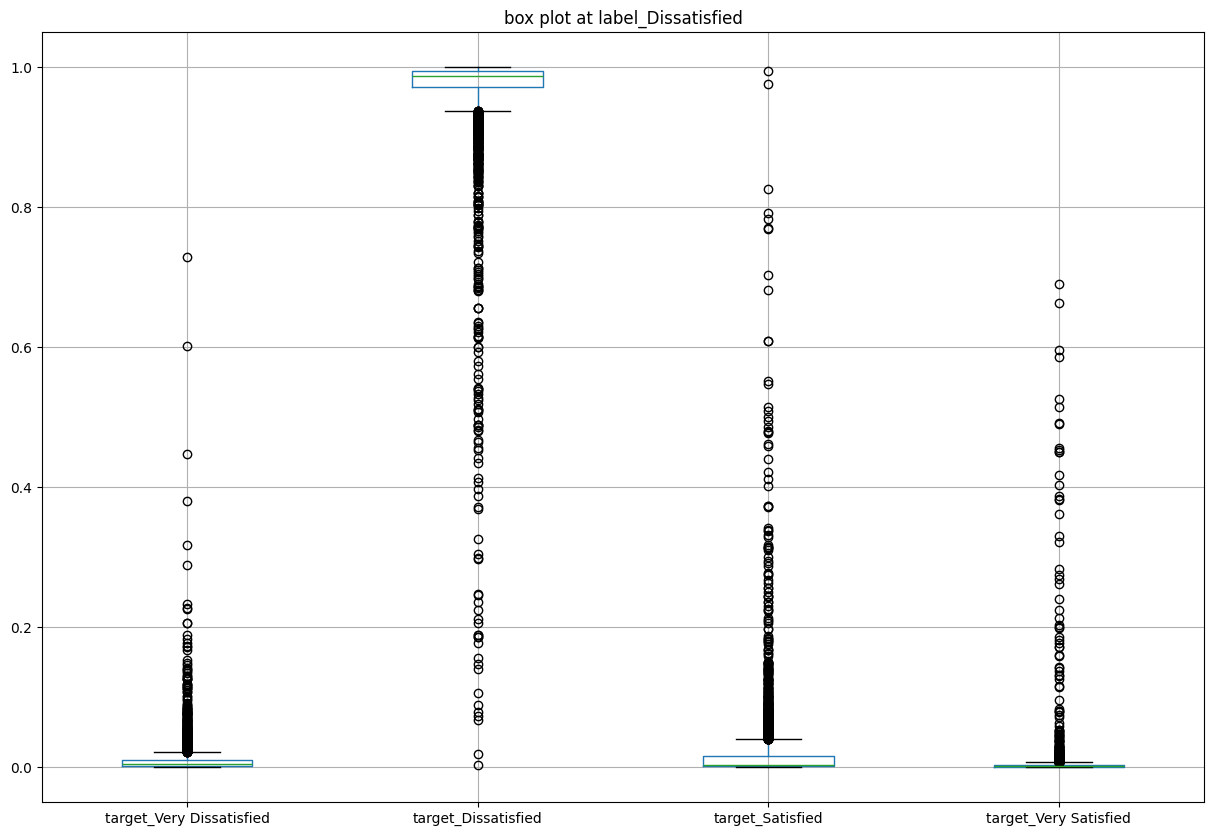

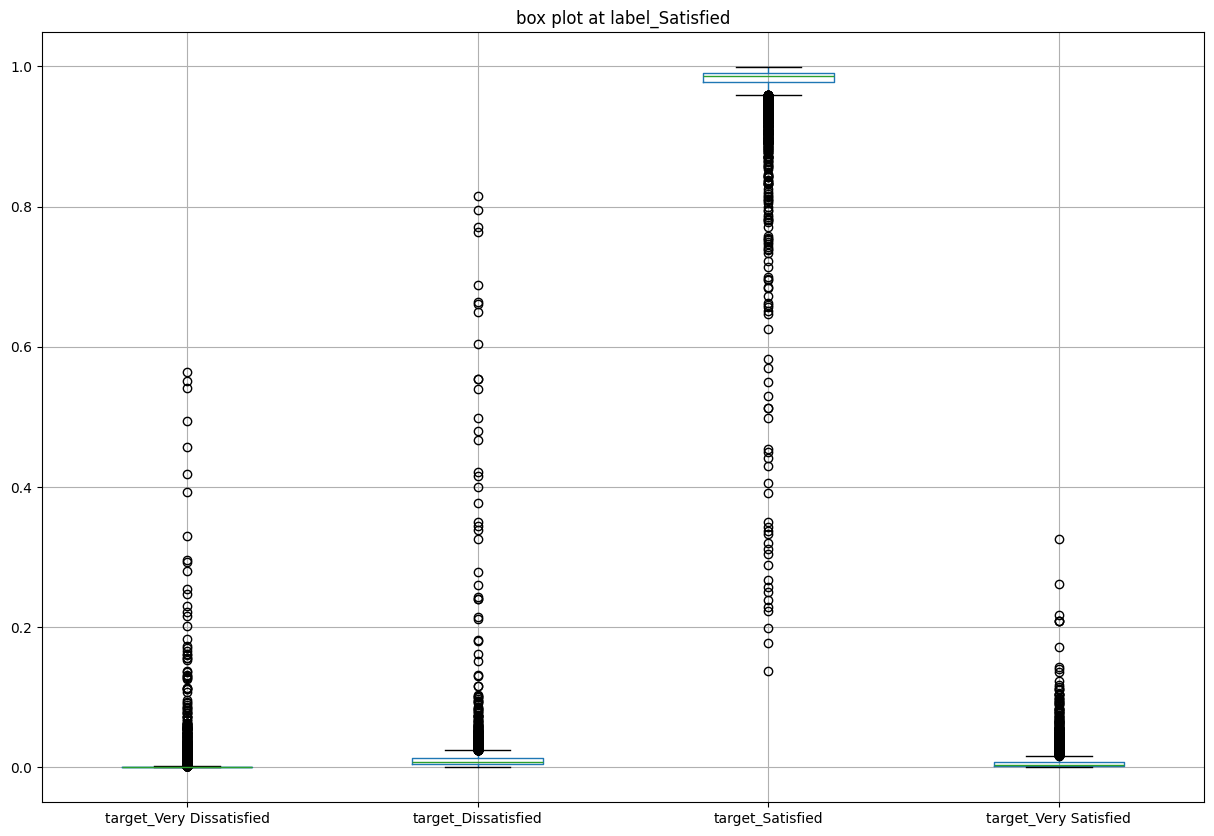

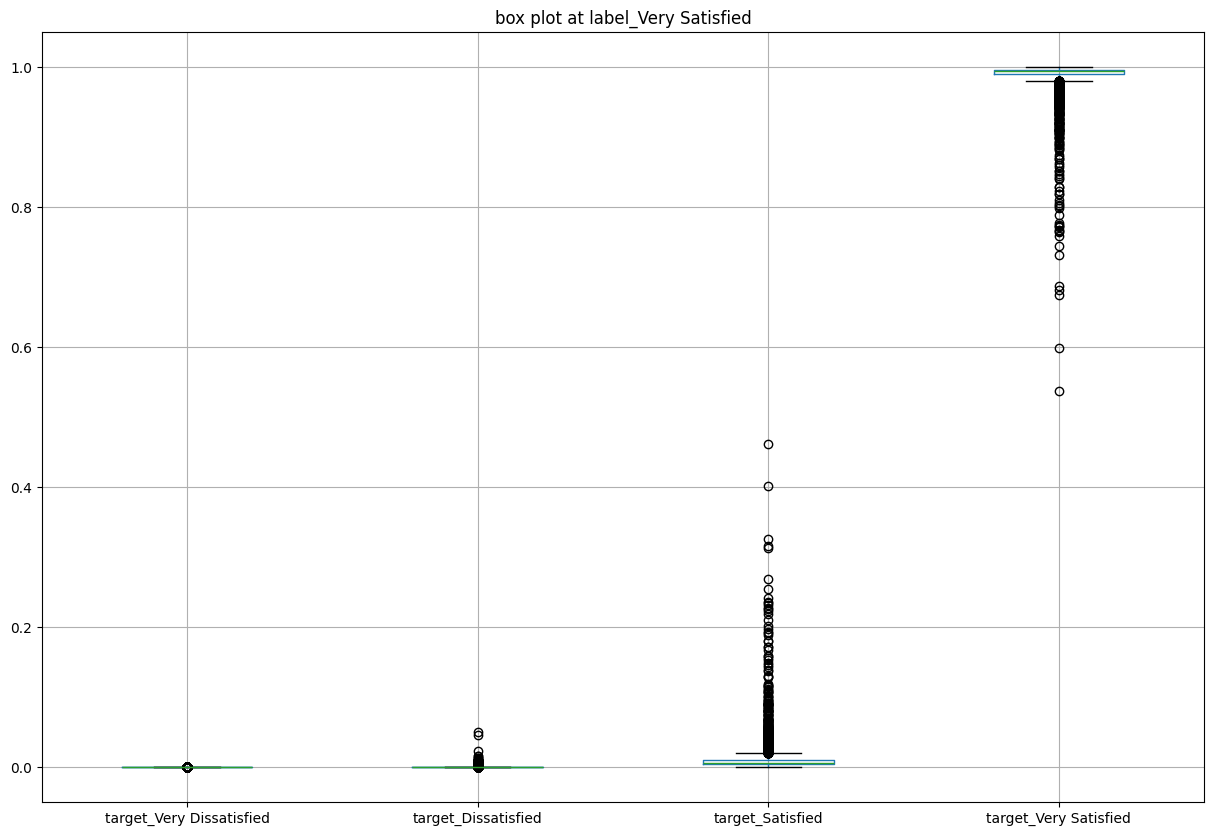

In [158]:
for col in list(attack_dataset.columns)[4:-1]:
  attack_dataset[attack_dataset[col]==1].boxplot(column=list(attack_dataset.columns)[:4],figsize=(15,10))
  plt.title(f"box plot at {col}")
  plt.show()

In [159]:
attack_dataset = attack_dataset.sample(frac=1).reset_index(drop=True)
display(attack_dataset)

target_Very Dissatisfied  target_Dissatisfied  target_Satisfied  \
0                  3.665586e-07             0.006540          0.992311   
1                  9.856731e-03             0.807648          0.182470   
2                  3.776397e-07             0.009919          0.987103   
3                  1.123884e-06             0.002383          0.996309   
4                  5.655638e-03             0.989731          0.003123   
...                         ...                  ...               ...   
18195              9.230066e-01             0.074673          0.002302   
18196              9.469280e-01             0.052752          0.000320   
18197              9.527224e-01             0.046288          0.000982   
18198              2.576050e-06             0.002470          0.995900   
18199              8.538001e-03             0.004947          0.968590   

       target_Very Satisfied  label_Very Dissatisfied  label_Dissatisfied  \
0               1.148370e-03                        0                   0   
1               2.547090e-05                        0                   1   
2               2.978031e-03                        0                   0   
3               1.306391e-03                        0                   0   
4               1.489816e-03                        0                   1   
...                      ...                      ...                 ...   
18195           1.767389e-05                        1                   0   
18196           2.858123e-07                        1                   0   
18197           7.611960e-06                        1                   0   
18198           1.627727e-03                        0                   0   
18199           1.792478e-02                        0                   0   

       label_Satisfied  label_Very Satisfied   in  
0                    1                     0  1.0  
1                    0                     0  0.0  
2                    1                     0  1.0  
3                    1                     0  1.0  
4                    0                     0  0.0  
...                ...                   ...  ...  
18195                0                     0  0.0  
18196                0                     0  0.0  
18197                0                     0  1.0  
18198                1                     0  0.0  
18199                1                     0  0.0  

[18200 rows x 9 columns]

In [160]:
attack_dataset['in'].value_counts()

in
1.0    10000
0.0     8200
Name: count, dtype: int64

In [161]:
attack_datasets = {f"{label}":attack_dataset[attack_dataset[label]==1] for label in list(attack_dataset.columns)[4:-1]}
for label, attack_dataset in attack_datasets.items():
  print(label)
  display(attack_dataset)

label_Very Dissatisfied


target_Very Dissatisfied  target_Dissatisfied  target_Satisfied  \
6                      0.992703             0.007164          0.000133   
13                     0.798181             0.201418          0.000398   
36                     0.985895             0.013875          0.000229   
49                     0.923812             0.068422          0.007558   
69                     0.971238             0.028707          0.000055   
...                         ...                  ...               ...   
18141                  0.432829             0.566531          0.000637   
18173                  0.992656             0.006611          0.000726   
18195                  0.923007             0.074673          0.002302   
18196                  0.946928             0.052752          0.000320   
18197                  0.952722             0.046288          0.000982   

       target_Very Satisfied  label_Very Dissatisfied  label_Dissatisfied  \
6               1.902016e-07                        1                   0   
13              2.553923e-06                        1                   0   
36              8.710931e-07                        1                   0   
49              2.075835e-04                        1                   0   
69              4.132626e-07                        1                   0   
...                      ...                      ...                 ...   
18141           2.527115e-06                        1                   0   
18173           6.801322e-06                        1                   0   
18195           1.767389e-05                        1                   0   
18196           2.858123e-07                        1                   0   
18197           7.611960e-06                        1                   0   

       label_Satisfied  label_Very Satisfied   in  
6                    0                     0  0.0  
13                   0                     0  0.0  
36                   0                     0  1.0  
49                   0                     0  1.0  
69                   0                     0  1.0  
...                ...                   ...  ...  
18141                0                     0  0.0  
18173                0                     0  1.0  
18195                0                     0  0.0  
18196                0                     0  0.0  
18197                0                     0  1.0  

[2137 rows x 9 columns]

label_Dissatisfied


target_Very Dissatisfied  target_Dissatisfied  target_Satisfied  \
1                      0.009857             0.807648          0.182470   
4                      0.005656             0.989731          0.003123   
9                      0.001269             0.994063          0.002098   
12                     0.001620             0.992044          0.001404   
14                     0.005021             0.990031          0.003031   
...                         ...                  ...               ...   
18177                  0.010506             0.987159          0.001906   
18180                  0.001452             0.956558          0.041988   
18181                  0.005490             0.992871          0.001639   
18187                  0.002343             0.987724          0.001207   
18189                  0.001740             0.991305          0.003567   

       target_Very Satisfied  label_Very Dissatisfied  label_Dissatisfied  \
1               2.547090e-05                        0                   1   
4               1.489816e-03                        0                   1   
9               2.570474e-03                        0                   1   
12              4.931821e-03                        0                   1   
14              1.916726e-03                        0                   1   
...                      ...                      ...                 ...   
18177           4.294755e-04                        0                   1   
18180           2.216693e-06                        0                   1   
18181           3.608057e-07                        0                   1   
18187           8.726010e-03                        0                   1   
18189           3.388281e-03                        0                   1   

       label_Satisfied  label_Very Satisfied   in  
1                    0                     0  0.0  
4                    0                     0  0.0  
9                    0                     0  0.0  
12                   0                     0  0.0  
14                   0                     0  0.0  
...                ...                   ...  ...  
18177                0                     0  1.0  
18180                0                     0  0.0  
18181                0                     0  1.0  
18187                0                     0  0.0  
18189                0                     0  1.0  

[5709 rows x 9 columns]

label_Satisfied


target_Very Dissatisfied  target_Dissatisfied  target_Satisfied  \
0                  3.665586e-07             0.006540          0.992311   
2                  3.776397e-07             0.009919          0.987103   
3                  1.123884e-06             0.002383          0.996309   
7                  1.146720e-06             0.006482          0.992811   
8                  4.202246e-05             0.064724          0.929593   
...                         ...                  ...               ...   
18188              6.038047e-06             0.013759          0.978617   
18192              5.351721e-06             0.003082          0.994757   
18194              5.295285e-03             0.001005          0.987392   
18198              2.576050e-06             0.002470          0.995900   
18199              8.538001e-03             0.004947          0.968590   

       target_Very Satisfied  label_Very Dissatisfied  label_Dissatisfied  \
0                   0.001148                        0                   0   
2                   0.002978                        0                   0   
3                   0.001306                        0                   0   
7                   0.000706                        0                   0   
8                   0.005642                        0                   0   
...                      ...                      ...                 ...   
18188               0.007617                        0                   0   
18192               0.002156                        0                   0   
18194               0.006307                        0                   0   
18198               0.001628                        0                   0   
18199               0.017925                        0                   0   

       label_Satisfied  label_Very Satisfied   in  
0                    1                     0  1.0  
2                    1                     0  1.0  
3                    1                     0  1.0  
7                    1                     0  1.0  
8                    1                     0  0.0  
...                ...                   ...  ...  
18188                1                     0  1.0  
18192                1                     0  1.0  
18194                1                     0  1.0  
18198                1                     0  0.0  
18199                1                     0  0.0  

[5550 rows x 9 columns]

label_Very Satisfied


target_Very Dissatisfied  target_Dissatisfied  target_Satisfied  \
5                  3.623272e-07             0.000648          0.009658   
10                 9.619222e-08             0.000061          0.008122   
19                 2.825491e-07             0.000188          0.004855   
20                 6.823063e-08             0.000541          0.004334   
21                 7.004328e-06             0.000713          0.066960   
...                         ...                  ...               ...   
18172              1.433923e-07             0.000034          0.004843   
18186              7.129250e-08             0.000494          0.007027   
18190              1.222722e-07             0.000010          0.003803   
18191              3.432384e-08             0.000009          0.008619   
18193              3.100854e-09             0.000067          0.005966   

       target_Very Satisfied  label_Very Dissatisfied  label_Dissatisfied  \
5                   0.989694                        0                   0   
10                  0.991817                        0                   0   
19                  0.994957                        0                   0   
20                  0.995125                        0                   0   
21                  0.932319                        0                   0   
...                      ...                      ...                 ...   
18172               0.995123                        0                   0   
18186               0.992479                        0                   0   
18190               0.996187                        0                   0   
18191               0.991372                        0                   0   
18193               0.993967                        0                   0   

       label_Satisfied  label_Very Satisfied   in  
5                    0                     1  1.0  
10                   0                     1  1.0  
19                   0                     1  1.0  
20                   0                     1  1.0  
21                   0                     1  0.0  
...                ...                   ...  ...  
18172                0                     1  1.0  
18186                0                     1  1.0  
18190                0                     1  1.0  
18191                0                     1  1.0  
18193                0                     1  1.0  

[4804 rows x 9 columns]

target_Very Dissatisfied  target_Dissatisfied  target_Satisfied  \
14888              3.261661e-06             0.001641          0.004395   
1209               1.377257e-07             0.000001          0.010124   
11682              4.796067e-07             0.000166          0.024182   
2208               1.442115e-04             0.001472          0.012658   
7834               3.177099e-05             0.000314          0.017328   
...                         ...                  ...               ...   
5296               2.418162e-07             0.000011          0.001899   
17442              6.597554e-06             0.000540          0.006260   
12944              8.619588e-06             0.000079          0.004757   
13832              4.394709e-06             0.000554          0.006767   
13668              1.298591e-07             0.000029          0.006181   

       target_Very Satisfied  label_Very Dissatisfied  label_Dissatisfied  \
14888               0.993961                        0                   0   
1209                0.989875                        0                   0   
11682               0.975652                        0                   0   
2208                0.985726                        0                   0   
7834                0.982326                        0                   0   
...                      ...                      ...                 ...   
5296                0.998089                        0                   0   
17442               0.993193                        0                   0   
12944               0.995155                        0                   0   
13832               0.992675                        0                   0   
13668               0.993790                        0                   0   

       label_Satisfied  label_Very Satisfied  
14888                0                     1  
1209                 0                     1  
11682                0                     1  
2208                 0                     1  
7834                 0                     1  
...                ...                   ...  
5296                 0                     1  
17442                0                     1  
12944                0                     1  
13832                0                     1  
13668                0                     1  

[3362 rows x 8 columns]

14888    1.0
1209     1.0
11682    0.0
2208     1.0
7834     0.0
        ... 
5296     0.0
17442    1.0
12944    1.0
13832    0.0
13668    1.0
Name: in, Length: 3362, dtype: float64

<Axes: >

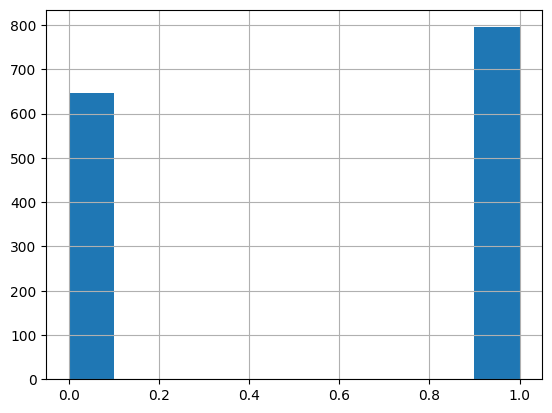

In [162]:
attack_X, attack_y = attack_dataset[list(attack_dataset.columns)[:-1]], attack_dataset['in']
attack_X_train, attack_X_test, attack_y_train, attack_y_test = train_test_split(attack_X,attack_y,train_size=0.7,shuffle=True)
display(attack_X_train)
display(attack_y_train)
attack_y_test.hist()

#Attack Model
The hacker developes the Attack Model which will take prediction distribution and corresponding label and predict whether distribution came from a data point that was in the dataset(1) or not(0). There will be an Attack Model trained for each category the target model predicts.
<br><br>
Due to the shadow dataset's nature of data points from clear data distributions,
the training loss will platueau to ~68% at best.


In [163]:
def train_attack_model(attack_X,attack_y):
  attack_X_train, attack_X_test, attack_y_train, attack_y_test = train_test_split(attack_X,attack_y,train_size=0.7,shuffle=True)
  num_features = len(attack_X_train.columns)
  attack_model = Sequential([
      Dense(4,activation='sigmoid',input_shape=(num_features,)),
      Dense(1,activation='sigmoid',name='output'),
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
  attack_model.compile(
                loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
                # metrics=[keras.metrics.BinaryCrossentropy()])

  attack_history = attack_model.fit(attack_X_train,
            attack_y_train,
            batch_size=64,
            epochs=100,
            validation_data=(attack_X_test,attack_y_test)
            )
  return attack_history

In [164]:
xCols = list(attack_dataset.columns)[:-1]
yCols = list(attack_dataset.columns)[-1]
print(xCols)
print(yCols)
attack_models = {label:train_attack_model(dataset[xCols],dataset[yCols]) for label,dataset in attack_datasets.items()}
print(attack_models)

['target_Very Dissatisfied', 'target_Dissatisfied', 'target_Satisfied', 'target_Very Satisfied', 'label_Very Dissatisfied', 'label_Dissatisfied', 'label_Satisfied', 'label_Very Satisfied']
in
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5005 - loss: 0.6944 - val_accuracy: 0.4922 - val_loss: 0.6947
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5224 - loss: 0.6898 - val_accuracy: 0.4922 - val_loss: 0.6975
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5386 - loss: 0.6871 - val_accuracy: 0.4984 - val_loss: 0.6929
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5431 - loss: 0.6871 - val_accuracy: 0.5109 - val_loss: 0.6912
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5613 - loss: 0.6835 - val_accuracy: 0.5078 - val_loss: 0.6921
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5676 - loss: 0.6819 - val_accuracy: 0.5343 - val_loss: 0.6875
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5742 - loss: 0.6818 - val_accuracy: 0.5327 - val_loss: 0.6876
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5706 - loss: 0.6804 - val_accuracy: 0.5343 - val_loss: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5429 - loss: 0.6896 - val_accuracy: 0.5692 - val_loss: 0.6851
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5344 - loss: 0.6898 - val_accuracy: 0.5756 - val_loss: 0.6853
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5529 - loss: 0.6879 - val_accuracy: 0.5773 - val_loss: 0.6828
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5496 - loss: 0.6870 - val_accuracy: 0.5861 - val_loss: 0.6833
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5480 - loss: 0.6866 - val_accuracy: 0.5809 - val_loss: 0.6790
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5479 - loss: 0.6870 - val_accuracy: 0.5861 - val_loss: 0.6789
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5511 - loss: 0.6868 - val_accuracy: 0.5844 - val_loss: 0.6763
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5647 - loss: 0.6818 - val_accuracy: 0.5954 - val_loss: 0.6

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4447 - loss: 0.7511 - val_accuracy: 0.5654 - val_loss: 0.6856
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5732 - loss: 0.6838 - val_accuracy: 0.5654 - val_loss: 0.6841
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5680 - loss: 0.6837 - val_accuracy: 0.5654 - val_loss: 0.6839
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5558 - loss: 0.6860 - val_accuracy: 0.5654 - val_loss: 0.6832
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5626 - loss: 0.6843 - val_accuracy: 0.5672 - val_loss: 0.6828
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5628 - loss: 0.6842 - val_accuracy: 0.5690 - val_loss: 0.6822
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5590 - loss: 0.6851 - val_accuracy: 0.5708 - val_loss: 0.6815
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5578 - loss: 0.6849 - val_accuracy: 0.5732 - val_loss: 0.6

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4432 - loss: 0.8094 - val_accuracy: 0.4508 - val_loss: 0.6977
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5100 - loss: 0.6917 - val_accuracy: 0.5492 - val_loss: 0.6879
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5399 - loss: 0.6898 - val_accuracy: 0.5492 - val_loss: 0.6877
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5562 - loss: 0.6862 - val_accuracy: 0.5492 - val_loss: 0.6874
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5549 - loss: 0.6864 - val_accuracy: 0.5499 - val_loss: 0.6871
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5655 - loss: 0.6839 - val_accuracy: 0.5499 - val_loss: 0.6869
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5607 - loss: 0.6846 - val_accuracy: 0.5499 - val_loss: 0.6866
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5558 - loss: 0.6857 - val_accuracy: 0.5506 - val_loss: 0.6

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


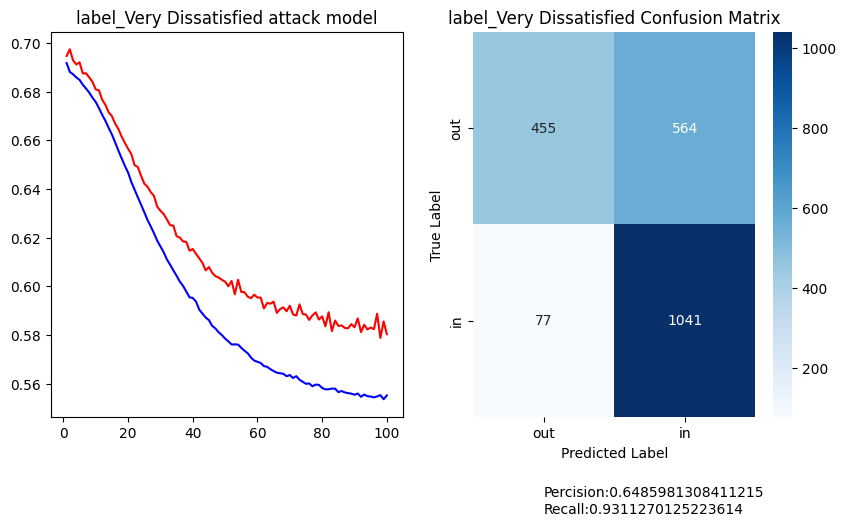

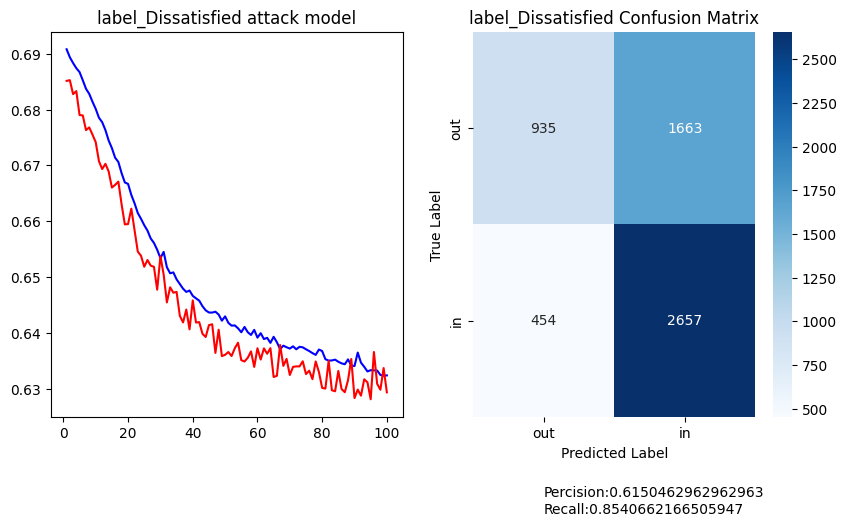

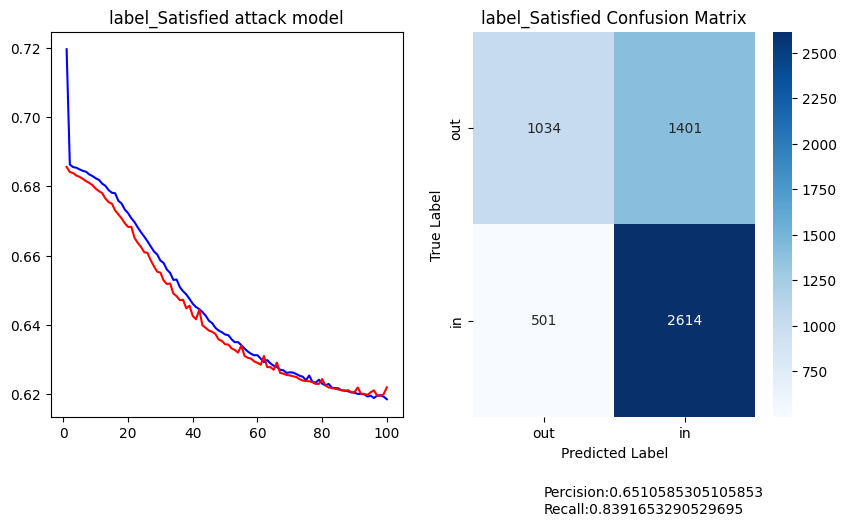

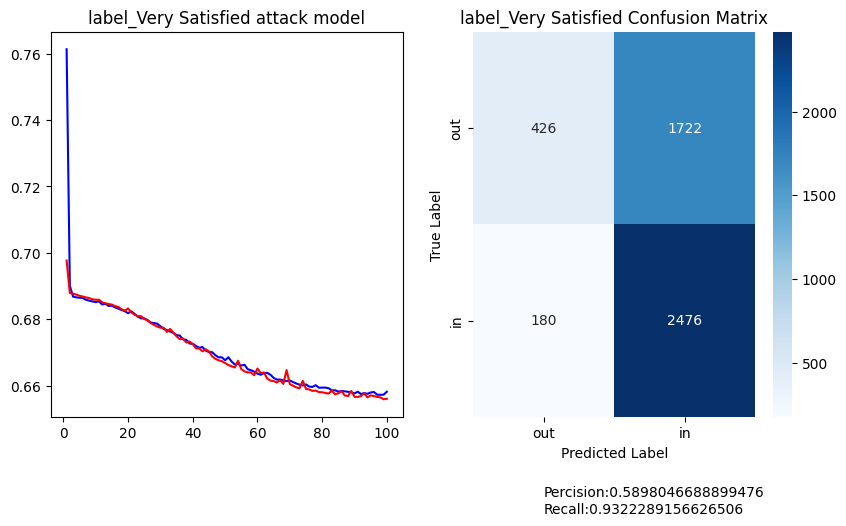

In [165]:
for label, history in attack_models.items():
  attack_model = history.model
  attack_train_loss = history.history['loss']
  attack_val_loss = history.history['val_loss']
  epochs = range(1,len(attack_val_loss) + 1)

  fig, axs = plt.subplots(1,2,figsize=(10,5))
  axs[0].plot(epochs,attack_train_loss,'b',label='attack train loss')
  axs[0].plot(epochs,attack_val_loss,'r',label='attack val loss')
  axs[0].set_title(f'{label} attack model')

  filtered_attack_dataset = attack_datasets[label]
  attack_X,attack_y = filtered_attack_dataset[xCols].to_numpy(), filtered_attack_dataset["in"].to_numpy()
  y_prob = attack_model.predict(attack_X)
  y_pred = (y_prob >= 0.5).astype(int)
  cm = confusion_matrix(attack_y,y_pred.reshape(1,-1).tolist()[0])
  percision = precision_score(attack_y,y_pred)
  recall = recall_score(attack_y,y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['out', 'in'], yticklabels=['out', 'in'],ax=axs[1])
  axs[1].set_title(f'{label} Confusion Matrix')
  axs[1].set_xlabel('Predicted Label')
  axs[1].set_ylabel('True Label')
  axs[1].text(0.5,2.5,f"Percision:{percision}\nRecall:{recall}")


#Membership Inference Attack
The hacker than queries the target model with all the data points in the shadow dataset. The hacker then puts the prediction distributions along with their correspoding lables through the Attack Model. The predicted 'in' probabilites are used to filter out the shadow dataset to leave only data points that are likely to be in the training set the stolen data.

In [166]:
def membership_inference_attack(attack_models,target_model,shadow_dataset):
  # Get the input columns for the target model to retrive the inputs.
  xCols = list(shadow_dataset.columns)[:-4]
  shadow_X = shadow_dataset[xCols]
  satisfaction_levels = list(shadow_dataset.columns[-4:])

  # Query the target model with the shadow dataset for softmax predictions,
  # store them with thier corresponding satisfaction label as the attack model's
  # input.
  target_soft_preds = target_model.predict(shadow_X.to_numpy())
  target_preds_df = pd.DataFrame(target_soft_preds,columns=[f"target {s}" for s in satisfaction_levels])
  attack_inputs_df = pd.concat([target_preds_df,shadow_dataset[satisfaction_levels]],axis=1)

  # Holds all DataFrames that hold stolen data points.
  all_attack_preds = []

  # Iterate satisifaction category with the corresponding its attack model.
  for satisfaction,history in zip(satisfaction_levels,list(attack_models.values())):
    attack_model = history.model
    # Inputs the target would predict as the current satisifaction category.
    attack_inputs = attack_inputs_df[attack_inputs_df[satisfaction] == 1].to_numpy()

    # Get the predictions of attack inputs, place in DataFrame.
    y_prob = attack_model.predict(attack_inputs)
    y_pred = (y_prob >= 0.5).astype(int)
    attack_preds = pd.DataFrame( y_pred,  columns=["in"])

    # Transfer the original indicies from attack_inputs_df to the predictions.
    attack_preds.index = attack_inputs_df[attack_inputs_df[satisfaction] == 1].index
    # Save predictions.
    all_attack_preds.append(attack_preds)

  # Contains all the attack predictions in the original order of the inputs.
  attack_output = pd.concat(all_attack_preds,axis=0)

  # Extract predictions stating the input is within the target's training set
  # and use its indicies to index the inputs from shadow dataset.
  in_dataset_filter_df = attack_output[attack_output["in"] == 1]
  stolen_data = shadow_dataset.iloc[in_dataset_filter_df.index]
  stolen_data.columns = clean_data.columns
  return stolen_data.copy().reset_index(drop=True)


In [167]:
def all_points():
  points = pd.DataFrame(columns=list(shadow_dataset.columns))
  for satisfaction  in [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]:
    for age in range(4):
      age_ops = [0]*4
      age_ops[age] = 1
      for gender in [[1,0,0],[0,1,0],[0,0,1]]:
        for eth in range(7):
          ethnicity  = [0]*7
          ethnicity [eth] = 1
          for distance in range(3):
            distance_ops = [0]*3
            distance_ops[distance] = 1
            point = age_ops + gender + ethnicity + distance_ops +satisfaction
            points.loc[len(points)] = point
  return points
points = all_points()
display(points)

18-25  26-45  45-65  66-90  Male  Female  Non-binary  White  \
0         1      0      0      0     1       0           0      1   
1         1      0      0      0     1       0           0      1   
2         1      0      0      0     1       0           0      1   
3         1      0      0      0     1       0           0      0   
4         1      0      0      0     1       0           0      0   
...     ...    ...    ...    ...   ...     ...         ...    ...   
1003      0      0      0      1     0       0           1      0   
1004      0      0      0      1     0       0           1      0   
1005      0      0      0      1     0       0           1      0   
1006      0      0      0      1     0       0           1      0   
1007      0      0      0      1     0       0           1      0   

      Black/African American  Asian  ...  Native American/Alaska Native  \
0                          0      0  ...                              0   
1                          0      0  ...                              0   
2                          0      0  ...                              0   
3                          1      0  ...                              0   
4                          1      0  ...                              0   
...                      ...    ...  ...                            ...   
1003                       0      0  ...                              0   
1004                       0      0  ...                              0   
1005                       0      0  ...                              0   
1006                       0      0  ...                              0   
1007                       0      0  ...                              0   

      Pacific Islander  Two or More Races  5-10 miles  11-20 miles  \
0                    0                  0           1            0   
1                    0                  0           0            1   
2                    0                  0           0            0   
3                    0                  0           1            0   
4                    0                  0           0            1   
...                ...                ...         ...          ...   
1003                 1                  0           0            1   
1004                 1                  0           0            0   
1005                 0                  1           1            0   
1006                 0                  1           0            1   
1007                 0                  1           0            0   

      21-30 miles  Very Dissatisfied  Dissatisfied  Satisfied  Very Satisfied  
0               0                  1             0          0               0  
1               0                  1             0          0               0  
2               1                  1             0          0               0  
3               0                  1             0          0               0  
4               0                  1             0          0               0  
...           ...                ...           ...        ...             ...  
1003            0                  0             0          0               1  
1004            1                  0             0          0               1  
1005            0                  0             0          0               1  
1006            0                  0             0          0               1  
1007            1                  0             0          0               1  

[1008 rows x 21 columns]

In [168]:
def membership_inference_attack(attack_models,target_model,shadow_dataset):

  # Get the input columns for the target model to retrive the inputs.
  xCols = list(shadow_dataset.columns)[:-4]
  shadow_X = shadow_dataset[xCols]
  satisfaction_levels = list(shadow_dataset.columns[-4:])
  # satisfaction_levels = ['Very_Dissatisfied', 'Dissatisfied', 'Satisfied', 'Very_Dissatisfied']

  # Query the target model with the shadow dataset for softmax predictions,
  # store them with thier corresponding satisfaction label as the attack model's
  # input.
  target_soft_preds = target_model.predict(shadow_X.to_numpy())
  target_preds_df = pd.DataFrame(target_soft_preds,columns=[f"target_{s}" for s in satisfaction_levels])
  attack_inputs_df = pd.concat([target_preds_df,shadow_dataset[satisfaction_levels]],axis=1)

  # Holds all DataFrames that hold stolen data points.
  all_attack_preds = []

  # Iterate satisifaction category with the corresponding its attack model.
  for satisfaction,history in zip(satisfaction_levels,list(attack_models.values())):
    attack_model = history.model
    # Inputs the target would predict as the current satisifaction category.
    attack_inputs = attack_inputs_df[attack_inputs_df[satisfaction] == 1].to_numpy()

    # Get the predictions of attack inputs, place in DataFrame.
    y_prob = attack_model.predict(attack_inputs)
    y_pred = (y_prob >= 0.5).astype(int)
    attack_preds = pd.DataFrame( y_pred,  columns=["in"])

    # Transfer the original indicies from attack_inputs_df to the predictions.
    attack_preds.index = attack_inputs_df[attack_inputs_df[satisfaction] == 1].index
    # Save predictions.
    all_attack_preds.append(attack_preds)

  # Contains all the attack predictions in the original order of the inputs.
  attack_output = pd.concat(all_attack_preds,axis=0)

  # Extract predictions stating the input is within the target's training set
  # and use its indicies to index the inputs from shadow dataset.
  in_dataset_filter_df = attack_output[attack_output["in"] == 1]
  stolen_data = shadow_dataset.iloc[in_dataset_filter_df.index]
  stolen_data.columns = clean_data.columns
  return stolen_data.copy().reset_index(drop=True)


In [169]:
# stolen_data = membership_inference_attack(attack_models,model,shadow_dataset)
infered_data = membership_inference_attack(attack_models,model,points)
display(infered_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


18-25  26-45  46-65  66-95  Male  Female  Non-binary  White  \
0        1      0      0      0     0       1           0      1   
1        1      0      0      0     0       1           0      0   
2        1      0      0      0     0       1           0      0   
3        1      0      0      0     0       1           0      0   
4        1      0      0      0     0       1           0      0   
..     ...    ...    ...    ...   ...     ...         ...    ...   
217      0      0      0      1     0       0           1      0   
218      0      0      0      1     0       0           1      0   
219      0      0      0      1     0       0           1      0   
220      0      0      0      1     0       0           1      0   
221      0      0      0      1     0       0           1      0   

     Black/African_America  Asian  ...  Native American/Alskan Native  \
0                        0      0  ...                              0   
1                        1      0  ...                              0   
2                        0      1  ...                              0   
3                        0      0  ...                              1   
4                        0      0  ...                              0   
..                     ...    ...  ...                            ...   
217                      1      0  ...                              0   
218                      0      1  ...                              0   
219                      0      0  ...                              1   
220                      0      0  ...                              0   
221                      0      0  ...                              0   

     Pacific_Islander  Two_or_More_Races  5-10_miles  11-20_miles  \
0                   0                  0           0            0   
1                   0                  0           0            0   
2                   0                  0           0            0   
3                   0                  0           0            0   
4                   1                  0           0            0   
..                ...                ...         ...          ...   
217                 0                  0           1            0   
218                 0                  0           1            0   
219                 0                  0           1            0   
220                 1                  0           1            0   
221                 0                  1           1            0   

     21-30_miles  Very_Dissatisfied  Dissatisfied  Satisfied  Very_Satisfied  
0              1                  1             0          0               0  
1              1                  1             0          0               0  
2              1                  1             0          0               0  
3              1                  1             0          0               0  
4              1                  1             0          0               0  
..           ...                ...           ...        ...             ...  
217            0                  0             0          0               1  
218            0                  0             0          0               1  
219            0                  0             0          0               1  
220            0                  0             0          0               1  
221            0                  0             0          0               1  

[222 rows x 21 columns]

##Data Breach!
Data was stolen from the Creator's Model training data which includes yours. The Creator wouldn't know the data was stolen and warn you and other survey takers, since the attack was just API calls to the model indistinguishable from other users. This poses a great risk to you as the data you provided in the survey consisted of your age, gender, ethinicity, and how far your home is from the hospital. Data that can be used to identify and locate you is know in the hands of hacker who could give the data to even more nefarious individuals.

In [170]:
infered_data

18-25  26-45  46-65  66-95  Male  Female  Non-binary  White  \
0        1      0      0      0     0       1           0      1   
1        1      0      0      0     0       1           0      0   
2        1      0      0      0     0       1           0      0   
3        1      0      0      0     0       1           0      0   
4        1      0      0      0     0       1           0      0   
..     ...    ...    ...    ...   ...     ...         ...    ...   
217      0      0      0      1     0       0           1      0   
218      0      0      0      1     0       0           1      0   
219      0      0      0      1     0       0           1      0   
220      0      0      0      1     0       0           1      0   
221      0      0      0      1     0       0           1      0   

     Black/African_America  Asian  ...  Native American/Alskan Native  \
0                        0      0  ...                              0   
1                        1      0  ...                              0   
2                        0      1  ...                              0   
3                        0      0  ...                              1   
4                        0      0  ...                              0   
..                     ...    ...  ...                            ...   
217                      1      0  ...                              0   
218                      0      1  ...                              0   
219                      0      0  ...                              1   
220                      0      0  ...                              0   
221                      0      0  ...                              0   

     Pacific_Islander  Two_or_More_Races  5-10_miles  11-20_miles  \
0                   0                  0           0            0   
1                   0                  0           0            0   
2                   0                  0           0            0   
3                   0                  0           0            0   
4                   1                  0           0            0   
..                ...                ...         ...          ...   
217                 0                  0           1            0   
218                 0                  0           1            0   
219                 0                  0           1            0   
220                 1                  0           1            0   
221                 0                  1           1            0   

     21-30_miles  Very_Dissatisfied  Dissatisfied  Satisfied  Very_Satisfied  
0              1                  1             0          0               0  
1              1                  1             0          0               0  
2              1                  1             0          0               0  
3              1                  1             0          0               0  
4              1                  1             0          0               0  
..           ...                ...           ...        ...             ...  
217            0                  0             0          0               1  
218            0                  0             0          0               1  
219            0                  0             0          0               1  
220            0                  0             0          0               1  
221            0                  0             0          0               1  

[222 rows x 21 columns]

In [188]:
stolen_training_data = pd.merge(infered_data, clean_data.iloc[:101],how='inner',on=list(clean_data.columns))
display(stolen_training_data)

18-25  26-45  46-65  66-95  Male  Female  Non-binary  White  \
0       1      0      0      0     0       1           0      0   
1       1      0      0      0     0       1           0      0   
2       0      1      0      0     0       1           0      1   
3       0      1      0      0     0       1           0      0   
4       0      1      0      0     0       1           0      0   
..    ...    ...    ...    ...   ...     ...         ...    ...   
86      0      0      0      1     1       0           0      0   
87      0      0      0      1     1       0           0      0   
88      0      0      0      1     1       0           0      0   
89      0      0      0      1     0       0           1      1   
90      0      0      0      1     0       0           1      0   

    Black/African_America  Asian  ...  Native American/Alskan Native  \
0                       0      0  ...                              1   
1                       0      0  ...                              1   
2                       0      0  ...                              0   
3                       1      0  ...                              0   
4                       0      0  ...                              1   
..                    ...    ...  ...                            ...   
86                      0      1  ...                              0   
87                      0      0  ...                              1   
88                      0      0  ...                              1   
89                      0      0  ...                              0   
90                      0      1  ...                              0   

    Pacific_Islander  Two_or_More_Races  5-10_miles  11-20_miles  21-30_miles  \
0                  0                  0           0            0            1   
1                  0                  0           0            0            1   
2                  0                  0           0            0            1   
3                  0                  0           0            0            1   
4                  0                  0           0            0            1   
..               ...                ...         ...          ...          ...   
86                 0                  0           1            0            0   
87                 0                  0           1            0            0   
88                 0                  0           1            0            0   
89                 0                  0           1            0            0   
90                 0                  0           1            0            0   

    Very_Dissatisfied  Dissatisfied  Satisfied  Very_Satisfied  
0                   1             0          0               0  
1                   1             0          0               0  
2                   1             0          0               0  
3                   1             0          0               0  
4                   1             0          0               0  
..                ...           ...        ...             ...  
86                  0             0          0               1  
87                  0             0          0               1  
88                  0             0          0               1  
89                  0             0          0               1  
90                  0             0          0               1  

[91 rows x 21 columns]

In [189]:
print(f"{round(stolen_training_data.shape[0]/X_train.shape[0],2)*100}% of the Model's training data was stolen!")

91.0% of the Model's training data was stolen!


In [190]:
stolen_data = pd.merge(infered_data,clean_data,how='inner',on=list(clean_data.columns))
display(stolen_data)

18-25  26-45  46-65  66-95  Male  Female  Non-binary  White  \
0        1      0      0      0     0       1           0      1   
1        1      0      0      0     0       1           0      1   
2        1      0      0      0     0       1           0      0   
3        1      0      0      0     0       1           0      0   
4        1      0      0      0     0       1           0      0   
..     ...    ...    ...    ...   ...     ...         ...    ...   
805      0      0      0      1     0       0           1      0   
806      0      0      0      1     0       0           1      0   
807      0      0      0      1     0       0           1      0   
808      0      0      0      1     0       0           1      0   
809      0      0      0      1     0       0           1      0   

     Black/African_America  Asian  ...  Native American/Alskan Native  \
0                        0      0  ...                              0   
1                        0      0  ...                              0   
2                        1      0  ...                              0   
3                        1      0  ...                              0   
4                        1      0  ...                              0   
..                     ...    ...  ...                            ...   
805                      0      0  ...                              1   
806                      0      0  ...                              0   
807                      0      0  ...                              0   
808                      0      0  ...                              0   
809                      0      0  ...                              0   

     Pacific_Islander  Two_or_More_Races  5-10_miles  11-20_miles  \
0                   0                  0           0            0   
1                   0                  0           0            0   
2                   0                  0           0            0   
3                   0                  0           0            0   
4                   0                  0           0            0   
..                ...                ...         ...          ...   
805                 0                  0           1            0   
806                 1                  0           1            0   
807                 0                  1           1            0   
808                 0                  1           1            0   
809                 0                  1           1            0   

     21-30_miles  Very_Dissatisfied  Dissatisfied  Satisfied  Very_Satisfied  
0              1                  1             0          0               0  
1              1                  1             0          0               0  
2              1                  1             0          0               0  
3              1                  1             0          0               0  
4              1                  1             0          0               0  
..           ...                ...           ...        ...             ...  
805            0                  0             0          0               1  
806            0                  0             0          0               1  
807            0                  0             0          0               1  
808            0                  0             0          0               1  
809            0                  0             0          0               1  

[810 rows x 21 columns]

In [191]:
print(f"{round(stolen_data.shape[0]/clean_data.shape[0],2)*100}% of the Survey data was stolen!")

81.0% of the Survey data was stolen!


With Data Breach of this size did your data get stolen?<br>
You'll see if any rows appear in the results of the cell below.

In [192]:
your_data_clean = pd.DataFrame(X_train.iloc[30]).T
your_stolen_data = pd.merge(your_data_clean, stolen_data, how="inner")
display(your_stolen_data)


Empty DataFrame
Columns: [18-25, 26-45, 46-65, 66-95, Male, Female, Non-binary, White, Black/African_America, Asian, Hispanic/Latinx, Native American/Alskan Native, Pacific_Islander, Two_or_More_Races, 5-10_miles, 11-20_miles, 21-30_miles, Very_Dissatisfied, Dissatisfied, Satisfied, Very_Satisfied]
Index: []

[0 rows x 21 columns]